In [6]:
from bs4 import BeautifulSoup
%run stem.ipynb
%run volatility_functions.ipynb
%run correlation_functions.ipynb

In [12]:
import yaml
import importlib.metadata

# The name for your output file
output_filename = 'packages.yaml'

# 1. Get all installed packages and their versions
# We use a dictionary to store them in a 'package_name: version' format.
try:
    # This is the modern and recommended way for Python 3.8+
    installed_packages = {
        dist.metadata['name']: dist.version
        for dist in importlib.metadata.distributions()
    }
except Exception as e:
    print(f"Could not retrieve package list: {e}")
    installed_packages = {}

# 2. Write the dictionary to a YAML file
if installed_packages:
    with open(output_filename, 'w') as file:
        # yaml.dump() converts the Python dict to YAML format
        # sort_keys=True makes the file easier to navigate
        yaml.dump(installed_packages, file, sort_keys=True, indent=2)

    print(f"✅ Successfully created '{output_filename}' with {len(installed_packages)} packages.")
else:
    print("❌ No packages found or an error occurred.")

✅ Successfully created 'packages.yaml' with 716 packages.


In [7]:
latest_pval=lambda s: larger_proportion(s.dropna(),s[-1])

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list
from scipy.spatial.distance import pdist

def clustered_heatmap(df, 
                     method='ward', 
                     metric='euclidean',
                     cluster_rows=True, 
                     cluster_cols=True,
                     figsize=(12, 10),
                     cmap='viridis',
                     annot=False,
                     fmt='.2f',
                     use_seaborn_clustermap=True,
                     **kwargs):
    """
    Create a heatmap with hierarchical clustering of rows and/or columns.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe to cluster and plot
    method : str, default 'ward'
        Linkage method for clustering ('ward', 'complete', 'average', 'single')
    metric : str, default 'euclidean'
        Distance metric ('euclidean', 'correlation', 'cosine', etc.)
    cluster_rows : bool, default True
        Whether to cluster rows
    cluster_cols : bool, default True
        Whether to cluster columns
    figsize : tuple, default (12, 10)
        Figure size (width, height)
    cmap : str, default 'viridis'
        Colormap for heatmap
    annot : bool, default False
        Whether to annotate cells with values
    fmt : str, default '.2f'
        String formatting for annotations
    use_seaborn_clustermap : bool, default True
        Whether to use seaborn's clustermap (recommended) or custom implementation
    **kwargs : additional arguments
        Additional arguments passed to seaborn plotting functions
    
    Returns:
    --------
    If use_seaborn_clustermap=True:
        ClusterGrid object from seaborn
    If use_seaborn_clustermap=False:
        tuple: (fig, clustered_df)
    """
    
    # Handle missing values
    df_clean = df.fillna(0)
    
    if use_seaborn_clustermap:
        # Use seaborn's clustermap - this ensures perfect alignment
        g = sns.clustermap(df_clean,
                          method=method,
                          metric=metric,
                          row_cluster=cluster_rows,
                          col_cluster=cluster_cols,
                          figsize=figsize,
                          cmap=cmap,
                          annot=annot,
                          fmt=fmt,
                          **kwargs)
        
        # Access the clustered dataframe
        clustered_df = df_clean.iloc[g.dendrogram_row.reordered_ind, 
                                    g.dendrogram_col.reordered_ind]
        
        return g, clustered_df
    
    else:
        # Custom implementation with proper alignment
        return _custom_clustered_heatmap(df_clean, method, metric, cluster_rows, 
                                       cluster_cols, figsize, cmap, annot, fmt, **kwargs)


def _custom_clustered_heatmap(df, method, metric, cluster_rows, cluster_cols, 
                             figsize, cmap, annot, fmt, **kwargs):
    """
    Custom implementation of clustered heatmap with proper dendrogram alignment.
    """
    
    # Initialize variables
    row_linkage = None
    col_linkage = None
    row_order = list(range(len(df)))
    col_order = list(range(len(df.columns)))
    
    # Perform hierarchical clustering for rows
    if cluster_rows and len(df) > 1:
        row_distances = pdist(df.values, metric=metric)
        row_linkage = linkage(row_distances, method=method)
        row_order = leaves_list(row_linkage)
    
    # Perform hierarchical clustering for columns
    if cluster_cols and len(df.columns) > 1:
        col_distances = pdist(df.T.values, metric=metric)
        col_linkage = linkage(col_distances, method=method)
        col_order = leaves_list(col_linkage)
    
    # Reorder dataframe
    clustered_df = df.iloc[row_order, col_order]
    
    # Create the plot
    fig = plt.figure(figsize=figsize)
    
    # Calculate subplot positions
    show_row_dendr = cluster_rows and len(df) > 1 and row_linkage is not None
    show_col_dendr = cluster_cols and len(df.columns) > 1 and col_linkage is not None
    
    dendr_height = 0.15 if show_col_dendr else 0
    dendr_width = 0.15 if show_row_dendr else 0
    
    # Main heatmap position
    heatmap_left = dendr_width + 0.05
    heatmap_bottom = 0.1
    heatmap_width = 0.85 - dendr_width
    heatmap_height = 0.85 - dendr_height
    
    # Create main heatmap
    ax_heatmap = fig.add_axes([heatmap_left, heatmap_bottom, 
                             heatmap_width, heatmap_height])
    
    # Plot heatmap with clustered data
    im = ax_heatmap.imshow(clustered_df.values, cmap=cmap, aspect='auto')
    
    # Set ticks and labels
    ax_heatmap.set_xticks(range(len(clustered_df.columns)))
    ax_heatmap.set_yticks(range(len(clustered_df.index)))
    ax_heatmap.set_xticklabels(clustered_df.columns, rotation=45, ha='right')
    ax_heatmap.set_yticklabels(clustered_df.index)
    
    # Add annotations if requested
    if annot:
        for i in range(len(clustered_df.index)):
            for j in range(len(clustered_df.columns)):
                text = ax_heatmap.text(j, i, format(clustered_df.iloc[i, j], fmt),
                                     ha="center", va="center", color="white" if clustered_df.iloc[i, j] < clustered_df.values.mean() else "black")
    
    # Add colorbar
    cbar_ax = fig.add_axes([0.92, heatmap_bottom, 0.03, heatmap_height])
    fig.colorbar(im, cax=cbar_ax)
    
    # Add column dendrogram
    if show_col_dendr:
        ax_col_dendr = fig.add_axes([heatmap_left, heatmap_bottom + heatmap_height + 0.02, 
                                   heatmap_width, dendr_height])
        
        # Create temporary dendrogram to get the correct ordering
        temp_dendr = dendrogram(col_linkage, no_plot=True)
        
        # Plot dendrogram with correct leaf order
        dendr_plot = dendrogram(col_linkage, ax=ax_col_dendr, 
                               orientation='top', 
                               color_threshold=0,
                               above_threshold_color='black')
        
        ax_col_dendr.set_xticks([])
        ax_col_dendr.set_yticks([])
        for spine in ax_col_dendr.spines.values():
            spine.set_visible(False)
    
    # Add row dendrogram
    if show_row_dendr:
        ax_row_dendr = fig.add_axes([0.05, heatmap_bottom, 
                                   dendr_width, heatmap_height])
        
        # Create temporary dendrogram to get the correct ordering
        temp_dendr = dendrogram(row_linkage, no_plot=True)
        
        # Plot dendrogram with correct leaf order
        dendr_plot = dendrogram(row_linkage, ax=ax_row_dendr, 
                               orientation='left',
                               color_threshold=0,
                               above_threshold_color='black')
        
        ax_row_dendr.set_xticks([])
        ax_row_dendr.set_yticks([])
        for spine in ax_row_dendr.spines.values():
            spine.set_visible(False)
    
    plt.tight_layout()
    return fig, clustered_df


# Simplified function using seaborn (recommended)
def quick_clustered_heatmap(df, **kwargs):
    """
    Quick and easy clustered heatmap using seaborn's clustermap.
    This is the recommended approach for most use cases.
    """
    defaults = {
        'method': 'ward',
        'metric': 'euclidean', 
        'figsize': (12, 10),
        'cmap': 'viridis',
        'annot': False
    }
    defaults.update(kwargs)
    
    g = sns.clustermap(df.fillna(0), **defaults)
    return g


# # Example usage function
# def example_usage():
#     """
#     Example of how to use the clustered_heatmap function
#     """
#     # Create sample data
#     np.random.seed(42)
#     data = np.random.randn(20, 15)
    
#     # Add some structure to make clustering meaningful
#     data[:10, :7] += 2  # Upper-left quadrant
#     data[10:, 7:] += 2  # Lower-right quadrant
    
#     # Create DataFrame
#     df = pd.DataFrame(data, 
#                      index=[f'Gene_{i}' for i in range(20)],
#                      columns=[f'Sample_{i}' for i in range(15)])
    
#     # Method 1: Using seaborn clustermap (recommended)
#     print("Creating clustered heatmap using seaborn...")
#     g = quick_clustered_heatmap(df, 
#                                cmap='RdBu_r',
#                                figsize=(12, 8))
#     plt.suptitle('Seaborn Clustered Heatmap', y=0.95)
#     plt.show()
    
#     # Method 2: Using custom function
#     print("Creating clustered heatmap using custom function...")
#     result = clustered_heatmap(df,
#                               method='ward',
#                               metric='euclidean',
#                               figsize=(14, 10),
#                               cmap='RdBu_r',
#                               annot=False,
#                               use_seaborn_clustermap=True)
    
#     if len(result) == 2:
#         g, clustered_df = result
#         plt.suptitle('Custom Clustered Heatmap', y=0.95)
#         plt.show()
#         return clustered_df
#     else:
#         g = result
#         return g

# # Uncomment to run example
# example_usage()

In [9]:
import yfinance as yf
import pandas as pd
import numpy as np

class FinanceDataCache:
    def __init__(self, cache_dir="finance_cache"):
        """Initialize the cache system"""
        self.cache_dir = Path(cache_dir)
        self.cache_dir.mkdir(exist_ok=True)
        
    def _get_cache_filename(self, symbol):
        """Generate cache filename for a symbol"""
        return self.cache_dir / f"{symbol.replace('/', '_').replace('^', '_')}.pkl"
    
    def _load_cached_data(self, symbol):
        """Load cached data for a symbol"""
        cache_file = self._get_cache_filename(symbol)
        if cache_file.exists():
            try:
                with open(cache_file, 'rb') as f:
                    cached_data = pickle.load(f)
                return cached_data['data'], cached_data['last_update']
            except Exception as e:
                print(f"Warning: Could not load cache for {symbol}: {e}")
                return None, None
        return None, None
    
    def _save_cached_data(self, symbol, data):
        """Save data to cache"""
        cache_file = self._get_cache_filename(symbol)
        try:
            cache_data = {
                'data': data,
                'last_update': datetime.now(),
                'symbol': symbol
            }
            with open(cache_file, 'wb') as f:
                pickle.dump(cache_data, f)
        except Exception as e:
            print(f"Warning: Could not save cache for {symbol}: {e}")
    
    def _merge_data(self, old_data, new_data):
        """Merge old cached data with new data, removing duplicates"""
        if old_data is None or old_data.empty:
            return new_data
        if new_data is None or new_data.empty:
            return old_data
            
        # Combine and remove duplicates, keeping the most recent data
        combined = pd.concat([old_data, new_data])
        combined = combined[~combined.index.duplicated(keep='last')]
        return combined.sort_index()
    
    def _determine_missing_ranges(self, cached_data, start_date, end_date):
        """Determine what date ranges need to be fetched"""
        if cached_data is None or cached_data.empty:
            return [(start_date, end_date)]
        
        cached_start = cached_data.index.min().date()
        cached_end = cached_data.index.max().date()
        
        # Convert string dates to datetime objects if needed
        if isinstance(start_date, str):
            start_date = datetime.strptime(start_date, '%Y-%m-%d').date()
        if isinstance(end_date, str):
            end_date = datetime.strptime(end_date, '%Y-%m-%d').date()
        
        ranges_to_fetch = []
        
        # Check if we need data before cached start
        if start_date < cached_start:
            # Fetch up to one day before cached start to avoid gaps
            fetch_end = cached_start - timedelta(days=1)
            ranges_to_fetch.append((start_date, fetch_end))
        
        # Check if we need data after cached end
        if end_date > cached_end:
            # Fetch from one day after cached end
            fetch_start = cached_end + timedelta(days=1)
            ranges_to_fetch.append((fetch_start, end_date))
        
        return ranges_to_fetch

# Global cache instance
_cache = FinanceDataCache()

def downloader(symbol, start_date, end_date, force_refresh=False, cache_dir="finance_cache"):
    """
    Enhanced function to download financial data with intelligent caching
    
    Parameters:
    -----------
    symbol : str
        Stock/asset symbol (e.g., 'AAPL', 'SPY')
    start_date : str or datetime
        Start date in 'YYYY-MM-DD' format
    end_date : str or datetime  
        End date in 'YYYY-MM-DD' format
    force_refresh : bool
        If True, ignore cache and download all data fresh
    cache_dir : str
        Directory to store cache files
        
    Returns:
    --------
    pandas.DataFrame
        Financial data with OHLCV columns
    """
    global _cache
    
    # Initialize cache with custom directory if specified
    if cache_dir != "finance_cache":
        _cache = FinanceDataCache(cache_dir)
    
    print(f"Processing data request for {symbol} from {start_date} to {end_date}...")
    
    if force_refresh:
        print(f"Force refresh enabled - downloading all data for {symbol}...")
        data = yf.download(symbol, start=start_date, end=end_date)
        _cache._save_cached_data(symbol, data)
        return data
    
    # Load cached data
    cached_data, last_update = _cache._load_cached_data(symbol)
    
    if cached_data is not None:
        print(f"Found cached data for {symbol} (last updated: {last_update.strftime('%Y-%m-%d %H:%M:%S')})")
        
        # Determine what ranges we need to fetch
        missing_ranges = _cache._determine_missing_ranges(cached_data, start_date, end_date)
        
        if not missing_ranges:
            print(f"All requested data for {symbol} available in cache!")
            # Filter cached data to requested range
            start_dt = pd.to_datetime(start_date)
            end_dt = pd.to_datetime(end_date)
            filtered_data = cached_data[(cached_data.index >= start_dt) & (cached_data.index <= end_dt)]
            return filtered_data
        
        # Fetch missing data
        all_new_data = pd.DataFrame()
        for range_start, range_end in missing_ranges:
            print(f"Fetching missing data for {symbol}: {range_start} to {range_end}")
            new_data = yf.download(symbol, start=range_start, end=range_end)
            if not new_data.empty:
                all_new_data = pd.concat([all_new_data, new_data])
        
        # Merge cached and new data
        complete_data = _cache._merge_data(cached_data, all_new_data)
        
    else:
        print(f"No cached data found for {symbol} - downloading all data...")
        complete_data = yf.download(symbol, start=start_date, end=end_date)
    
    # Save updated data to cache
    _cache._save_cached_data(symbol, complete_data)
    
    # Return only the requested date range
    start_dt = pd.to_datetime(start_date)
    end_dt = pd.to_datetime(end_date)
    filtered_data = complete_data[(complete_data.index >= start_dt) & (complete_data.index <= end_dt)]
    
    print(f"Data download complete for {symbol}. Shape: {filtered_data.shape}")
    return filtered_data

def clear_cache(symbol=None, cache_dir="finance_cache"):
    """
    Clear cache for specific symbol or all symbols
    
    Parameters:
    -----------
    symbol : str, optional
        Specific symbol to clear. If None, clears all cache
    cache_dir : str
        Cache directory path
    """
    cache = FinanceDataCache(cache_dir)
    
    if symbol:
        cache_file = cache._get_cache_filename(symbol)
        if cache_file.exists():
            cache_file.unlink()
            print(f"Cache cleared for {symbol}")
        else:
            print(f"No cache found for {symbol}")
    else:
        # Clear all cache files
        for cache_file in cache.cache_dir.glob("*.pkl"):
            cache_file.unlink()
        print("All cache files cleared")

def list_cached_symbols(cache_dir="finance_cache"):
    """
    List all symbols that have cached data
    
    Parameters:
    -----------
    cache_dir : str
        Cache directory path
        
    Returns:
    --------
    list
        List of cached symbols with their info
    """
    cache = FinanceDataCache(cache_dir)
    cached_symbols = []
    
    for cache_file in cache.cache_dir.glob("*.pkl"):
        try:
            with open(cache_file, 'rb') as f:
                cached_data = pickle.load(f)
            
            data = cached_data['data']
            symbol_info = {
                'symbol': cached_data['symbol'],
                'last_update': cached_data['last_update'],
                'date_range': f"{data.index.min().date()} to {data.index.max().date()}",
                'records': len(data),
                'file_size': f"{cache_file.stat().st_size / 1024:.1f} KB"
            }
            cached_symbols.append(symbol_info)
        except Exception as e:
            print(f"Error reading cache file {cache_file}: {e}")
    
    return cached_symbols

# # Example usage and testing
# if __name__ == "__main__":
#     # Example 1: Basic usage
#     print("=== Example 1: Basic Usage ===")
#     data1 = downloader("AAPL", "2023-01-01", "2023-12-31")
#     print(f"Downloaded {len(data1)} records for AAPL")
    
#     # Example 2: Second call should use cache
#     print("\n=== Example 2: Cache Usage ===")
#     data2 = downloader("AAPL", "2023-06-01", "2023-08-31")  # Should use cache
#     print(f"Retrieved {len(data2)} records for AAPL (from cache)")
    
#     # Example 3: Extending date range
#     print("\n=== Example 3: Extending Range ===")
#     data3 = downloader("AAPL", "2022-01-01", "2024-01-31")  # Should fetch missing parts
#     print(f"Retrieved {len(data3)} records for AAPL (extended range)")
    
#     # Example 4: List cached data
#     print("\n=== Example 4: Cache Info ===")
#     cached = list_cached_symbols()
#     for info in cached:
#         print(f"Symbol: {info['symbol']}")
#         print(f"  Date Range: {info['date_range']}")
#         print(f"  Records: {info['records']}")
#         print(f"  Last Updated: {info['last_update']}")
#         print(f"  File Size: {info['file_size']}")

In [10]:
start_date = '2007-01-03'
#today = datetime.now()
#end_date = (today - timedelta(days=2)).strftime('%Y-%m-%d')
n_days=252*10

In [11]:
end_date='2025-09-13'

In [12]:
all_price=dict()
for stock in symbols:
    data =  downloader(stock, start_date,end_date)
    all_price[stock]=data
combined_df=_organise_price_data(all_price, n_days)

Processing data request for AAPL from 2007-01-03 to 2025-09-13...
Found cached data for AAPL (last updated: 2025-09-15 18:43:56)
Fetching missing data for AAPL: 2025-09-13 to 2025-09-13
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-09-13 -> 2025-09-13)')


Data download complete for AAPL. Shape: (4704, 5)
Processing data request for PYPL from 2007-01-03 to 2025-09-13...
Found cached data for PYPL (last updated: 2025-09-15 18:43:58)
Fetching missing data for PYPL: 2007-01-03 to 2015-07-05


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PYPL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2015-07-05) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1436068800")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PYPL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-09-13 -> 2025-09-13)')


Fetching missing data for PYPL: 2025-09-13 to 2025-09-13


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GOOGL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-09-13 -> 2025-09-13)')


Data download complete for PYPL. Shape: (2564, 5)
Processing data request for GOOGL from 2007-01-03 to 2025-09-13...
Found cached data for GOOGL (last updated: 2025-09-15 18:43:59)
Fetching missing data for GOOGL: 2025-09-13 to 2025-09-13
Data download complete for GOOGL. Shape: (4704, 5)
Processing data request for QCOM from 2007-01-03 to 2025-09-13...
Found cached data for QCOM (last updated: 2025-09-15 18:43:59)
Fetching missing data for QCOM: 2025-09-13 to 2025-09-13


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['QCOM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-09-13 -> 2025-09-13)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MTCH']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-09-13 -> 2025-09-13)')


Data download complete for QCOM. Shape: (4704, 5)
Processing data request for MTCH from 2007-01-03 to 2025-09-13...
Found cached data for MTCH (last updated: 2025-09-15 18:44:00)
Fetching missing data for MTCH: 2025-09-13 to 2025-09-13
Data download complete for MTCH. Shape: (4704, 5)
Processing data request for DOW from 2007-01-03 to 2025-09-13...
Found cached data for DOW (last updated: 2025-09-15 18:44:02)
Fetching missing data for DOW: 2007-01-03 to 2019-03-19


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DOW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2019-03-19) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1552968000")')
[*********************100%***********************]  1 of 1 completed

Fetching missing data for DOW: 2025-09-13 to 2025-09-13




1 Failed download:
['DOW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-09-13 -> 2025-09-13)')


Data download complete for DOW. Shape: (1631, 5)
Processing data request for XOM from 2007-01-03 to 2025-09-13...
Found cached data for XOM (last updated: 2025-09-15 18:44:03)
Fetching missing data for XOM: 2025-09-13 to 2025-09-13


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['XOM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-09-13 -> 2025-09-13)')


Data download complete for XOM. Shape: (4704, 5)
Processing data request for OXY from 2007-01-03 to 2025-09-13...
Found cached data for OXY (last updated: 2025-09-15 18:44:04)
Fetching missing data for OXY: 2025-09-13 to 2025-09-13


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['OXY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-09-13 -> 2025-09-13)')


Data download complete for OXY. Shape: (4704, 5)
Processing data request for SLB from 2007-01-03 to 2025-09-13...
Found cached data for SLB (last updated: 2025-09-15 18:44:05)
Fetching missing data for SLB: 2025-09-13 to 2025-09-13


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SLB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-09-13 -> 2025-09-13)')


Data download complete for SLB. Shape: (4704, 5)
Processing data request for TGT from 2007-01-03 to 2025-09-13...
Found cached data for TGT (last updated: 2025-09-15 18:44:05)
Fetching missing data for TGT: 2025-09-13 to 2025-09-13


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TGT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-09-13 -> 2025-09-13)')


Data download complete for TGT. Shape: (4704, 5)
Processing data request for UPS from 2007-01-03 to 2025-09-13...
Found cached data for UPS (last updated: 2025-09-15 18:44:06)
Fetching missing data for UPS: 2025-09-13 to 2025-09-13


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['UPS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-09-13 -> 2025-09-13)')


Data download complete for UPS. Shape: (4704, 5)
Processing data request for NKE from 2007-01-03 to 2025-09-13...
Found cached data for NKE (last updated: 2025-09-15 18:44:07)
Fetching missing data for NKE: 2025-09-13 to 2025-09-13


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NKE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-09-13 -> 2025-09-13)')


Data download complete for NKE. Shape: (4704, 5)
Processing data request for AZN from 2007-01-03 to 2025-09-13...
Found cached data for AZN (last updated: 2025-09-15 18:44:07)
Fetching missing data for AZN: 2025-09-13 to 2025-09-13


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AZN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-09-13 -> 2025-09-13)')


Data download complete for AZN. Shape: (4704, 5)
Processing data request for PFE from 2007-01-03 to 2025-09-13...
Found cached data for PFE (last updated: 2025-09-15 18:44:08)
Fetching missing data for PFE: 2025-09-13 to 2025-09-13


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PFE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-09-13 -> 2025-09-13)')


Data download complete for PFE. Shape: (4704, 5)
Processing data request for MRK from 2007-01-03 to 2025-09-13...
Found cached data for MRK (last updated: 2025-09-15 18:44:09)
Fetching missing data for MRK: 2025-09-13 to 2025-09-13


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MRK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-09-13 -> 2025-09-13)')


Data download complete for MRK. Shape: (4704, 5)
Processing data request for JNJ from 2007-01-03 to 2025-09-13...
Found cached data for JNJ (last updated: 2025-09-15 18:44:10)
Fetching missing data for JNJ: 2025-09-13 to 2025-09-13


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['JNJ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-09-13 -> 2025-09-13)')


Data download complete for JNJ. Shape: (4704, 5)
Processing data request for TMO from 2007-01-03 to 2025-09-13...
Found cached data for TMO (last updated: 2025-09-15 18:44:10)
Fetching missing data for TMO: 2025-09-13 to 2025-09-13


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TMO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-09-13 -> 2025-09-13)')


Data download complete for TMO. Shape: (4704, 5)
Processing data request for UNH from 2007-01-03 to 2025-09-13...
Found cached data for UNH (last updated: 2025-09-15 18:44:11)
Fetching missing data for UNH: 2025-09-13 to 2025-09-13


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['UNH']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-09-13 -> 2025-09-13)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['VALE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-09-13 -> 2025-09-13)')


Data download complete for UNH. Shape: (4704, 5)
Processing data request for VALE from 2007-01-03 to 2025-09-13...
Found cached data for VALE (last updated: 2025-09-15 18:44:12)
Fetching missing data for VALE: 2025-09-13 to 2025-09-13
Data download complete for VALE. Shape: (4704, 5)
Processing data request for RIO from 2007-01-03 to 2025-09-13...
Found cached data for RIO (last updated: 2025-09-15 18:44:13)
Fetching missing data for RIO: 2025-09-13 to 2025-09-13


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['RIO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-09-13 -> 2025-09-13)')


Data download complete for RIO. Shape: (4704, 5)
Processing data request for JD from 2007-01-03 to 2025-09-13...
Found cached data for JD (last updated: 2025-09-15 18:44:15)
Fetching missing data for JD: 2007-01-03 to 2014-05-21


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['JD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2014-05-21) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1400644800")')


Fetching missing data for JD: 2025-09-13 to 2025-09-13


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['JD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-09-13 -> 2025-09-13)')


Data download complete for JD. Shape: (2845, 5)
Processing data request for KHC from 2007-01-03 to 2025-09-13...
Found cached data for KHC (last updated: 2025-09-15 18:44:17)
Fetching missing data for KHC: 2007-01-03 to 2015-07-05


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['KHC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2015-07-05) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1436068800")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['KHC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-09-13 -> 2025-09-13)')


Fetching missing data for KHC: 2025-09-13 to 2025-09-13
Data download complete for KHC. Shape: (2564, 5)
Processing data request for PEP from 2007-01-03 to 2025-09-13...
Found cached data for PEP (last updated: 2025-09-15 18:44:18)
Fetching missing data for PEP: 2025-09-13 to 2025-09-13


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PEP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-09-13 -> 2025-09-13)')


Data download complete for PEP. Shape: (4704, 5)
Processing data request for DEO from 2007-01-03 to 2025-09-13...
Found cached data for DEO (last updated: 2025-09-15 18:44:18)
Fetching missing data for DEO: 2025-09-13 to 2025-09-13


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DEO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-09-13 -> 2025-09-13)')


Data download complete for DEO. Shape: (4704, 5)
Processing data request for TSLA from 2007-01-03 to 2025-09-13...
Found cached data for TSLA (last updated: 2025-09-15 18:44:20)
Fetching missing data for TSLA: 2007-01-03 to 2010-06-28


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2010-06-28) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1277697600")')


Fetching missing data for TSLA: 2025-09-13 to 2025-09-13


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-09-13 -> 2025-09-13)')


Data download complete for TSLA. Shape: (3826, 5)
Processing data request for AVGO from 2007-01-03 to 2025-09-13...
Found cached data for AVGO (last updated: 2025-09-15 18:44:23)
Fetching missing data for AVGO: 2007-01-03 to 2009-08-05


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AVGO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2009-08-05) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1249444800")')


Fetching missing data for AVGO: 2025-09-13 to 2025-09-13


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AVGO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-09-13 -> 2025-09-13)')


Data download complete for AVGO. Shape: (4051, 5)
Processing data request for NVDA from 2007-01-03 to 2025-09-13...
Found cached data for NVDA (last updated: 2025-09-15 18:44:23)
Fetching missing data for NVDA: 2025-09-13 to 2025-09-13


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NVDA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-09-13 -> 2025-09-13)')


Data download complete for NVDA. Shape: (4704, 5)
Processing data request for PLTR from 2007-01-03 to 2025-09-13...
Found cached data for PLTR (last updated: 2025-09-15 18:44:25)
Fetching missing data for PLTR: 2007-01-03 to 2020-09-29


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PLTR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2020-09-29) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1601352000")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PLTR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-09-13 -> 2025-09-13)')


Fetching missing data for PLTR: 2025-09-13 to 2025-09-13
Data download complete for PLTR. Shape: (1244, 5)
Processing data request for TLT from 2007-01-03 to 2025-09-13...
Found cached data for TLT (last updated: 2025-09-15 18:44:26)
Fetching missing data for TLT: 2025-09-13 to 2025-09-13


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TLT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-09-13 -> 2025-09-13)')


Data download complete for TLT. Shape: (4704, 5)
Processing data request for IEF from 2007-01-03 to 2025-09-13...
Found cached data for IEF (last updated: 2025-09-15 18:44:27)
Fetching missing data for IEF: 2025-09-13 to 2025-09-13


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['IEF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-09-13 -> 2025-09-13)')


Data download complete for IEF. Shape: (4704, 5)
Processing data request for DAL from 2007-01-03 to 2025-09-13...
Found cached data for DAL (last updated: 2025-09-15 18:44:29)
Fetching missing data for DAL: 2007-01-03 to 2007-05-02


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DAL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2007-05-02) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1178078400")')


Fetching missing data for DAL: 2025-09-13 to 2025-09-13


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DAL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-09-13 -> 2025-09-13)')


Data download complete for DAL. Shape: (4621, 5)
Processing data request for CCL from 2007-01-03 to 2025-09-13...
Found cached data for CCL (last updated: 2025-09-15 18:44:30)
Fetching missing data for CCL: 2025-09-13 to 2025-09-13


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CCL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-09-13 -> 2025-09-13)')


Data download complete for CCL. Shape: (4704, 5)
Processing data request for NEE from 2007-01-03 to 2025-09-13...
Found cached data for NEE (last updated: 2025-09-15 18:44:30)
Fetching missing data for NEE: 2025-09-13 to 2025-09-13


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NEE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-09-13 -> 2025-09-13)')


Data download complete for NEE. Shape: (4704, 5)
Processing data request for VZ from 2007-01-03 to 2025-09-13...
Found cached data for VZ (last updated: 2025-09-15 18:44:31)
Fetching missing data for VZ: 2025-09-13 to 2025-09-13


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['VZ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-09-13 -> 2025-09-13)')


Data download complete for VZ. Shape: (4704, 5)
Processing data request for PG from 2007-01-03 to 2025-09-13...
Found cached data for PG (last updated: 2025-09-15 18:44:32)
Fetching missing data for PG: 2025-09-13 to 2025-09-13


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-09-13 -> 2025-09-13)')


Data download complete for PG. Shape: (4703, 5)
Processing data request for V from 2007-01-03 to 2025-09-13...
Found cached data for V (last updated: 2025-09-15 18:44:34)
Fetching missing data for V: 2007-01-03 to 2008-03-18


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['V']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2008-03-18) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1205812800")')


Fetching missing data for V: 2025-09-13 to 2025-09-13


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['V']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-09-13 -> 2025-09-13)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BRK-B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-09-13 -> 2025-09-13)')


Data download complete for V. Shape: (4400, 5)
Processing data request for BRK-B from 2007-01-03 to 2025-09-13...
Found cached data for BRK-B (last updated: 2025-09-15 18:44:34)
Fetching missing data for BRK-B: 2025-09-13 to 2025-09-13
Data download complete for BRK-B. Shape: (4704, 5)
Processing data request for F from 2007-01-03 to 2025-09-13...
Found cached data for F (last updated: 2025-09-15 18:44:35)
Fetching missing data for F: 2025-09-13 to 2025-09-13


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['F']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-09-13 -> 2025-09-13)')


Data download complete for F. Shape: (4704, 5)
Processing data request for GM from 2007-01-03 to 2025-09-13...
Found cached data for GM (last updated: 2025-09-15 18:44:37)
Fetching missing data for GM: 2007-01-03 to 2010-11-17


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2010-11-17) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1289970000")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-09-13 -> 2025-09-13)')


Fetching missing data for GM: 2025-09-13 to 2025-09-13
Data download complete for GM. Shape: (3726, 5)
Processing data request for O from 2007-01-03 to 2025-09-13...
Found cached data for O (last updated: 2025-09-15 18:44:38)
Fetching missing data for O: 2025-09-13 to 2025-09-13


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['O']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-09-13 -> 2025-09-13)')


Data download complete for O. Shape: (4703, 5)


In [42]:
active_options_stocks=pd.read_csv('../data/active_options_stocks/active_stock_options.csv',keep_default_na=False)
active_options_stocks.set_index('Ticker',inplace=True)

import pandas as pd

url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
tables = pd.read_html(url)
df = tables[0]  # first table typically holds tickers
tickers = df['Symbol'].tolist()
print(tickers)


In [141]:
import pandas as pd

url = "https://datahub.io/core/s-and-p-500-companies/r/constituents.csv"
df = pd.read_csv(url)
sp500 = df['Symbol'].tolist()
sp500=[k.replace('.','-') for k in sp500]  # Replace '.' with '-' for Yahoo Finance compatibility

In [142]:
all_price_sp500=dict()
for stock in sp500:
    data =  downloader(stock, start_date,end_date)
    all_price_sp500[stock]=data
combined_df_sp500=_organise_price_data(all_price_sp500, n_days)

[*********************100%***********************]  1 of 1 completed

Processing data request for MMM from 2007-01-03 to 2025-07-25...
Found cached data for MMM (last updated: 2025-07-27 14:14:40)
Fetching missing data for MMM: 2025-07-25 to 2025-07-25




1 Failed download:
['MMM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AOS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for MMM. Shape: (4668, 5)
Processing data request for AOS from 2007-01-03 to 2025-07-25...
Found cached data for AOS (last updated: 2025-07-27 14:14:40)
Fetching missing data for AOS: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ABT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for AOS. Shape: (4669, 5)
Processing data request for ABT from 2007-01-03 to 2025-07-25...
Found cached data for ABT (last updated: 2025-07-27 14:14:41)
Fetching missing data for ABT: 2025-07-25 to 2025-07-25
Data download complete for ABT. Shape: (4668, 5)
Processing data request for ABBV from 2007-01-03 to 2025-07-25...
Found cached data for ABBV (last updated: 2025-07-27 14:14:41)
Fetching missing data for ABBV: 2007-01-03 to 2013-01-01


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ABBV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2013-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1357016400")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ABBV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for ABBV: 2025-07-25 to 2025-07-25
Data download complete for ABBV. Shape: (3158, 5)
Processing data request for ACN from 2007-01-03 to 2025-07-25...
Found cached data for ACN (last updated: 2025-07-27 14:14:42)
Fetching missing data for ACN: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ACN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ADBE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for ACN. Shape: (4668, 5)
Processing data request for ADBE from 2007-01-03 to 2025-07-25...
Found cached data for ADBE (last updated: 2025-07-27 14:14:42)
Fetching missing data for ADBE: 2025-07-25 to 2025-07-25
Data download complete for ADBE. Shape: (4669, 5)
Processing data request for AMD from 2007-01-03 to 2025-07-25...
Found cached data for AMD (last updated: 2025-07-27 14:14:42)
Fetching missing data for AMD: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AMD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AES']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for AMD. Shape: (4669, 5)
Processing data request for AES from 2007-01-03 to 2025-07-25...
Found cached data for AES (last updated: 2025-07-27 14:14:42)
Fetching missing data for AES: 2025-07-25 to 2025-07-25
Data download complete for AES. Shape: (4668, 5)
Processing data request for AFL from 2007-01-03 to 2025-07-25...
Found cached data for AFL (last updated: 2025-07-27 14:14:43)
Fetching missing data for AFL: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AFL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['A']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for AFL. Shape: (4669, 5)
Processing data request for A from 2007-01-03 to 2025-07-25...
Found cached data for A (last updated: 2025-07-27 14:14:43)
Fetching missing data for A: 2025-07-25 to 2025-07-25
Data download complete for A. Shape: (4669, 5)
Processing data request for APD from 2007-01-03 to 2025-07-25...
Found cached data for APD (last updated: 2025-07-27 14:14:43)
Fetching missing data for APD: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['APD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for APD. Shape: (4669, 5)
Processing data request for ABNB from 2007-01-03 to 2025-07-25...
Found cached data for ABNB (last updated: 2025-07-27 14:14:43)
Fetching missing data for ABNB: 2007-01-03 to 2020-12-09


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ABNB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2020-12-09) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1607490000")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ABNB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for ABNB: 2025-07-25 to 2025-07-25
Data download complete for ABNB. Shape: (1158, 5)
Processing data request for AKAM from 2007-01-03 to 2025-07-25...
Found cached data for AKAM (last updated: 2025-07-27 14:14:44)
Fetching missing data for AKAM: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AKAM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ALB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for AKAM. Shape: (4669, 5)
Processing data request for ALB from 2007-01-03 to 2025-07-25...
Found cached data for ALB (last updated: 2025-07-27 14:14:44)
Fetching missing data for ALB: 2025-07-25 to 2025-07-25
Data download complete for ALB. Shape: (4668, 5)
Processing data request for ARE from 2007-01-03 to 2025-07-25...
Found cached data for ARE (last updated: 2025-07-27 14:14:44)
Fetching missing data for ARE: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ARE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ALGN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for ARE. Shape: (4669, 5)
Processing data request for ALGN from 2007-01-03 to 2025-07-25...
Found cached data for ALGN (last updated: 2025-07-27 14:14:44)
Fetching missing data for ALGN: 2025-07-25 to 2025-07-25
Data download complete for ALGN. Shape: (4669, 5)
Processing data request for ALLE from 2007-01-03 to 2025-07-25...
Found cached data for ALLE (last updated: 2025-07-27 14:14:45)
Fetching missing data for ALLE: 2007-01-03 to 2013-11-17


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ALLE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2013-11-17) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1384664400")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ALLE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for ALLE: 2025-07-25 to 2025-07-25
Data download complete for ALLE. Shape: (2937, 5)
Processing data request for LNT from 2007-01-03 to 2025-07-25...
Found cached data for LNT (last updated: 2025-07-27 14:14:45)
Fetching missing data for LNT: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['LNT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ALL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for LNT. Shape: (4669, 5)
Processing data request for ALL from 2007-01-03 to 2025-07-25...
Found cached data for ALL (last updated: 2025-07-27 14:14:45)
Fetching missing data for ALL: 2025-07-25 to 2025-07-25
Data download complete for ALL. Shape: (4669, 5)
Processing data request for GOOGL from 2007-01-03 to 2025-07-25...
Found cached data for GOOGL (last updated: 2025-07-27 14:14:45)
Fetching missing data for GOOGL: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GOOGL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GOOG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for GOOGL. Shape: (4669, 5)
Processing data request for GOOG from 2007-01-03 to 2025-07-25...
Found cached data for GOOG (last updated: 2025-07-27 14:14:46)
Fetching missing data for GOOG: 2025-07-25 to 2025-07-25
Data download complete for GOOG. Shape: (4669, 5)
Processing data request for MO from 2007-01-03 to 2025-07-25...
Found cached data for MO (last updated: 2025-07-27 14:14:46)
Fetching missing data for MO: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AMZN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for MO. Shape: (4669, 5)
Processing data request for AMZN from 2007-01-03 to 2025-07-25...
Found cached data for AMZN (last updated: 2025-07-27 14:14:46)
Fetching missing data for AMZN: 2025-07-25 to 2025-07-25
Data download complete for AMZN. Shape: (4669, 5)
Processing data request for AMCR from 2007-01-03 to 2025-07-25...
Found cached data for AMCR (last updated: 2025-07-27 14:14:46)
Fetching missing data for AMCR: 2007-01-03 to 2012-05-14


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AMCR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2012-05-14) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1336968000")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AMCR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for AMCR: 2025-07-25 to 2025-07-25
Data download complete for AMCR. Shape: (3317, 5)
Processing data request for AEE from 2007-01-03 to 2025-07-25...
Found cached data for AEE (last updated: 2025-07-27 14:14:47)
Fetching missing data for AEE: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AEE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for AEE. Shape: (4669, 5)
Processing data request for AEP from 2007-01-03 to 2025-07-25...
Found cached data for AEP (last updated: 2025-07-27 14:14:47)
Fetching missing data for AEP: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AEP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AXP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for AEP. Shape: (4669, 5)
Processing data request for AXP from 2007-01-03 to 2025-07-25...
Found cached data for AXP (last updated: 2025-07-27 14:14:47)
Fetching missing data for AXP: 2025-07-25 to 2025-07-25
Data download complete for AXP. Shape: (4668, 5)
Processing data request for AIG from 2007-01-03 to 2025-07-25...
Found cached data for AIG (last updated: 2025-07-27 14:14:48)
Fetching missing data for AIG: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AIG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AMT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for AIG. Shape: (4669, 5)
Processing data request for AMT from 2007-01-03 to 2025-07-25...
Found cached data for AMT (last updated: 2025-07-27 14:14:48)
Fetching missing data for AMT: 2025-07-25 to 2025-07-25
Data download complete for AMT. Shape: (4669, 5)
Processing data request for AWK from 2007-01-03 to 2025-07-25...
Found cached data for AWK (last updated: 2025-07-27 14:14:48)
Fetching missing data for AWK: 2007-01-03 to 2008-04-22


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AWK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2008-04-22) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1208836800")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AWK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for AWK: 2025-07-25 to 2025-07-25
Data download complete for AWK. Shape: (4341, 5)
Processing data request for AMP from 2007-01-03 to 2025-07-25...
Found cached data for AMP (last updated: 2025-07-27 14:14:49)
Fetching missing data for AMP: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AMP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AME']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for AMP. Shape: (4669, 5)
Processing data request for AME from 2007-01-03 to 2025-07-25...
Found cached data for AME (last updated: 2025-07-27 14:14:49)
Fetching missing data for AME: 2025-07-25 to 2025-07-25
Data download complete for AME. Shape: (4669, 5)
Processing data request for AMGN from 2007-01-03 to 2025-07-25...
Found cached data for AMGN (last updated: 2025-07-27 14:14:49)
Fetching missing data for AMGN: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AMGN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['APH']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for AMGN. Shape: (4668, 5)
Processing data request for APH from 2007-01-03 to 2025-07-25...
Found cached data for APH (last updated: 2025-07-27 14:14:50)
Fetching missing data for APH: 2025-07-25 to 2025-07-25
Data download complete for APH. Shape: (4668, 5)
Processing data request for ADI from 2007-01-03 to 2025-07-25...
Found cached data for ADI (last updated: 2025-07-27 14:14:50)
Fetching missing data for ADI: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ADI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AON']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for ADI. Shape: (4669, 5)
Processing data request for AON from 2007-01-03 to 2025-07-25...
Found cached data for AON (last updated: 2025-07-27 14:14:50)
Fetching missing data for AON: 2025-07-25 to 2025-07-25
Data download complete for AON. Shape: (4669, 5)
Processing data request for APA from 2007-01-03 to 2025-07-25...
Found cached data for APA (last updated: 2025-07-27 14:14:51)
Fetching missing data for APA: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['APA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for APA. Shape: (4668, 5)
Processing data request for APO from 2007-01-03 to 2025-07-25...
Found cached data for APO (last updated: 2025-07-27 14:14:51)
Fetching missing data for APO: 2007-01-03 to 2011-03-29


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['APO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2011-03-29) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1301371200")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['APO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for APO: 2025-07-25 to 2025-07-25
Data download complete for APO. Shape: (3600, 5)
Processing data request for AAPL from 2007-01-03 to 2025-07-25...
Found cached data for AAPL (last updated: 2025-07-27 14:14:51)
Fetching missing data for AAPL: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AMAT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for AAPL. Shape: (4669, 5)
Processing data request for AMAT from 2007-01-03 to 2025-07-25...
Found cached data for AMAT (last updated: 2025-07-27 14:14:52)
Fetching missing data for AMAT: 2025-07-25 to 2025-07-25
Data download complete for AMAT. Shape: (4668, 5)
Processing data request for APTV from 2007-01-03 to 2025-07-25...
Found cached data for APTV (last updated: 2025-07-27 14:14:52)
Fetching missing data for APTV: 2007-01-03 to 2011-11-16


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['APTV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2011-11-16) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1321419600")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['APTV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for APTV: 2025-07-25 to 2025-07-25
Data download complete for APTV. Shape: (3439, 5)
Processing data request for ACGL from 2007-01-03 to 2025-07-25...
Found cached data for ACGL (last updated: 2025-07-27 14:14:52)
Fetching missing data for ACGL: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ACGL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ADM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for ACGL. Shape: (4669, 5)
Processing data request for ADM from 2007-01-03 to 2025-07-25...
Found cached data for ADM (last updated: 2025-07-27 14:14:53)
Fetching missing data for ADM: 2025-07-25 to 2025-07-25
Data download complete for ADM. Shape: (4669, 5)
Processing data request for ANET from 2007-01-03 to 2025-07-25...
Found cached data for ANET (last updated: 2025-07-27 14:14:53)
Fetching missing data for ANET: 2007-01-03 to 2014-06-05


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ANET']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2014-06-05) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1401940800")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ANET']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for ANET: 2025-07-25 to 2025-07-25
Data download complete for ANET. Shape: (2799, 5)
Processing data request for AJG from 2007-01-03 to 2025-07-25...
Found cached data for AJG (last updated: 2025-07-27 14:14:54)
Fetching missing data for AJG: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AJG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AIZ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for AJG. Shape: (4669, 5)
Processing data request for AIZ from 2007-01-03 to 2025-07-25...
Found cached data for AIZ (last updated: 2025-07-27 14:14:54)
Fetching missing data for AIZ: 2025-07-25 to 2025-07-25
Data download complete for AIZ. Shape: (4669, 5)
Processing data request for T from 2007-01-03 to 2025-07-25...
Found cached data for T (last updated: 2025-07-27 14:14:54)
Fetching missing data for T: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['T']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ATO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for T. Shape: (4668, 5)
Processing data request for ATO from 2007-01-03 to 2025-07-25...
Found cached data for ATO (last updated: 2025-07-27 14:14:55)
Fetching missing data for ATO: 2025-07-25 to 2025-07-25
Data download complete for ATO. Shape: (4669, 5)
Processing data request for ADSK from 2007-01-03 to 2025-07-25...
Found cached data for ADSK (last updated: 2025-07-27 14:14:55)
Fetching missing data for ADSK: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ADSK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for ADSK. Shape: (4669, 5)
Processing data request for ADP from 2007-01-03 to 2025-07-25...
Found cached data for ADP (last updated: 2025-07-27 14:14:55)
Fetching missing data for ADP: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ADP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AZO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for ADP. Shape: (4669, 5)
Processing data request for AZO from 2007-01-03 to 2025-07-25...
Found cached data for AZO (last updated: 2025-07-27 14:14:55)
Fetching missing data for AZO: 2025-07-25 to 2025-07-25
Data download complete for AZO. Shape: (4669, 5)
Processing data request for AVB from 2007-01-03 to 2025-07-25...
Found cached data for AVB (last updated: 2025-07-27 14:14:56)
Fetching missing data for AVB: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AVB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AVY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for AVB. Shape: (4669, 5)
Processing data request for AVY from 2007-01-03 to 2025-07-25...
Found cached data for AVY (last updated: 2025-07-27 14:14:56)
Fetching missing data for AVY: 2025-07-25 to 2025-07-25
Data download complete for AVY. Shape: (4669, 5)
Processing data request for AXON from 2007-01-03 to 2025-07-25...
Found cached data for AXON (last updated: 2025-07-27 14:14:56)
Fetching missing data for AXON: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AXON']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BKR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for AXON. Shape: (4669, 5)
Processing data request for BKR from 2007-01-03 to 2025-07-25...
Found cached data for BKR (last updated: 2025-07-27 14:14:57)
Fetching missing data for BKR: 2025-07-25 to 2025-07-25
Data download complete for BKR. Shape: (4669, 5)
Processing data request for BALL from 2007-01-03 to 2025-07-25...
Found cached data for BALL (last updated: 2025-07-27 14:14:57)
Fetching missing data for BALL: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BALL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BAC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for BALL. Shape: (4669, 5)
Processing data request for BAC from 2007-01-03 to 2025-07-25...
Found cached data for BAC (last updated: 2025-07-27 14:14:57)
Fetching missing data for BAC: 2025-07-25 to 2025-07-25
Data download complete for BAC. Shape: (4669, 5)
Processing data request for BAX from 2007-01-03 to 2025-07-25...
Found cached data for BAX (last updated: 2025-07-27 14:14:57)
Fetching missing data for BAX: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BAX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for BAX. Shape: (4669, 5)
Processing data request for BDX from 2007-01-03 to 2025-07-25...
Found cached data for BDX (last updated: 2025-07-27 14:14:58)
Fetching missing data for BDX: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BDX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BRK-B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for BDX. Shape: (4668, 5)
Processing data request for BRK-B from 2007-01-03 to 2025-07-25...
Found cached data for BRK-B (last updated: 2025-07-27 02:01:43)
Fetching missing data for BRK-B: 2025-07-25 to 2025-07-25
Data download complete for BRK-B. Shape: (4669, 5)
Processing data request for BBY from 2007-01-03 to 2025-07-25...
Found cached data for BBY (last updated: 2025-06-27 18:08:53)
Fetching missing data for BBY: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for BBY: 2025-06-25 to 2025-07-25
Data download complete for BBY. Shape: (4668, 5)
Processing data request for TECH from 2007-01-03 to 2025-07-25...
No cached data found for TECH - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for TECH. Shape: (4669, 5)
Processing data request for BIIB from 2007-01-03 to 2025-07-25...
No cached data found for BIIB - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for BIIB. Shape: (4669, 5)
Processing data request for BLK from 2007-01-03 to 2025-07-25...
No cached data found for BLK - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for BLK. Shape: (4669, 5)
Processing data request for BX from 2007-01-03 to 2025-07-25...
Found cached data for BX (last updated: 2025-06-27 18:08:15)
Fetching missing data for BX: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for BX: 2025-06-25 to 2025-07-25
Data download complete for BX. Shape: (4550, 5)
Processing data request for XYZ from 2007-01-03 to 2025-07-25...
No cached data found for XYZ - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for XYZ. Shape: (2432, 5)
Processing data request for BK from 2007-01-03 to 2025-07-25...
No cached data found for BK - downloading all data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:


Data download complete for BK. Shape: (4669, 5)
Processing data request for BA from 2007-01-03 to 2025-07-25...
Found cached data for BA (last updated: 2025-07-27 02:01:20)
Fetching missing data for BA: 2025-07-25 to 2025-07-25


['BA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for BA. Shape: (4669, 5)
Processing data request for BKNG from 2007-01-03 to 2025-07-25...
No cached data found for BKNG - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for BKNG. Shape: (4669, 5)
Processing data request for BSX from 2007-01-03 to 2025-07-25...
Found cached data for BSX (last updated: 2025-06-24 16:08:30)
Fetching missing data for BSX: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for BSX: 2025-06-21 to 2025-07-25
Data download complete for BSX. Shape: (4668, 5)
Processing data request for BMY from 2007-01-03 to 2025-07-25...
Found cached data for BMY (last updated: 2025-07-27 02:01:15)
Fetching missing data for BMY: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BMY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for BMY. Shape: (4669, 5)
Processing data request for AVGO from 2007-01-03 to 2025-07-25...
Found cached data for AVGO (last updated: 2025-07-27 02:00:54)
Fetching missing data for AVGO: 2007-01-03 to 2009-08-05


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AVGO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2009-08-05) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1249444800")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AVGO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for AVGO: 2025-07-25 to 2025-07-25
Data download complete for AVGO. Shape: (4016, 5)
Processing data request for BR from 2007-01-03 to 2025-07-25...
No cached data found for BR - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for BR. Shape: (4615, 5)
Processing data request for BRO from 2007-01-03 to 2025-07-25...
No cached data found for BRO - downloading all data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data download complete for BRO. Shape: (4669, 5)
Processing data request for BF-B from 2007-01-03 to 2025-07-25...
Found cached data for BF-B (last updated: 2025-06-29 15:27:48)
Fetching missing data for BF-B: 2025-06-27 to 2025-07-25
Data download complete for BF-B. Shape: (4669, 5)
Processing data request for BLDR from 2007-01-03 to 2025-07-25...
No cached data found for BLDR - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for BLDR. Shape: (4669, 5)
Processing data request for BG from 2007-01-03 to 2025-07-25...
No cached data found for BG - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for BG. Shape: (4669, 5)
Processing data request for BXP from 2007-01-03 to 2025-07-25...
No cached data found for BXP - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for BXP. Shape: (4669, 5)
Processing data request for CHRW from 2007-01-03 to 2025-07-25...
No cached data found for CHRW - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for CHRW. Shape: (4669, 5)
Processing data request for CDNS from 2007-01-03 to 2025-07-25...
No cached data found for CDNS - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for CDNS. Shape: (4669, 5)
Processing data request for CZR from 2007-01-03 to 2025-07-25...
Found cached data for CZR (last updated: 2025-06-27 18:09:03)
Fetching missing data for CZR: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for CZR: 2025-06-25 to 2025-07-25
Data download complete for CZR. Shape: (2725, 5)
Processing data request for CPT from 2007-01-03 to 2025-07-25...
No cached data found for CPT - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for CPT. Shape: (4669, 5)
Processing data request for CPB from 2007-01-03 to 2025-07-25...
No cached data found for CPB - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for CPB. Shape: (4669, 5)
Processing data request for COF from 2007-01-03 to 2025-07-25...
Found cached data for COF (last updated: 2025-06-27 18:12:32)
Fetching missing data for COF: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for COF: 2025-06-25 to 2025-07-25
Data download complete for COF. Shape: (4668, 5)
Processing data request for CAH from 2007-01-03 to 2025-07-25...
No cached data found for CAH - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for CAH. Shape: (4669, 5)
Processing data request for KMX from 2007-01-03 to 2025-07-25...
No cached data found for KMX - downloading all data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CCL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for KMX. Shape: (4669, 5)
Processing data request for CCL from 2007-01-03 to 2025-07-25...
Found cached data for CCL (last updated: 2025-07-27 02:01:45)
Fetching missing data for CCL: 2025-07-25 to 2025-07-25
Data download complete for CCL. Shape: (4669, 5)
Processing data request for CARR from 2007-01-03 to 2025-07-25...
No cached data found for CARR - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for CARR. Shape: (1344, 5)
Processing data request for CAT from 2007-01-03 to 2025-07-25...
Found cached data for CAT (last updated: 2025-06-27 18:12:21)
Fetching missing data for CAT: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed


Fetching missing data for CAT: 2025-06-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed


Data download complete for CAT. Shape: (4668, 5)
Processing data request for CBOE from 2007-01-03 to 2025-07-25...
No cached data found for CBOE - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for CBOE. Shape: (3801, 5)
Processing data request for CBRE from 2007-01-03 to 2025-07-25...
No cached data found for CBRE - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for CBRE. Shape: (4669, 5)
Processing data request for CDW from 2007-01-03 to 2025-07-25...
No cached data found for CDW - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for CDW. Shape: (3037, 5)
Processing data request for COR from 2007-01-03 to 2025-07-25...
No cached data found for COR - downloading all data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CNC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for COR. Shape: (4669, 5)
Processing data request for CNC from 2007-01-03 to 2025-07-25...
Found cached data for CNC (last updated: 2025-07-27 02:00:50)
Fetching missing data for CNC: 2025-07-25 to 2025-07-25
Data download complete for CNC. Shape: (4668, 5)
Processing data request for CNP from 2007-01-03 to 2025-07-25...
No cached data found for CNP - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for CNP. Shape: (4669, 5)
Processing data request for CF from 2007-01-03 to 2025-07-25...
Found cached data for CF (last updated: 2025-06-27 18:08:53)
Fetching missing data for CF: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for CF: 2025-06-25 to 2025-07-25
Data download complete for CF. Shape: (4668, 5)
Processing data request for CRL from 2007-01-03 to 2025-07-25...
No cached data found for CRL - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for CRL. Shape: (4669, 5)
Processing data request for SCHW from 2007-01-03 to 2025-07-25...
Found cached data for SCHW (last updated: 2025-06-27 18:08:34)
Fetching missing data for SCHW: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for SCHW: 2025-06-25 to 2025-07-25
Data download complete for SCHW. Shape: (4668, 5)
Processing data request for CHTR from 2007-01-03 to 2025-07-25...
Found cached data for CHTR (last updated: 2025-07-27 02:01:48)
Fetching missing data for CHTR: 2007-01-03 to 2010-01-04


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CHTR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2010-01-04) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1262581200")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CHTR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for CHTR: 2025-07-25 to 2025-07-25
Data download complete for CHTR. Shape: (3912, 5)
Processing data request for CVX from 2007-01-03 to 2025-07-25...
Found cached data for CVX (last updated: 2025-07-27 02:01:27)
Fetching missing data for CVX: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CVX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CMG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for CVX. Shape: (4669, 5)
Processing data request for CMG from 2007-01-03 to 2025-07-25...
Found cached data for CMG (last updated: 2025-07-27 02:00:50)
Fetching missing data for CMG: 2025-07-25 to 2025-07-25
Data download complete for CMG. Shape: (4669, 5)
Processing data request for CB from 2007-01-03 to 2025-07-25...
No cached data found for CB - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for CB. Shape: (4669, 5)
Processing data request for CHD from 2007-01-03 to 2025-07-25...
No cached data found for CHD - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for CHD. Shape: (4669, 5)
Processing data request for CI from 2007-01-03 to 2025-07-25...
No cached data found for CI - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for CI. Shape: (4669, 5)
Processing data request for CINF from 2007-01-03 to 2025-07-25...
No cached data found for CINF - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for CINF. Shape: (4669, 5)
Processing data request for CTAS from 2007-01-03 to 2025-07-25...
No cached data found for CTAS - downloading all data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CSCO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for CTAS. Shape: (4669, 5)
Processing data request for CSCO from 2007-01-03 to 2025-07-25...
Found cached data for CSCO (last updated: 2025-07-27 02:01:45)
Fetching missing data for CSCO: 2025-07-25 to 2025-07-25
Data download complete for CSCO. Shape: (4668, 5)
Processing data request for C from 2007-01-03 to 2025-07-25...
Found cached data for C (last updated: 2025-07-27 02:00:52)
Fetching missing data for C: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['C']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for C. Shape: (4669, 5)
Processing data request for CFG from 2007-01-03 to 2025-07-25...
No cached data found for CFG - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for CFG. Shape: (2724, 5)
Processing data request for CLX from 2007-01-03 to 2025-07-25...
Found cached data for CLX (last updated: 2025-06-27 18:08:13)
Fetching missing data for CLX: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed


Fetching missing data for CLX: 2025-06-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data download complete for CLX. Shape: (4668, 5)
Processing data request for CME from 2007-01-03 to 2025-07-25...
Found cached data for CME (last updated: 2025-06-09 15:01:04)
Fetching missing data for CME: 2025-06-07 to 2025-07-25
Data download complete for CME. Shape: (4669, 5)
Processing data request for CMS from 2007-01-03 to 2025-07-25...
No cached data found for CMS - downloading all data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['KO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for CMS. Shape: (4669, 5)
Processing data request for KO from 2007-01-03 to 2025-07-25...
Found cached data for KO (last updated: 2025-07-27 02:01:19)
Fetching missing data for KO: 2025-07-25 to 2025-07-25
Data download complete for KO. Shape: (4668, 5)
Processing data request for CTSH from 2007-01-03 to 2025-07-25...
No cached data found for CTSH - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for CTSH. Shape: (4669, 5)
Processing data request for COIN from 2007-01-03 to 2025-07-25...
Found cached data for COIN (last updated: 2025-07-27 02:00:53)
Fetching missing data for COIN: 2007-01-03 to 2021-04-13


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['COIN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2021-04-13) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1618286400")')


Fetching missing data for COIN: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['COIN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for COIN. Shape: (1075, 5)
Processing data request for CL from 2007-01-03 to 2025-07-25...
No cached data found for CL - downloading all data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CMCSA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for CL. Shape: (4669, 5)
Processing data request for CMCSA from 2007-01-03 to 2025-07-25...
Found cached data for CMCSA (last updated: 2025-07-27 02:00:57)
Fetching missing data for CMCSA: 2025-07-25 to 2025-07-25
Data download complete for CMCSA. Shape: (4668, 5)
Processing data request for CAG from 2007-01-03 to 2025-07-25...
Found cached data for CAG (last updated: 2025-06-27 18:09:01)
Fetching missing data for CAG: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed


Fetching missing data for CAG: 2025-06-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed


Data download complete for CAG. Shape: (4668, 5)
Processing data request for COP from 2007-01-03 to 2025-07-25...
Found cached data for COP (last updated: 2025-06-27 18:08:26)
Fetching missing data for COP: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for COP: 2025-06-25 to 2025-07-25
Data download complete for COP. Shape: (4668, 5)
Processing data request for ED from 2007-01-03 to 2025-07-25...
No cached data found for ED - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for ED. Shape: (4669, 5)
Processing data request for STZ from 2007-01-03 to 2025-07-25...
Found cached data for STZ (last updated: 2025-06-27 18:08:20)
Fetching missing data for STZ: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for STZ: 2025-06-25 to 2025-07-25
Data download complete for STZ. Shape: (4668, 5)
Processing data request for CEG from 2007-01-03 to 2025-07-25...
Found cached data for CEG (last updated: 2025-06-27 18:12:31)
Fetching missing data for CEG: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for CEG: 2025-06-25 to 2025-07-25
Data download complete for CEG. Shape: (880, 5)
Processing data request for COO from 2007-01-03 to 2025-07-25...
No cached data found for COO - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for COO. Shape: (4669, 5)
Processing data request for CPRT from 2007-01-03 to 2025-07-25...
No cached data found for CPRT - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for CPRT. Shape: (4669, 5)
Processing data request for GLW from 2007-01-03 to 2025-07-25...
Found cached data for GLW (last updated: 2025-06-27 18:08:42)
Fetching missing data for GLW: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for GLW: 2025-06-25 to 2025-07-25
Data download complete for GLW. Shape: (4668, 5)
Processing data request for CPAY from 2007-01-03 to 2025-07-25...
No cached data found for CPAY - downloading all data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Data download complete for CPAY. Shape: (3673, 5)
Processing data request for CTVA from 2007-01-03 to 2025-07-25...
No cached data found for CTVA - downloading all data...
Data download complete for CTVA. Shape: (1550, 5)
Processing data request for CSGP from 2007-01-03 to 2025-07-25...
No cached data found for CSGP - downloading all data...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['COST']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for CSGP. Shape: (4669, 5)
Processing data request for COST from 2007-01-03 to 2025-07-25...
Found cached data for COST (last updated: 2025-07-27 02:01:52)
Fetching missing data for COST: 2025-07-25 to 2025-07-25
Data download complete for COST. Shape: (4668, 5)
Processing data request for CTRA from 2007-01-03 to 2025-07-25...
No cached data found for CTRA - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for CTRA. Shape: (4669, 5)
Processing data request for CRWD from 2007-01-03 to 2025-07-25...
Found cached data for CRWD (last updated: 2025-07-27 02:01:47)
Fetching missing data for CRWD: 2007-01-03 to 2019-06-11


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CRWD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2019-06-11) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1560225600")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CRWD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for CRWD: 2025-07-25 to 2025-07-25
Data download complete for CRWD. Shape: (1537, 5)
Processing data request for CCI from 2007-01-03 to 2025-07-25...
No cached data found for CCI - downloading all data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CSX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for CCI. Shape: (4669, 5)
Processing data request for CSX from 2007-01-03 to 2025-07-25...
Found cached data for CSX (last updated: 2025-07-27 02:00:55)
Fetching missing data for CSX: 2025-07-25 to 2025-07-25
Data download complete for CSX. Shape: (4668, 5)
Processing data request for CMI from 2007-01-03 to 2025-07-25...
No cached data found for CMI - downloading all data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CVS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for CMI. Shape: (4669, 5)
Processing data request for CVS from 2007-01-03 to 2025-07-25...
Found cached data for CVS (last updated: 2025-07-27 02:01:50)
Fetching missing data for CVS: 2025-07-25 to 2025-07-25
Data download complete for CVS. Shape: (4668, 5)
Processing data request for DHR from 2007-01-03 to 2025-07-25...
Found cached data for DHR (last updated: 2025-06-27 18:08:35)
Fetching missing data for DHR: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for DHR: 2025-06-25 to 2025-07-25
Data download complete for DHR. Shape: (4668, 5)
Processing data request for DRI from 2007-01-03 to 2025-07-25...
No cached data found for DRI - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for DRI. Shape: (4669, 5)
Processing data request for DDOG from 2007-01-03 to 2025-07-25...
Found cached data for DDOG (last updated: 2025-07-27 02:01:27)
Fetching missing data for DDOG: 2007-01-03 to 2019-09-18


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DDOG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2019-09-18) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1568779200")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DDOG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for DDOG: 2025-07-25 to 2025-07-25
Data download complete for DDOG. Shape: (1468, 5)
Processing data request for DVA from 2007-01-03 to 2025-07-25...
No cached data found for DVA - downloading all data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data download complete for DVA. Shape: (4669, 5)
Processing data request for DAY from 2007-01-03 to 2025-07-25...
No cached data found for DAY - downloading all data...
Data download complete for DAY. Shape: (1821, 5)
Processing data request for DECK from 2007-01-03 to 2025-07-25...
Found cached data for DECK (last updated: 2025-07-27 02:01:20)
Fetching missing data for DECK: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DECK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for DECK. Shape: (4668, 5)
Processing data request for DE from 2007-01-03 to 2025-07-25...
No cached data found for DE - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for DE. Shape: (4669, 5)
Processing data request for DELL from 2007-01-03 to 2025-07-25...
Found cached data for DELL (last updated: 2025-07-27 02:01:26)
Fetching missing data for DELL: 2007-01-03 to 2016-08-16


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DELL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2016-08-16) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1471320000")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DELL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for DELL: 2025-07-25 to 2025-07-25
Data download complete for DELL. Shape: (2245, 5)
Processing data request for DAL from 2007-01-03 to 2025-07-25...
Found cached data for DAL (last updated: 2025-07-27 02:01:52)
Fetching missing data for DAL: 2007-01-03 to 2007-05-02


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DAL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2007-05-02) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1178078400")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DAL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for DAL: 2025-07-25 to 2025-07-25
Data download complete for DAL. Shape: (4586, 5)
Processing data request for DVN from 2007-01-03 to 2025-07-25...
Found cached data for DVN (last updated: 2025-06-27 18:08:53)
Fetching missing data for DVN: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for DVN: 2025-06-25 to 2025-07-25
Data download complete for DVN. Shape: (4668, 5)
Processing data request for DXCM from 2007-01-03 to 2025-07-25...
No cached data found for DXCM - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for DXCM. Shape: (4669, 5)
Processing data request for FANG from 2007-01-03 to 2025-07-25...
No cached data found for FANG - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for FANG. Shape: (3212, 5)
Processing data request for DLR from 2007-01-03 to 2025-07-25...
Found cached data for DLR (last updated: 2025-06-27 18:08:19)
Fetching missing data for DLR: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for DLR: 2025-06-25 to 2025-07-25
Data download complete for DLR. Shape: (4668, 5)
Processing data request for DG from 2007-01-03 to 2025-07-25...
Found cached data for DG (last updated: 2025-06-27 18:08:36)
Fetching missing data for DG: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for DG: 2025-06-25 to 2025-07-25
Data download complete for DG. Shape: (3945, 5)
Processing data request for DLTR from 2007-01-03 to 2025-07-25...
Found cached data for DLTR (last updated: 2025-06-27 18:08:38)
Fetching missing data for DLTR: 2025-06-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed


Data download complete for DLTR. Shape: (4669, 5)
Processing data request for D from 2007-01-03 to 2025-07-25...
No cached data found for D - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for D. Shape: (4669, 5)
Processing data request for DPZ from 2007-01-03 to 2025-07-25...
No cached data found for DPZ - downloading all data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data download complete for DPZ. Shape: (4669, 5)
Processing data request for DASH from 2007-01-03 to 2025-07-25...
Found cached data for DASH (last updated: 2025-06-27 18:08:13)
Fetching missing data for DASH: 2007-01-03 to 2024-10-14
Fetching missing data for DASH: 2025-06-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed


Data download complete for DASH. Shape: (1159, 5)
Processing data request for DOV from 2007-01-03 to 2025-07-25...
No cached data found for DOV - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for DOV. Shape: (4669, 5)
Processing data request for DOW from 2007-01-03 to 2025-07-25...
Found cached data for DOW (last updated: 2025-07-27 02:01:04)
Fetching missing data for DOW: 2007-01-03 to 2019-03-19


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DOW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2019-03-19) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1552968000")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DOW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for DOW: 2025-07-25 to 2025-07-25
Data download complete for DOW. Shape: (1596, 5)
Processing data request for DHI from 2007-01-03 to 2025-07-25...
No cached data found for DHI - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for DHI. Shape: (4669, 5)
Processing data request for DTE from 2007-01-03 to 2025-07-25...
No cached data found for DTE - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for DTE. Shape: (4669, 5)
Processing data request for DUK from 2007-01-03 to 2025-07-25...
No cached data found for DUK - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for DUK. Shape: (4669, 5)
Processing data request for DD from 2007-01-03 to 2025-07-25...
Found cached data for DD (last updated: 2025-06-27 18:08:25)
Fetching missing data for DD: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for DD: 2025-06-25 to 2025-07-25
Data download complete for DD. Shape: (4668, 5)
Processing data request for EMN from 2007-01-03 to 2025-07-25...
No cached data found for EMN - downloading all data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ETN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for EMN. Shape: (4669, 5)
Processing data request for ETN from 2007-01-03 to 2025-07-25...
Found cached data for ETN (last updated: 2025-07-27 02:00:58)
Fetching missing data for ETN: 2025-07-25 to 2025-07-25
Data download complete for ETN. Shape: (4669, 5)
Processing data request for EBAY from 2007-01-03 to 2025-07-25...
Found cached data for EBAY (last updated: 2025-06-27 18:08:27)
Fetching missing data for EBAY: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for EBAY: 2025-06-25 to 2025-07-25
Data download complete for EBAY. Shape: (4668, 5)
Processing data request for ECL from 2007-01-03 to 2025-07-25...
No cached data found for ECL - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for ECL. Shape: (4669, 5)
Processing data request for EIX from 2007-01-03 to 2025-07-25...
No cached data found for EIX - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for EIX. Shape: (4669, 5)
Processing data request for EW from 2007-01-03 to 2025-07-25...
No cached data found for EW - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for EW. Shape: (4669, 5)
Processing data request for EA from 2007-01-03 to 2025-07-25...
No cached data found for EA - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for EA. Shape: (4669, 5)
Processing data request for ELV from 2007-01-03 to 2025-07-25...
No cached data found for ELV - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for ELV. Shape: (4669, 5)
Processing data request for EMR from 2007-01-03 to 2025-07-25...
No cached data found for EMR - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for EMR. Shape: (4669, 5)
Processing data request for ENPH from 2007-01-03 to 2025-07-25...
Found cached data for ENPH (last updated: 2025-07-27 02:01:31)
Fetching missing data for ENPH: 2007-01-03 to 2012-03-29


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ENPH']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2012-03-29) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1332993600")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ENPH']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for ENPH: 2025-07-25 to 2025-07-25
Data download complete for ENPH. Shape: (3347, 5)
Processing data request for ETR from 2007-01-03 to 2025-07-25...
No cached data found for ETR - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for ETR. Shape: (4669, 5)
Processing data request for EOG from 2007-01-03 to 2025-07-25...
No cached data found for EOG - downloading all data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Data download complete for EOG. Shape: (4669, 5)
Processing data request for EPAM from 2007-01-03 to 2025-07-25...
No cached data found for EPAM - downloading all data...



[*********************100%***********************]  1 of 1 completed

1 Failed download:
['EQT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for EPAM. Shape: (3384, 5)
Processing data request for EQT from 2007-01-03 to 2025-07-25...
Found cached data for EQT (last updated: 2025-07-27 02:01:44)
Fetching missing data for EQT: 2025-07-25 to 2025-07-25
Data download complete for EQT. Shape: (4668, 5)
Processing data request for EFX from 2007-01-03 to 2025-07-25...
No cached data found for EFX - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for EFX. Shape: (4669, 5)
Processing data request for EQIX from 2007-01-03 to 2025-07-25...
Found cached data for EQIX (last updated: 2025-06-27 18:12:31)
Fetching missing data for EQIX: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for EQIX: 2025-06-25 to 2025-07-25
Data download complete for EQIX. Shape: (4668, 5)
Processing data request for EQR from 2007-01-03 to 2025-07-25...
No cached data found for EQR - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for EQR. Shape: (4669, 5)
Processing data request for ERIE from 2007-01-03 to 2025-07-25...
No cached data found for ERIE - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for ERIE. Shape: (4669, 5)
Processing data request for ESS from 2007-01-03 to 2025-07-25...
No cached data found for ESS - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for ESS. Shape: (4669, 5)
Processing data request for EL from 2007-01-03 to 2025-07-25...
Found cached data for EL (last updated: 2025-06-27 18:08:36)
Fetching missing data for EL: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for EL: 2025-06-25 to 2025-07-25
Data download complete for EL. Shape: (4668, 5)
Processing data request for EG from 2007-01-03 to 2025-07-25...
No cached data found for EG - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for EG. Shape: (4669, 5)
Processing data request for EVRG from 2007-01-03 to 2025-07-25...
No cached data found for EVRG - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for EVRG. Shape: (4669, 5)
Processing data request for ES from 2007-01-03 to 2025-07-25...
No cached data found for ES - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for ES. Shape: (4669, 5)
Processing data request for EXC from 2007-01-03 to 2025-07-25...
Found cached data for EXC (last updated: 2025-06-27 18:08:44)
Fetching missing data for EXC: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed


Fetching missing data for EXC: 2025-06-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed


Data download complete for EXC. Shape: (4668, 5)
Processing data request for EXE from 2007-01-03 to 2025-07-25...
No cached data found for EXE - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for EXE. Shape: (1118, 5)
Processing data request for EXPE from 2007-01-03 to 2025-07-25...
No cached data found for EXPE - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for EXPE. Shape: (4669, 5)
Processing data request for EXPD from 2007-01-03 to 2025-07-25...
No cached data found for EXPD - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for EXPD. Shape: (4669, 5)
Processing data request for EXR from 2007-01-03 to 2025-07-25...
No cached data found for EXR - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for EXR. Shape: (4669, 5)
Processing data request for XOM from 2007-01-03 to 2025-07-25...
Found cached data for XOM (last updated: 2025-07-27 02:01:36)
Fetching missing data for XOM: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['XOM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for XOM. Shape: (4669, 5)
Processing data request for FFIV from 2007-01-03 to 2025-07-25...
No cached data found for FFIV - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for FFIV. Shape: (4669, 5)
Processing data request for FDS from 2007-01-03 to 2025-07-25...
No cached data found for FDS - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for FDS. Shape: (4669, 5)
Processing data request for FICO from 2007-01-03 to 2025-07-25...
No cached data found for FICO - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for FICO. Shape: (4669, 5)
Processing data request for FAST from 2007-01-03 to 2025-07-25...
No cached data found for FAST - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for FAST. Shape: (4669, 5)
Processing data request for FRT from 2007-01-03 to 2025-07-25...
No cached data found for FRT - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for FRT. Shape: (4669, 5)
Processing data request for FDX from 2007-01-03 to 2025-07-25...
Found cached data for FDX (last updated: 2025-06-27 18:12:21)
Fetching missing data for FDX: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for FDX: 2025-06-25 to 2025-07-25
Data download complete for FDX. Shape: (4668, 5)
Processing data request for FIS from 2007-01-03 to 2025-07-25...
Found cached data for FIS (last updated: 2025-06-27 18:08:38)
Fetching missing data for FIS: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed


Fetching missing data for FIS: 2025-06-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed


Data download complete for FIS. Shape: (4668, 5)
Processing data request for FITB from 2007-01-03 to 2025-07-25...
No cached data found for FITB - downloading all data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['FSLR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for FITB. Shape: (4669, 5)
Processing data request for FSLR from 2007-01-03 to 2025-07-25...
Found cached data for FSLR (last updated: 2025-07-27 02:01:43)
Fetching missing data for FSLR: 2025-07-25 to 2025-07-25
Data download complete for FSLR. Shape: (4669, 5)
Processing data request for FE from 2007-01-03 to 2025-07-25...
No cached data found for FE - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for FE. Shape: (4669, 5)
Processing data request for FI from 2007-01-03 to 2025-07-25...
No cached data found for FI - downloading all data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['F']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for FI. Shape: (4669, 5)
Processing data request for F from 2007-01-03 to 2025-07-25...
Found cached data for F (last updated: 2025-07-27 02:01:26)
Fetching missing data for F: 2025-07-25 to 2025-07-25
Data download complete for F. Shape: (4669, 5)
Processing data request for FTNT from 2007-01-03 to 2025-07-25...
Found cached data for FTNT (last updated: 2025-06-27 18:08:42)
Fetching missing data for FTNT: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for FTNT: 2025-06-25 to 2025-07-25
Data download complete for FTNT. Shape: (3942, 5)
Processing data request for FTV from 2007-01-03 to 2025-07-25...
No cached data found for FTV - downloading all data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data download complete for FTV. Shape: (2277, 5)
Processing data request for FOXA from 2007-01-03 to 2025-07-25...
No cached data found for FOXA - downloading all data...
Data download complete for FOXA. Shape: (1602, 5)
Processing data request for FOX from 2007-01-03 to 2025-07-25...
No cached data found for FOX - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for FOX. Shape: (1601, 5)
Processing data request for BEN from 2007-01-03 to 2025-07-25...
Found cached data for BEN (last updated: 2025-06-27 18:09:02)
Fetching missing data for BEN: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for BEN: 2025-06-25 to 2025-07-25
Data download complete for BEN. Shape: (4668, 5)
Processing data request for FCX from 2007-01-03 to 2025-07-25...
Found cached data for FCX (last updated: 2025-07-27 02:01:40)


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['FCX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for FCX: 2025-07-25 to 2025-07-25
Data download complete for FCX. Shape: (4668, 5)
Processing data request for GRMN from 2007-01-03 to 2025-07-25...
No cached data found for GRMN - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for GRMN. Shape: (4669, 5)
Processing data request for IT from 2007-01-03 to 2025-07-25...
No cached data found for IT - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for IT. Shape: (4669, 5)
Processing data request for GE from 2007-01-03 to 2025-07-25...
Found cached data for GE (last updated: 2025-06-27 18:12:20)
Fetching missing data for GE: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed


Fetching missing data for GE: 2025-06-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data download complete for GE. Shape: (4668, 5)
Processing data request for GEHC from 2007-01-03 to 2025-07-25...
No cached data found for GEHC - downloading all data...
Data download complete for GEHC. Shape: (652, 5)
Processing data request for GEV from 2007-01-03 to 2025-07-25...
Found cached data for GEV (last updated: 2025-07-27 02:01:23)
Fetching missing data for GEV: 2007-01-03 to 2024-03-26


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GEV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2024-03-26) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1711425600")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GEV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for GEV: 2025-07-25 to 2025-07-25
Data download complete for GEV. Shape: (331, 5)
Processing data request for GEN from 2007-01-03 to 2025-07-25...
No cached data found for GEN - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for GEN. Shape: (4669, 5)
Processing data request for GNRC from 2007-01-03 to 2025-07-25...
Found cached data for GNRC (last updated: 2025-06-27 18:08:39)
Fetching missing data for GNRC: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for GNRC: 2025-06-25 to 2025-07-25
Data download complete for GNRC. Shape: (3885, 5)
Processing data request for GD from 2007-01-03 to 2025-07-25...
No cached data found for GD - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for GD. Shape: (4669, 5)
Processing data request for GIS from 2007-01-03 to 2025-07-25...
Found cached data for GIS (last updated: 2025-06-29 15:27:47)
Fetching missing data for GIS: 2025-06-27 to 2025-07-25


[*********************100%***********************]  1 of 1 completed


Data download complete for GIS. Shape: (4669, 5)
Processing data request for GM from 2007-01-03 to 2025-07-25...
Found cached data for GM (last updated: 2025-07-27 00:51:17)
Fetching missing data for GM: 2007-01-03 to 2010-11-17


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2010-11-17) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1289970000")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for GM: 2025-07-25 to 2025-07-25
Data download complete for GM. Shape: (3691, 5)
Processing data request for GPC from 2007-01-03 to 2025-07-25...
No cached data found for GPC - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for GPC. Shape: (4669, 5)
Processing data request for GILD from 2007-01-03 to 2025-07-25...
Found cached data for GILD (last updated: 2025-06-27 18:12:31)
Fetching missing data for GILD: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for GILD: 2025-06-25 to 2025-07-25
Data download complete for GILD. Shape: (4668, 5)
Processing data request for GPN from 2007-01-03 to 2025-07-25...
Found cached data for GPN (last updated: 2025-06-27 18:08:48)
Fetching missing data for GPN: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for GPN: 2025-06-25 to 2025-07-25
Data download complete for GPN. Shape: (4668, 5)
Processing data request for GL from 2007-01-03 to 2025-07-25...
No cached data found for GL - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for GL. Shape: (4669, 5)
Processing data request for GDDY from 2007-01-03 to 2025-07-25...
No cached data found for GDDY - downloading all data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for GDDY. Shape: (2595, 5)
Processing data request for GS from 2007-01-03 to 2025-07-25...
Found cached data for GS (last updated: 2025-07-27 02:01:51)
Fetching missing data for GS: 2025-07-25 to 2025-07-25
Data download complete for GS. Shape: (4668, 5)
Processing data request for HAL from 2007-01-03 to 2025-07-25...
Found cached data for HAL (last updated: 2025-06-27 18:08:49)
Fetching missing data for HAL: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed


Fetching missing data for HAL: 2025-06-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed


Data download complete for HAL. Shape: (4668, 5)
Processing data request for HIG from 2007-01-03 to 2025-07-25...
No cached data found for HIG - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for HIG. Shape: (4669, 5)
Processing data request for HAS from 2007-01-03 to 2025-07-25...
No cached data found for HAS - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for HAS. Shape: (4669, 5)
Processing data request for HCA from 2007-01-03 to 2025-07-25...
No cached data found for HCA - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for HCA. Shape: (3615, 5)
Processing data request for DOC from 2007-01-03 to 2025-07-25...
No cached data found for DOC - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for DOC. Shape: (4669, 5)
Processing data request for HSIC from 2007-01-03 to 2025-07-25...
No cached data found for HSIC - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for HSIC. Shape: (4669, 5)
Processing data request for HSY from 2007-01-03 to 2025-07-25...
No cached data found for HSY - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for HSY. Shape: (4669, 5)
Processing data request for HPE from 2007-01-03 to 2025-07-25...
Found cached data for HPE (last updated: 2025-06-27 18:09:01)
Fetching missing data for HPE: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for HPE: 2025-06-25 to 2025-07-25
Data download complete for HPE. Shape: (2454, 5)
Processing data request for HLT from 2007-01-03 to 2025-07-25...
No cached data found for HLT - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for HLT. Shape: (2920, 5)
Processing data request for HOLX from 2007-01-03 to 2025-07-25...
No cached data found for HOLX - downloading all data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data download complete for HOLX. Shape: (4669, 5)
Processing data request for HD from 2007-01-03 to 2025-07-25...
Found cached data for HD (last updated: 2025-06-27 18:12:27)
Fetching missing data for HD: 2025-06-25 to 2025-07-25
Data download complete for HD. Shape: (4669, 5)
Processing data request for HON from 2007-01-03 to 2025-07-25...
No cached data found for HON - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for HON. Shape: (4669, 5)
Processing data request for HRL from 2007-01-03 to 2025-07-25...
No cached data found for HRL - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for HRL. Shape: (4669, 5)
Processing data request for HST from 2007-01-03 to 2025-07-25...
No cached data found for HST - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for HST. Shape: (4669, 5)
Processing data request for HWM from 2007-01-03 to 2025-07-25...
No cached data found for HWM - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for HWM. Shape: (2193, 5)
Processing data request for HPQ from 2007-01-03 to 2025-07-25...
Found cached data for HPQ (last updated: 2025-06-27 18:09:05)
Fetching missing data for HPQ: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for HPQ: 2025-06-25 to 2025-07-25
Data download complete for HPQ. Shape: (4668, 5)
Processing data request for HUBB from 2007-01-03 to 2025-07-25...
No cached data found for HUBB - downloading all data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data download complete for HUBB. Shape: (4669, 5)
Processing data request for HUM from 2007-01-03 to 2025-07-25...
Found cached data for HUM (last updated: 2025-07-10 21:20:21)
Fetching missing data for HUM: 2025-07-08 to 2025-07-25
Data download complete for HUM. Shape: (4668, 5)
Processing data request for HBAN from 2007-01-03 to 2025-07-25...
Found cached data for HBAN (last updated: 2025-06-27 18:09:11)
Fetching missing data for HBAN: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for HBAN: 2025-06-25 to 2025-07-25
Data download complete for HBAN. Shape: (4668, 5)
Processing data request for HII from 2007-01-03 to 2025-07-25...
No cached data found for HII - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for HII. Shape: (3607, 5)
Processing data request for IBM from 2007-01-03 to 2025-07-25...
Found cached data for IBM (last updated: 2025-07-27 02:01:03)
Fetching missing data for IBM: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['IBM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for IBM. Shape: (4668, 5)
Processing data request for IEX from 2007-01-03 to 2025-07-25...
No cached data found for IEX - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for IEX. Shape: (4669, 5)
Processing data request for IDXX from 2007-01-03 to 2025-07-25...
No cached data found for IDXX - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for IDXX. Shape: (4669, 5)
Processing data request for ITW from 2007-01-03 to 2025-07-25...
No cached data found for ITW - downloading all data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data download complete for ITW. Shape: (4669, 5)
Processing data request for INCY from 2007-01-03 to 2025-07-25...
No cached data found for INCY - downloading all data...
Data download complete for INCY. Shape: (4669, 5)
Processing data request for IR from 2007-01-03 to 2025-07-25...
No cached data found for IR - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for IR. Shape: (2061, 5)
Processing data request for PODD from 2007-01-03 to 2025-07-25...
No cached data found for PODD - downloading all data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['INTC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for PODD. Shape: (4578, 5)
Processing data request for INTC from 2007-01-03 to 2025-07-25...
Found cached data for INTC (last updated: 2025-07-27 02:00:44)
Fetching missing data for INTC: 2025-07-25 to 2025-07-25
Data download complete for INTC. Shape: (4669, 5)
Processing data request for ICE from 2007-01-03 to 2025-07-25...
No cached data found for ICE - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for ICE. Shape: (4669, 5)
Processing data request for IFF from 2007-01-03 to 2025-07-25...
No cached data found for IFF - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for IFF. Shape: (4669, 5)
Processing data request for IP from 2007-01-03 to 2025-07-25...
Found cached data for IP (last updated: 2025-06-27 18:08:58)
Fetching missing data for IP: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for IP: 2025-06-25 to 2025-07-25
Data download complete for IP. Shape: (4668, 5)
Processing data request for IPG from 2007-01-03 to 2025-07-25...
No cached data found for IPG - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for IPG. Shape: (4669, 5)
Processing data request for INTU from 2007-01-03 to 2025-07-25...
No cached data found for INTU - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for INTU. Shape: (4669, 5)
Processing data request for ISRG from 2007-01-03 to 2025-07-25...
Found cached data for ISRG (last updated: 2025-06-27 18:12:31)
Fetching missing data for ISRG: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for ISRG: 2025-06-25 to 2025-07-25
Data download complete for ISRG. Shape: (4668, 5)
Processing data request for IVZ from 2007-01-03 to 2025-07-25...
No cached data found for IVZ - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for IVZ. Shape: (4669, 5)
Processing data request for INVH from 2007-01-03 to 2025-07-25...
No cached data found for INVH - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for INVH. Shape: (2131, 5)
Processing data request for IQV from 2007-01-03 to 2025-07-25...
Found cached data for IQV (last updated: 2025-06-24 16:07:58)
Fetching missing data for IQV: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for IQV: 2025-06-21 to 2025-07-25
Data download complete for IQV. Shape: (3070, 5)
Processing data request for IRM from 2007-01-03 to 2025-07-25...
No cached data found for IRM - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for IRM. Shape: (4669, 5)
Processing data request for JBHT from 2007-01-03 to 2025-07-25...
No cached data found for JBHT - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for JBHT. Shape: (4669, 5)
Processing data request for JBL from 2007-01-03 to 2025-07-25...
No cached data found for JBL - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for JBL. Shape: (4669, 5)
Processing data request for JKHY from 2007-01-03 to 2025-07-25...
No cached data found for JKHY - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for JKHY. Shape: (4669, 5)
Processing data request for J from 2007-01-03 to 2025-07-25...
No cached data found for J - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for J. Shape: (4669, 5)
Processing data request for JNJ from 2007-01-03 to 2025-07-25...
Found cached data for JNJ (last updated: 2025-07-27 02:01:38)
Fetching missing data for JNJ: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['JNJ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['JCI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for JNJ. Shape: (4669, 5)
Processing data request for JCI from 2007-01-03 to 2025-07-25...
Found cached data for JCI (last updated: 2025-07-27 02:01:39)
Fetching missing data for JCI: 2025-07-25 to 2025-07-25
Data download complete for JCI. Shape: (4669, 5)
Processing data request for JPM from 2007-01-03 to 2025-07-25...
Found cached data for JPM (last updated: 2025-07-27 02:01:27)
Fetching missing data for JPM: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['JPM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for JPM. Shape: (4669, 5)
Processing data request for K from 2007-01-03 to 2025-07-25...
Found cached data for K (last updated: 2025-06-27 18:08:47)
Fetching missing data for K: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed


Fetching missing data for K: 2025-06-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed


Data download complete for K. Shape: (4668, 5)
Processing data request for KVUE from 2007-01-03 to 2025-07-25...
Found cached data for KVUE (last updated: 2025-07-27 02:01:07)
Fetching missing data for KVUE: 2007-01-03 to 2023-05-03


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['KVUE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2023-05-03) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1683086400")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['KVUE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for KVUE: 2025-07-25 to 2025-07-25
Data download complete for KVUE. Shape: (556, 5)
Processing data request for KDP from 2007-01-03 to 2025-07-25...
No cached data found for KDP - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for KDP. Shape: (4331, 5)
Processing data request for KEY from 2007-01-03 to 2025-07-25...
Found cached data for KEY (last updated: 2025-06-27 18:09:01)
Fetching missing data for KEY: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed


Fetching missing data for KEY: 2025-06-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed


Data download complete for KEY. Shape: (4668, 5)
Processing data request for KEYS from 2007-01-03 to 2025-07-25...
No cached data found for KEYS - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for KEYS. Shape: (2706, 5)
Processing data request for KMB from 2007-01-03 to 2025-07-25...
Found cached data for KMB (last updated: 2025-06-27 18:08:36)
Fetching missing data for KMB: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for KMB: 2025-06-25 to 2025-07-25
Data download complete for KMB. Shape: (4668, 5)
Processing data request for KIM from 2007-01-03 to 2025-07-25...
No cached data found for KIM - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for KIM. Shape: (4669, 5)
Processing data request for KMI from 2007-01-03 to 2025-07-25...
Found cached data for KMI (last updated: 2025-07-27 02:01:23)
Fetching missing data for KMI: 2007-01-03 to 2011-02-10


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['KMI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2011-02-10) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1297314000")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['KMI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for KMI: 2025-07-25 to 2025-07-25
Data download complete for KMI. Shape: (3632, 5)
Processing data request for KKR from 2007-01-03 to 2025-07-25...
Found cached data for KKR (last updated: 2025-06-27 18:12:30)
Fetching missing data for KKR: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed


Fetching missing data for KKR: 2025-06-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed


Data download complete for KKR. Shape: (3779, 5)
Processing data request for KLAC from 2007-01-03 to 2025-07-25...
No cached data found for KLAC - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for KLAC. Shape: (4669, 5)
Processing data request for KHC from 2007-01-03 to 2025-07-25...
Found cached data for KHC (last updated: 2025-07-27 00:51:12)
Fetching missing data for KHC: 2007-01-03 to 2015-07-05


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['KHC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2015-07-05) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1436068800")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['KHC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for KHC: 2025-07-25 to 2025-07-25
Data download complete for KHC. Shape: (2529, 5)
Processing data request for KR from 2007-01-03 to 2025-07-25...
Found cached data for KR (last updated: 2025-06-27 18:08:31)
Fetching missing data for KR: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed


Fetching missing data for KR: 2025-06-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed


Data download complete for KR. Shape: (4668, 5)
Processing data request for LHX from 2007-01-03 to 2025-07-25...
No cached data found for LHX - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for LHX. Shape: (4669, 5)
Processing data request for LH from 2007-01-03 to 2025-07-25...
No cached data found for LH - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for LH. Shape: (4669, 5)
Processing data request for LRCX from 2007-01-03 to 2025-07-25...
Found cached data for LRCX (last updated: 2025-06-27 18:08:14)
Fetching missing data for LRCX: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for LRCX: 2025-06-25 to 2025-07-25
Data download complete for LRCX. Shape: (4668, 5)
Processing data request for LW from 2007-01-03 to 2025-07-25...
No cached data found for LW - downloading all data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['LVS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for LW. Shape: (2186, 5)
Processing data request for LVS from 2007-01-03 to 2025-07-25...
Found cached data for LVS (last updated: 2025-07-27 02:01:55)
Fetching missing data for LVS: 2025-07-25 to 2025-07-25
Data download complete for LVS. Shape: (4668, 5)
Processing data request for LDOS from 2007-01-03 to 2025-07-25...
No cached data found for LDOS - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for LDOS. Shape: (4669, 5)
Processing data request for LEN from 2007-01-03 to 2025-07-25...
Found cached data for LEN (last updated: 2025-06-27 18:08:41)
Fetching missing data for LEN: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for LEN: 2025-06-25 to 2025-07-25
Data download complete for LEN. Shape: (4668, 5)
Processing data request for LII from 2007-01-03 to 2025-07-25...
No cached data found for LII - downloading all data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['LLY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for LII. Shape: (4669, 5)
Processing data request for LLY from 2007-01-03 to 2025-07-25...
Found cached data for LLY (last updated: 2025-07-27 02:01:29)
Fetching missing data for LLY: 2025-07-25 to 2025-07-25
Data download complete for LLY. Shape: (4668, 5)
Processing data request for LIN from 2007-01-03 to 2025-07-25...
No cached data found for LIN - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for LIN. Shape: (4669, 5)
Processing data request for LYV from 2007-01-03 to 2025-07-25...
No cached data found for LYV - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for LYV. Shape: (4669, 5)
Processing data request for LKQ from 2007-01-03 to 2025-07-25...
No cached data found for LKQ - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for LKQ. Shape: (4669, 5)
Processing data request for LMT from 2007-01-03 to 2025-07-25...
Found cached data for LMT (last updated: 2025-06-27 18:12:26)
Fetching missing data for LMT: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for LMT: 2025-06-25 to 2025-07-25
Data download complete for LMT. Shape: (4668, 5)
Processing data request for L from 2007-01-03 to 2025-07-25...
No cached data found for L - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for L. Shape: (4669, 5)
Processing data request for LOW from 2007-01-03 to 2025-07-25...
Found cached data for LOW (last updated: 2025-06-27 18:08:13)
Fetching missing data for LOW: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for LOW: 2025-06-25 to 2025-07-25
Data download complete for LOW. Shape: (4668, 5)
Processing data request for LULU from 2007-01-03 to 2025-07-25...
Found cached data for LULU (last updated: 2025-07-27 02:01:22)
Fetching missing data for LULU: 2007-01-03 to 2007-07-26


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['LULU']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2007-07-26) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1185422400")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['LULU']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for LULU: 2025-07-25 to 2025-07-25
Data download complete for LULU. Shape: (4527, 5)
Processing data request for LYB from 2007-01-03 to 2025-07-25...
No cached data found for LYB - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for LYB. Shape: (3834, 5)
Processing data request for MTB from 2007-01-03 to 2025-07-25...
No cached data found for MTB - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for MTB. Shape: (4669, 5)
Processing data request for MPC from 2007-01-03 to 2025-07-25...
No cached data found for MPC - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for MPC. Shape: (3541, 5)
Processing data request for MKTX from 2007-01-03 to 2025-07-25...
No cached data found for MKTX - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for MKTX. Shape: (4669, 5)
Processing data request for MAR from 2007-01-03 to 2025-07-25...
No cached data found for MAR - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for MAR. Shape: (4669, 5)
Processing data request for MMC from 2007-01-03 to 2025-07-25...
No cached data found for MMC - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for MMC. Shape: (4669, 5)
Processing data request for MLM from 2007-01-03 to 2025-07-25...
No cached data found for MLM - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for MLM. Shape: (4669, 5)
Processing data request for MAS from 2007-01-03 to 2025-07-25...
No cached data found for MAS - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for MAS. Shape: (4669, 5)
Processing data request for MA from 2007-01-03 to 2025-07-25...
Found cached data for MA (last updated: 2025-06-27 18:12:26)
Fetching missing data for MA: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for MA: 2025-06-25 to 2025-07-25
Data download complete for MA. Shape: (4668, 5)
Processing data request for MTCH from 2007-01-03 to 2025-07-25...
Found cached data for MTCH (last updated: 2025-07-27 00:51:08)
Fetching missing data for MTCH: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MTCH']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for MTCH. Shape: (4669, 5)
Processing data request for MKC from 2007-01-03 to 2025-07-25...
No cached data found for MKC - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for MKC. Shape: (4669, 5)
Processing data request for MCD from 2007-01-03 to 2025-07-25...
Found cached data for MCD (last updated: 2025-06-27 18:12:20)
Fetching missing data for MCD: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for MCD: 2025-06-25 to 2025-07-25
Data download complete for MCD. Shape: (4668, 5)
Processing data request for MCK from 2007-01-03 to 2025-07-25...
No cached data found for MCK - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for MCK. Shape: (4669, 5)
Processing data request for MDT from 2007-01-03 to 2025-07-25...
Found cached data for MDT (last updated: 2025-06-27 18:08:13)
Fetching missing data for MDT: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed


Fetching missing data for MDT: 2025-06-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MRK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for MDT. Shape: (4668, 5)
Processing data request for MRK from 2007-01-03 to 2025-07-25...
Found cached data for MRK (last updated: 2025-07-27 02:01:04)
Fetching missing data for MRK: 2025-07-25 to 2025-07-25
Data download complete for MRK. Shape: (4669, 5)
Processing data request for META from 2007-01-03 to 2025-07-25...
Found cached data for META (last updated: 2025-07-27 02:00:51)
Fetching missing data for META: 2007-01-03 to 2012-05-17


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['META']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2012-05-17) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1337227200")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['META']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for META: 2025-07-25 to 2025-07-25
Data download complete for META. Shape: (3314, 5)
Processing data request for MET from 2007-01-03 to 2025-07-25...
No cached data found for MET - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for MET. Shape: (4669, 5)
Processing data request for MTD from 2007-01-03 to 2025-07-25...
No cached data found for MTD - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for MTD. Shape: (4669, 5)
Processing data request for MGM from 2007-01-03 to 2025-07-25...
Found cached data for MGM (last updated: 2025-06-27 18:08:18)
Fetching missing data for MGM: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for MGM: 2025-06-25 to 2025-07-25
Data download complete for MGM. Shape: (4668, 5)
Processing data request for MCHP from 2007-01-03 to 2025-07-25...
Found cached data for MCHP (last updated: 2025-06-27 18:08:17)
Fetching missing data for MCHP: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for MCHP: 2025-06-25 to 2025-07-25
Data download complete for MCHP. Shape: (4668, 5)
Processing data request for MU from 2007-01-03 to 2025-07-25...
Found cached data for MU (last updated: 2025-07-27 02:00:53)
Fetching missing data for MU: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MU']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MSFT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for MU. Shape: (4669, 5)
Processing data request for MSFT from 2007-01-03 to 2025-07-25...
Found cached data for MSFT (last updated: 2025-07-27 02:00:49)
Fetching missing data for MSFT: 2025-07-25 to 2025-07-25
Data download complete for MSFT. Shape: (4669, 5)
Processing data request for MAA from 2007-01-03 to 2025-07-25...
No cached data found for MAA - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for MAA. Shape: (4669, 5)
Processing data request for MRNA from 2007-01-03 to 2025-07-25...
Found cached data for MRNA (last updated: 2025-07-27 02:01:30)
Fetching missing data for MRNA: 2007-01-03 to 2018-12-06


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MRNA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2018-12-06) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1544072400")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MRNA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for MRNA: 2025-07-25 to 2025-07-25
Data download complete for MRNA. Shape: (1665, 5)
Processing data request for MHK from 2007-01-03 to 2025-07-25...
No cached data found for MHK - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for MHK. Shape: (4669, 5)
Processing data request for MOH from 2007-01-03 to 2025-07-25...
No cached data found for MOH - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for MOH. Shape: (4669, 5)
Processing data request for TAP from 2007-01-03 to 2025-07-25...
No cached data found for TAP - downloading all data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data download complete for TAP. Shape: (4669, 5)
Processing data request for MDLZ from 2007-01-03 to 2025-07-25...
Found cached data for MDLZ (last updated: 2025-06-29 15:27:47)
Fetching missing data for MDLZ: 2025-06-27 to 2025-07-25
Data download complete for MDLZ. Shape: (4668, 5)
Processing data request for MPWR from 2007-01-03 to 2025-07-25...
No cached data found for MPWR - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for MPWR. Shape: (4669, 5)
Processing data request for MNST from 2007-01-03 to 2025-07-25...
No cached data found for MNST - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for MNST. Shape: (4669, 5)
Processing data request for MCO from 2007-01-03 to 2025-07-25...
No cached data found for MCO - downloading all data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for MCO. Shape: (4669, 5)
Processing data request for MS from 2007-01-03 to 2025-07-25...
Found cached data for MS (last updated: 2025-07-27 02:01:48)
Fetching missing data for MS: 2025-07-25 to 2025-07-25
Data download complete for MS. Shape: (4668, 5)
Processing data request for MOS from 2007-01-03 to 2025-07-25...
Found cached data for MOS (last updated: 2025-06-27 18:08:35)
Fetching missing data for MOS: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for MOS: 2025-06-25 to 2025-07-25
Data download complete for MOS. Shape: (4668, 5)
Processing data request for MSI from 2007-01-03 to 2025-07-25...
No cached data found for MSI - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for MSI. Shape: (4669, 5)
Processing data request for MSCI from 2007-01-03 to 2025-07-25...
No cached data found for MSCI - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for MSCI. Shape: (4449, 5)
Processing data request for NDAQ from 2007-01-03 to 2025-07-25...
No cached data found for NDAQ - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for NDAQ. Shape: (4669, 5)
Processing data request for NTAP from 2007-01-03 to 2025-07-25...
No cached data found for NTAP - downloading all data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NFLX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for NTAP. Shape: (4669, 5)
Processing data request for NFLX from 2007-01-03 to 2025-07-25...
Found cached data for NFLX (last updated: 2025-07-27 02:01:02)
Fetching missing data for NFLX: 2025-07-25 to 2025-07-25
Data download complete for NFLX. Shape: (4669, 5)
Processing data request for NEM from 2007-01-03 to 2025-07-25...
Found cached data for NEM (last updated: 2025-07-27 02:00:57)
Fetching missing data for NEM: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NEM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for NEM. Shape: (4669, 5)
Processing data request for NWSA from 2007-01-03 to 2025-07-25...
No cached data found for NWSA - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for NWSA. Shape: (3043, 5)
Processing data request for NWS from 2007-01-03 to 2025-07-25...
No cached data found for NWS - downloading all data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NEE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for NWS. Shape: (3043, 5)
Processing data request for NEE from 2007-01-03 to 2025-07-25...
Found cached data for NEE (last updated: 2025-07-27 02:01:52)
Fetching missing data for NEE: 2025-07-25 to 2025-07-25
Data download complete for NEE. Shape: (4669, 5)
Processing data request for NKE from 2007-01-03 to 2025-07-25...
Found cached data for NKE (last updated: 2025-07-27 02:01:11)
Fetching missing data for NKE: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NKE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for NKE. Shape: (4669, 5)
Processing data request for NI from 2007-01-03 to 2025-07-25...
No cached data found for NI - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for NI. Shape: (4669, 5)
Processing data request for NDSN from 2007-01-03 to 2025-07-25...
No cached data found for NDSN - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for NDSN. Shape: (4669, 5)
Processing data request for NSC from 2007-01-03 to 2025-07-25...
No cached data found for NSC - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for NSC. Shape: (4669, 5)
Processing data request for NTRS from 2007-01-03 to 2025-07-25...
Found cached data for NTRS (last updated: 2025-06-24 16:08:10)
Fetching missing data for NTRS: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for NTRS: 2025-06-21 to 2025-07-25
Data download complete for NTRS. Shape: (4668, 5)
Processing data request for NOC from 2007-01-03 to 2025-07-25...
No cached data found for NOC - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for NOC. Shape: (4669, 5)
Processing data request for NCLH from 2007-01-03 to 2025-07-25...
Found cached data for NCLH (last updated: 2025-06-27 18:08:46)
Fetching missing data for NCLH: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for NCLH: 2025-06-25 to 2025-07-25
Data download complete for NCLH. Shape: (3146, 5)
Processing data request for NRG from 2007-01-03 to 2025-07-25...
Found cached data for NRG (last updated: 2025-06-27 18:08:38)
Fetching missing data for NRG: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for NRG: 2025-06-25 to 2025-07-25
Data download complete for NRG. Shape: (4668, 5)
Processing data request for NUE from 2007-01-03 to 2025-07-25...
Found cached data for NUE (last updated: 2025-06-27 18:08:27)
Fetching missing data for NUE: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for NUE: 2025-06-25 to 2025-07-25
Data download complete for NUE. Shape: (4668, 5)
Processing data request for NVDA from 2007-01-03 to 2025-07-25...
Found cached data for NVDA (last updated: 2025-07-27 02:00:44)
Fetching missing data for NVDA: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NVDA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for NVDA. Shape: (4669, 5)
Processing data request for NVR from 2007-01-03 to 2025-07-25...
No cached data found for NVR - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for NVR. Shape: (4669, 5)
Processing data request for NXPI from 2007-01-03 to 2025-07-25...
No cached data found for NXPI - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for NXPI. Shape: (3764, 5)
Processing data request for ORLY from 2007-01-03 to 2025-07-25...
No cached data found for ORLY - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for ORLY. Shape: (4669, 5)
Processing data request for OXY from 2007-01-03 to 2025-07-25...
Found cached data for OXY (last updated: 2025-07-27 02:01:36)
Fetching missing data for OXY: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['OXY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for OXY. Shape: (4669, 5)
Processing data request for ODFL from 2007-01-03 to 2025-07-25...
No cached data found for ODFL - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for ODFL. Shape: (4669, 5)
Processing data request for OMC from 2007-01-03 to 2025-07-25...
No cached data found for OMC - downloading all data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data download complete for OMC. Shape: (4669, 5)
Processing data request for ON from 2007-01-03 to 2025-07-25...
Found cached data for ON (last updated: 2025-06-27 18:08:49)
Fetching missing data for ON: 2007-01-03 to 2024-10-17
Fetching missing data for ON: 2025-06-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed


Data download complete for ON. Shape: (4668, 5)
Processing data request for OKE from 2007-01-03 to 2025-07-25...
No cached data found for OKE - downloading all data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ORCL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for OKE. Shape: (4669, 5)
Processing data request for ORCL from 2007-01-03 to 2025-07-25...
Found cached data for ORCL (last updated: 2025-07-27 02:01:13)
Fetching missing data for ORCL: 2025-07-25 to 2025-07-25
Data download complete for ORCL. Shape: (4669, 5)
Processing data request for OTIS from 2007-01-03 to 2025-07-25...
No cached data found for OTIS - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for OTIS. Shape: (1344, 5)
Processing data request for PCAR from 2007-01-03 to 2025-07-25...
No cached data found for PCAR - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for PCAR. Shape: (4669, 5)
Processing data request for PKG from 2007-01-03 to 2025-07-25...
No cached data found for PKG - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for PKG. Shape: (4669, 5)
Processing data request for PLTR from 2007-01-03 to 2025-07-25...
Found cached data for PLTR (last updated: 2025-07-27 02:00:45)
Fetching missing data for PLTR: 2007-01-03 to 2020-09-29


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PLTR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2020-09-29) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1601352000")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PLTR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for PLTR: 2025-07-25 to 2025-07-25
Data download complete for PLTR. Shape: (1209, 5)
Processing data request for PANW from 2007-01-03 to 2025-07-25...
Found cached data for PANW (last updated: 2025-07-27 02:01:49)
Fetching missing data for PANW: 2007-01-03 to 2012-07-19


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PANW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2012-07-19) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1342670400")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PANW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for PANW: 2025-07-25 to 2025-07-25
Data download complete for PANW. Shape: (3270, 5)
Processing data request for PARA from 2007-01-03 to 2025-07-25...
Found cached data for PARA (last updated: 2025-07-27 02:01:02)
Fetching missing data for PARA: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PARA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for PARA. Shape: (4668, 5)
Processing data request for PH from 2007-01-03 to 2025-07-25...
No cached data found for PH - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for PH. Shape: (4669, 5)
Processing data request for PAYX from 2007-01-03 to 2025-07-25...
Found cached data for PAYX (last updated: 2025-06-27 18:08:19)
Fetching missing data for PAYX: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for PAYX: 2025-06-25 to 2025-07-25
Data download complete for PAYX. Shape: (4668, 5)
Processing data request for PAYC from 2007-01-03 to 2025-07-25...
No cached data found for PAYC - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for PAYC. Shape: (2836, 5)
Processing data request for PYPL from 2007-01-03 to 2025-07-25...
Found cached data for PYPL (last updated: 2025-07-27 02:01:12)
Fetching missing data for PYPL: 2007-01-03 to 2015-07-05


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PYPL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2015-07-05) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1436068800")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PYPL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for PYPL: 2025-07-25 to 2025-07-25
Data download complete for PYPL. Shape: (2529, 5)
Processing data request for PNR from 2007-01-03 to 2025-07-25...
No cached data found for PNR - downloading all data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PEP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for PNR. Shape: (4669, 5)
Processing data request for PEP from 2007-01-03 to 2025-07-25...
Found cached data for PEP (last updated: 2025-07-27 02:01:32)
Fetching missing data for PEP: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PFE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for PEP. Shape: (4669, 5)
Processing data request for PFE from 2007-01-03 to 2025-07-25...
Found cached data for PFE (last updated: 2025-07-27 02:01:05)
Fetching missing data for PFE: 2025-07-25 to 2025-07-25
Data download complete for PFE. Shape: (4669, 5)
Processing data request for PCG from 2007-01-03 to 2025-07-25...
Found cached data for PCG (last updated: 2025-07-27 02:00:49)
Fetching missing data for PCG: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PCG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for PCG. Shape: (4669, 5)
Processing data request for PM from 2007-01-03 to 2025-07-25...
Found cached data for PM (last updated: 2025-06-27 18:12:32)
Fetching missing data for PM: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for PM: 2025-06-25 to 2025-07-25
Data download complete for PM. Shape: (4366, 5)
Processing data request for PSX from 2007-01-03 to 2025-07-25...
No cached data found for PSX - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for PSX. Shape: (3340, 5)
Processing data request for PNW from 2007-01-03 to 2025-07-25...
No cached data found for PNW - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for PNW. Shape: (4669, 5)
Processing data request for PNC from 2007-01-03 to 2025-07-25...
No cached data found for PNC - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for PNC. Shape: (4669, 5)
Processing data request for POOL from 2007-01-03 to 2025-07-25...
No cached data found for POOL - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for POOL. Shape: (4669, 5)
Processing data request for PPG from 2007-01-03 to 2025-07-25...
No cached data found for PPG - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for PPG. Shape: (4669, 5)
Processing data request for PPL from 2007-01-03 to 2025-07-25...
No cached data found for PPL - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for PPL. Shape: (4669, 5)
Processing data request for PFG from 2007-01-03 to 2025-07-25...
No cached data found for PFG - downloading all data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for PFG. Shape: (4669, 5)
Processing data request for PG from 2007-01-03 to 2025-07-25...
Found cached data for PG (last updated: 2025-07-27 00:51:16)
Fetching missing data for PG: 2025-07-25 to 2025-07-25
Data download complete for PG. Shape: (4668, 5)
Processing data request for PGR from 2007-01-03 to 2025-07-25...
No cached data found for PGR - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for PGR. Shape: (4669, 5)
Processing data request for PLD from 2007-01-03 to 2025-07-25...
No cached data found for PLD - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for PLD. Shape: (4669, 5)
Processing data request for PRU from 2007-01-03 to 2025-07-25...
No cached data found for PRU - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for PRU. Shape: (4669, 5)
Processing data request for PEG from 2007-01-03 to 2025-07-25...
No cached data found for PEG - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for PEG. Shape: (4669, 5)
Processing data request for PTC from 2007-01-03 to 2025-07-25...
No cached data found for PTC - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for PTC. Shape: (4669, 5)
Processing data request for PSA from 2007-01-03 to 2025-07-25...
No cached data found for PSA - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for PSA. Shape: (4669, 5)
Processing data request for PHM from 2007-01-03 to 2025-07-25...
No cached data found for PHM - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for PHM. Shape: (4669, 5)
Processing data request for PWR from 2007-01-03 to 2025-07-25...
No cached data found for PWR - downloading all data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['QCOM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for PWR. Shape: (4669, 5)
Processing data request for QCOM from 2007-01-03 to 2025-07-25...
Found cached data for QCOM (last updated: 2025-07-27 02:01:25)
Fetching missing data for QCOM: 2025-07-25 to 2025-07-25
Data download complete for QCOM. Shape: (4669, 5)
Processing data request for DGX from 2007-01-03 to 2025-07-25...
No cached data found for DGX - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for DGX. Shape: (4669, 5)
Processing data request for RL from 2007-01-03 to 2025-07-25...
No cached data found for RL - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for RL. Shape: (4669, 5)
Processing data request for RJF from 2007-01-03 to 2025-07-25...
No cached data found for RJF - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for RJF. Shape: (4669, 5)
Processing data request for RTX from 2007-01-03 to 2025-07-25...
Found cached data for RTX (last updated: 2025-06-27 18:08:15)
Fetching missing data for RTX: 2025-06-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['O']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for RTX. Shape: (4669, 5)
Processing data request for O from 2007-01-03 to 2025-07-25...
Found cached data for O (last updated: 2025-07-27 00:51:17)
Fetching missing data for O: 2025-07-25 to 2025-07-25
Data download complete for O. Shape: (4668, 5)
Processing data request for REG from 2007-01-03 to 2025-07-25...
No cached data found for REG - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for REG. Shape: (4669, 5)
Processing data request for REGN from 2007-01-03 to 2025-07-25...
No cached data found for REGN - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for REGN. Shape: (4669, 5)
Processing data request for RF from 2007-01-03 to 2025-07-25...
No cached data found for RF - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for RF. Shape: (4669, 5)
Processing data request for RSG from 2007-01-03 to 2025-07-25...
No cached data found for RSG - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for RSG. Shape: (4669, 5)
Processing data request for RMD from 2007-01-03 to 2025-07-25...
No cached data found for RMD - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for RMD. Shape: (4669, 5)
Processing data request for RVTY from 2007-01-03 to 2025-07-25...
No cached data found for RVTY - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for RVTY. Shape: (4669, 5)
Processing data request for ROK from 2007-01-03 to 2025-07-25...
No cached data found for ROK - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for ROK. Shape: (4669, 5)
Processing data request for ROL from 2007-01-03 to 2025-07-25...
No cached data found for ROL - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for ROL. Shape: (4669, 5)
Processing data request for ROP from 2007-01-03 to 2025-07-25...
No cached data found for ROP - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for ROP. Shape: (4669, 5)
Processing data request for ROST from 2007-01-03 to 2025-07-25...
Found cached data for ROST (last updated: 2025-06-27 18:12:30)
Fetching missing data for ROST: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for ROST: 2025-06-25 to 2025-07-25
Data download complete for ROST. Shape: (4668, 5)
Processing data request for RCL from 2007-01-03 to 2025-07-25...
Found cached data for RCL (last updated: 2025-06-27 18:12:29)
Fetching missing data for RCL: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for RCL: 2025-06-25 to 2025-07-25
Data download complete for RCL. Shape: (4668, 5)
Processing data request for SPGI from 2007-01-03 to 2025-07-25...
No cached data found for SPGI - downloading all data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CRM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for SPGI. Shape: (4669, 5)
Processing data request for CRM from 2007-01-03 to 2025-07-25...
Found cached data for CRM (last updated: 2025-07-27 02:01:21)
Fetching missing data for CRM: 2025-07-25 to 2025-07-25
Data download complete for CRM. Shape: (4669, 5)
Processing data request for SBAC from 2007-01-03 to 2025-07-25...
No cached data found for SBAC - downloading all data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SLB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for SBAC. Shape: (4669, 5)
Processing data request for SLB from 2007-01-03 to 2025-07-25...
Found cached data for SLB (last updated: 2025-07-27 00:51:10)
Fetching missing data for SLB: 2025-07-25 to 2025-07-25
Data download complete for SLB. Shape: (4669, 5)
Processing data request for STX from 2007-01-03 to 2025-07-25...
Found cached data for STX (last updated: 2025-06-27 18:08:27)
Fetching missing data for STX: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for STX: 2025-06-25 to 2025-07-25
Data download complete for STX. Shape: (4668, 5)
Processing data request for SRE from 2007-01-03 to 2025-07-25...
No cached data found for SRE - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for SRE. Shape: (4669, 5)
Processing data request for NOW from 2007-01-03 to 2025-07-25...
Found cached data for NOW (last updated: 2025-07-27 02:01:56)
Fetching missing data for NOW: 2007-01-03 to 2012-06-28


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NOW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2012-06-28) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1340856000")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NOW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for NOW: 2025-07-25 to 2025-07-25
Data download complete for NOW. Shape: (3284, 5)
Processing data request for SHW from 2007-01-03 to 2025-07-25...
No cached data found for SHW - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for SHW. Shape: (4669, 5)
Processing data request for SPG from 2007-01-03 to 2025-07-25...
No cached data found for SPG - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for SPG. Shape: (4669, 5)
Processing data request for SWKS from 2007-01-03 to 2025-07-25...
No cached data found for SWKS - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for SWKS. Shape: (4669, 5)
Processing data request for SJM from 2007-01-03 to 2025-07-25...
No cached data found for SJM - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for SJM. Shape: (4669, 5)
Processing data request for SW from 2007-01-03 to 2025-07-25...
No cached data found for SW - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for SW. Shape: (4303, 5)
Processing data request for SNA from 2007-01-03 to 2025-07-25...
No cached data found for SNA - downloading all data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data download complete for SNA. Shape: (4669, 5)
Processing data request for SOLV from 2007-01-03 to 2025-07-25...
No cached data found for SOLV - downloading all data...
Data download complete for SOLV. Shape: (333, 5)
Processing data request for SO from 2007-01-03 to 2025-07-25...
No cached data found for SO - downloading all data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['LUV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for SO. Shape: (4669, 5)
Processing data request for LUV from 2007-01-03 to 2025-07-25...
Found cached data for LUV (last updated: 2025-07-27 02:01:42)
Fetching missing data for LUV: 2025-07-25 to 2025-07-25
Data download complete for LUV. Shape: (4668, 5)
Processing data request for SWK from 2007-01-03 to 2025-07-25...
No cached data found for SWK - downloading all data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SBUX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for SWK. Shape: (4669, 5)
Processing data request for SBUX from 2007-01-03 to 2025-07-25...
Found cached data for SBUX (last updated: 2025-07-27 02:01:49)
Fetching missing data for SBUX: 2025-07-25 to 2025-07-25
Data download complete for SBUX. Shape: (4668, 5)
Processing data request for STT from 2007-01-03 to 2025-07-25...
Found cached data for STT (last updated: 2025-06-27 18:08:46)
Fetching missing data for STT: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Fetching missing data for STT: 2025-06-25 to 2025-07-25
Data download complete for STT. Shape: (4668, 5)
Processing data request for STLD from 2007-01-03 to 2025-07-25...
No cached data found for STLD - downloading all data...



[*********************100%***********************]  1 of 1 completed


Data download complete for STLD. Shape: (4669, 5)
Processing data request for STE from 2007-01-03 to 2025-07-25...
No cached data found for STE - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for STE. Shape: (4669, 5)
Processing data request for SYK from 2007-01-03 to 2025-07-25...
No cached data found for SYK - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for SYK. Shape: (4669, 5)
Processing data request for SMCI from 2007-01-03 to 2025-07-25...
Found cached data for SMCI (last updated: 2025-07-27 02:00:47)
Fetching missing data for SMCI: 2007-01-03 to 2007-03-28


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SMCI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2007-03-28) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1175054400")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SMCI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for SMCI: 2025-07-25 to 2025-07-25
Data download complete for SMCI. Shape: (4610, 5)
Processing data request for SYF from 2007-01-03 to 2025-07-25...
No cached data found for SYF - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for SYF. Shape: (2762, 5)
Processing data request for SNPS from 2007-01-03 to 2025-07-25...
No cached data found for SNPS - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for SNPS. Shape: (4669, 5)
Processing data request for SYY from 2007-01-03 to 2025-07-25...
No cached data found for SYY - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for SYY. Shape: (4669, 5)
Processing data request for TMUS from 2007-01-03 to 2025-07-25...
Found cached data for TMUS (last updated: 2025-06-27 18:08:17)
Fetching missing data for TMUS: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for TMUS: 2025-06-25 to 2025-07-25
Data download complete for TMUS. Shape: (4595, 5)
Processing data request for TROW from 2007-01-03 to 2025-07-25...
No cached data found for TROW - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for TROW. Shape: (4669, 5)
Processing data request for TTWO from 2007-01-03 to 2025-07-25...
Found cached data for TTWO (last updated: 2025-06-27 18:08:16)
Fetching missing data for TTWO: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for TTWO: 2025-06-25 to 2025-07-25
Data download complete for TTWO. Shape: (4668, 5)
Processing data request for TPR from 2007-01-03 to 2025-07-25...
Found cached data for TPR (last updated: 2025-06-27 18:08:29)
Fetching missing data for TPR: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for TPR: 2025-06-25 to 2025-07-25
Data download complete for TPR. Shape: (4668, 5)
Processing data request for TRGP from 2007-01-03 to 2025-07-25...
No cached data found for TRGP - downloading all data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TGT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for TRGP. Shape: (3679, 5)
Processing data request for TGT from 2007-01-03 to 2025-07-25...
Found cached data for TGT (last updated: 2025-07-27 02:01:41)
Fetching missing data for TGT: 2025-07-25 to 2025-07-25
Data download complete for TGT. Shape: (4669, 5)
Processing data request for TEL from 2007-01-03 to 2025-07-25...
No cached data found for TEL - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for TEL. Shape: (4557, 5)
Processing data request for TDY from 2007-01-03 to 2025-07-25...
No cached data found for TDY - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for TDY. Shape: (4669, 5)
Processing data request for TER from 2007-01-03 to 2025-07-25...
No cached data found for TER - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for TER. Shape: (4669, 5)
Processing data request for TSLA from 2007-01-03 to 2025-07-25...
Found cached data for TSLA (last updated: 2025-07-27 02:00:44)
Fetching missing data for TSLA: 2007-01-03 to 2010-06-28


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2010-06-28) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1277697600")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for TSLA: 2025-07-25 to 2025-07-25
Data download complete for TSLA. Shape: (3791, 5)
Processing data request for TXN from 2007-01-03 to 2025-07-25...
Found cached data for TXN (last updated: 2025-07-27 02:01:21)
Fetching missing data for TXN: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TXN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for TXN. Shape: (4668, 5)
Processing data request for TPL from 2007-01-03 to 2025-07-25...
No cached data found for TPL - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for TPL. Shape: (4669, 5)
Processing data request for TXT from 2007-01-03 to 2025-07-25...
No cached data found for TXT - downloading all data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TMO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for TXT. Shape: (4669, 5)
Processing data request for TMO from 2007-01-03 to 2025-07-25...
Found cached data for TMO (last updated: 2025-07-27 00:51:11)
Fetching missing data for TMO: 2025-07-25 to 2025-07-25
Data download complete for TMO. Shape: (4669, 5)
Processing data request for TJX from 2007-01-03 to 2025-07-25...
Found cached data for TJX (last updated: 2025-06-27 18:08:26)
Fetching missing data for TJX: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed


Fetching missing data for TJX: 2025-06-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed


Data download complete for TJX. Shape: (4668, 5)
Processing data request for TKO from 2007-01-03 to 2025-07-25...
No cached data found for TKO - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for TKO. Shape: (4669, 5)
Processing data request for TTD from 2007-01-03 to 2025-07-25...
Found cached data for TTD (last updated: 2025-07-27 02:01:38)
Fetching missing data for TTD: 2007-01-03 to 2016-09-20


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TTD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2016-09-20) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1474344000")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TTD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for TTD: 2025-07-25 to 2025-07-25
Data download complete for TTD. Shape: (2222, 5)
Processing data request for TSCO from 2007-01-03 to 2025-07-25...
Found cached data for TSCO (last updated: 2025-06-27 18:08:53)
Fetching missing data for TSCO: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for TSCO: 2025-06-25 to 2025-07-25
Data download complete for TSCO. Shape: (4668, 5)
Processing data request for TT from 2007-01-03 to 2025-07-25...
No cached data found for TT - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for TT. Shape: (4669, 5)
Processing data request for TDG from 2007-01-03 to 2025-07-25...
No cached data found for TDG - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for TDG. Shape: (4669, 5)
Processing data request for TRV from 2007-01-03 to 2025-07-25...
No cached data found for TRV - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for TRV. Shape: (4669, 5)
Processing data request for TRMB from 2007-01-03 to 2025-07-25...
No cached data found for TRMB - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for TRMB. Shape: (4669, 5)
Processing data request for TFC from 2007-01-03 to 2025-07-25...
Found cached data for TFC (last updated: 2025-06-27 18:08:25)
Fetching missing data for TFC: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for TFC: 2025-06-25 to 2025-07-25
Data download complete for TFC. Shape: (4668, 5)
Processing data request for TYL from 2007-01-03 to 2025-07-25...
No cached data found for TYL - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for TYL. Shape: (4669, 5)
Processing data request for TSN from 2007-01-03 to 2025-07-25...
No cached data found for TSN - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for TSN. Shape: (4669, 5)
Processing data request for USB from 2007-01-03 to 2025-07-25...
Found cached data for USB (last updated: 2025-06-27 18:08:31)
Fetching missing data for USB: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for USB: 2025-06-25 to 2025-07-25
Data download complete for USB. Shape: (4668, 5)
Processing data request for UBER from 2007-01-03 to 2025-07-25...
Found cached data for UBER (last updated: 2025-07-27 02:01:08)
Fetching missing data for UBER: 2007-01-03 to 2019-05-09


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['UBER']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2019-05-09) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1557374400")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['UBER']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for UBER: 2025-07-25 to 2025-07-25
Data download complete for UBER. Shape: (1560, 5)
Processing data request for UDR from 2007-01-03 to 2025-07-25...
No cached data found for UDR - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for UDR. Shape: (4669, 5)
Processing data request for ULTA from 2007-01-03 to 2025-07-25...
No cached data found for ULTA - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for ULTA. Shape: (4464, 5)
Processing data request for UNP from 2007-01-03 to 2025-07-25...
No cached data found for UNP - downloading all data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data download complete for UNP. Shape: (4669, 5)
Processing data request for UAL from 2007-01-03 to 2025-07-25...
Found cached data for UAL (last updated: 2025-06-27 18:08:20)
Fetching missing data for UAL: 2025-06-25 to 2025-07-25
Data download complete for UAL. Shape: (4669, 5)
Processing data request for UPS from 2007-01-03 to 2025-07-25...
Found cached data for UPS (last updated: 2025-07-27 02:01:30)
Fetching missing data for UPS: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['UPS']: Timeout('Failed to perform, curl: (28) Connection timed out after 10002 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


Data download complete for UPS. Shape: (4669, 5)
Processing data request for URI from 2007-01-03 to 2025-07-25...
No cached data found for URI - downloading all data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['UNH']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for URI. Shape: (4669, 5)
Processing data request for UNH from 2007-01-03 to 2025-07-25...
Found cached data for UNH (last updated: 2025-07-27 02:00:50)
Fetching missing data for UNH: 2025-07-25 to 2025-07-25
Data download complete for UNH. Shape: (4669, 5)
Processing data request for UHS from 2007-01-03 to 2025-07-25...
No cached data found for UHS - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for UHS. Shape: (4669, 5)
Processing data request for VLO from 2007-01-03 to 2025-07-25...
Found cached data for VLO (last updated: 2025-06-27 18:08:34)
Fetching missing data for VLO: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for VLO: 2025-06-25 to 2025-07-25
Data download complete for VLO. Shape: (4668, 5)
Processing data request for VTR from 2007-01-03 to 2025-07-25...
No cached data found for VTR - downloading all data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data download complete for VTR. Shape: (4669, 5)
Processing data request for VLTO from 2007-01-03 to 2025-07-25...
No cached data found for VLTO - downloading all data...
Data download complete for VLTO. Shape: (452, 5)
Processing data request for VRSN from 2007-01-03 to 2025-07-25...
No cached data found for VRSN - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for VRSN. Shape: (4669, 5)
Processing data request for VRSK from 2007-01-03 to 2025-07-25...
No cached data found for VRSK - downloading all data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['VZ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for VRSK. Shape: (3973, 5)
Processing data request for VZ from 2007-01-03 to 2025-07-25...
Found cached data for VZ (last updated: 2025-07-27 02:01:16)
Fetching missing data for VZ: 2025-07-25 to 2025-07-25
Data download complete for VZ. Shape: (4669, 5)
Processing data request for VRTX from 2007-01-03 to 2025-07-25...
No cached data found for VRTX - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for VRTX. Shape: (4669, 5)
Processing data request for VTRS from 2007-01-03 to 2025-07-25...
No cached data found for VTRS - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for VTRS. Shape: (4669, 5)
Processing data request for VICI from 2007-01-03 to 2025-07-25...
No cached data found for VICI - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for VICI. Shape: (1900, 5)
Processing data request for V from 2007-01-03 to 2025-07-25...
Found cached data for V (last updated: 2025-07-27 02:01:53)
Fetching missing data for V: 2007-01-03 to 2008-03-18


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['V']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2008-03-18) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1205812800")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['V']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for V: 2025-07-25 to 2025-07-25
Data download complete for V. Shape: (4365, 5)
Processing data request for VST from 2007-01-03 to 2025-07-25...
Found cached data for VST (last updated: 2025-07-27 02:01:30)
Fetching missing data for VST: 2007-01-03 to 2016-10-04


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['VST']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2016-10-04) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1475553600")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['VST']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for VST: 2025-07-25 to 2025-07-25
Data download complete for VST. Shape: (2211, 5)
Processing data request for VMC from 2007-01-03 to 2025-07-25...
No cached data found for VMC - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for VMC. Shape: (4669, 5)
Processing data request for WRB from 2007-01-03 to 2025-07-25...
No cached data found for WRB - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for WRB. Shape: (4669, 5)
Processing data request for GWW from 2007-01-03 to 2025-07-25...
No cached data found for GWW - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for GWW. Shape: (4669, 5)
Processing data request for WAB from 2007-01-03 to 2025-07-25...
No cached data found for WAB - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for WAB. Shape: (4669, 5)
Processing data request for WBA from 2007-01-03 to 2025-07-25...
Found cached data for WBA (last updated: 2025-06-27 18:08:47)
Fetching missing data for WBA: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for WBA: 2025-06-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['WMT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for WBA. Shape: (4668, 5)
Processing data request for WMT from 2007-01-03 to 2025-07-25...
Found cached data for WMT (last updated: 2025-07-27 02:01:10)
Fetching missing data for WMT: 2025-07-25 to 2025-07-25
Data download complete for WMT. Shape: (4669, 5)
Processing data request for DIS from 2007-01-03 to 2025-07-25...
Found cached data for DIS (last updated: 2025-07-27 02:01:33)
Fetching missing data for DIS: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DIS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['WBD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for DIS. Shape: (4668, 5)
Processing data request for WBD from 2007-01-03 to 2025-07-25...
Found cached data for WBD (last updated: 2025-07-27 02:01:18)
Fetching missing data for WBD: 2025-07-25 to 2025-07-25
Data download complete for WBD. Shape: (4668, 5)
Processing data request for WM from 2007-01-03 to 2025-07-25...
No cached data found for WM - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for WM. Shape: (4669, 5)
Processing data request for WAT from 2007-01-03 to 2025-07-25...
No cached data found for WAT - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for WAT. Shape: (4669, 5)
Processing data request for WEC from 2007-01-03 to 2025-07-25...
No cached data found for WEC - downloading all data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['WFC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for WEC. Shape: (4669, 5)
Processing data request for WFC from 2007-01-03 to 2025-07-25...
Found cached data for WFC (last updated: 2025-07-27 02:01:01)
Fetching missing data for WFC: 2025-07-25 to 2025-07-25
Data download complete for WFC. Shape: (4669, 5)
Processing data request for WELL from 2007-01-03 to 2025-07-25...
No cached data found for WELL - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for WELL. Shape: (4669, 5)
Processing data request for WST from 2007-01-03 to 2025-07-25...
No cached data found for WST - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for WST. Shape: (4669, 5)
Processing data request for WDC from 2007-01-03 to 2025-07-25...
Found cached data for WDC (last updated: 2025-06-27 18:08:52)
Fetching missing data for WDC: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for WDC: 2025-06-25 to 2025-07-25
Data download complete for WDC. Shape: (4668, 5)
Processing data request for WY from 2007-01-03 to 2025-07-25...
No cached data found for WY - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for WY. Shape: (4669, 5)
Processing data request for WSM from 2007-01-03 to 2025-07-25...
No cached data found for WSM - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for WSM. Shape: (4669, 5)
Processing data request for WMB from 2007-01-03 to 2025-07-25...
Found cached data for WMB (last updated: 2025-06-27 18:08:40)
Fetching missing data for WMB: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed


Fetching missing data for WMB: 2025-06-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed


Data download complete for WMB. Shape: (4668, 5)
Processing data request for WTW from 2007-01-03 to 2025-07-25...
No cached data found for WTW - downloading all data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data download complete for WTW. Shape: (4669, 5)
Processing data request for WDAY from 2007-01-03 to 2025-07-25...
Found cached data for WDAY (last updated: 2025-06-27 18:08:13)
Fetching missing data for WDAY: 2007-01-03 to 2024-10-17
Fetching missing data for WDAY: 2025-06-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed


Data download complete for WDAY. Shape: (3211, 5)
Processing data request for WYNN from 2007-01-03 to 2025-07-25...
Found cached data for WYNN (last updated: 2025-06-27 18:08:39)
Fetching missing data for WYNN: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching missing data for WYNN: 2025-06-25 to 2025-07-25
Data download complete for WYNN. Shape: (4668, 5)
Processing data request for XEL from 2007-01-03 to 2025-07-25...
No cached data found for XEL - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for XEL. Shape: (4669, 5)
Processing data request for XYL from 2007-01-03 to 2025-07-25...
No cached data found for XYL - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for XYL. Shape: (3464, 5)
Processing data request for YUM from 2007-01-03 to 2025-07-25...
No cached data found for YUM - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for YUM. Shape: (4669, 5)
Processing data request for ZBRA from 2007-01-03 to 2025-07-25...
No cached data found for ZBRA - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for ZBRA. Shape: (4669, 5)
Processing data request for ZBH from 2007-01-03 to 2025-07-25...
No cached data found for ZBH - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for ZBH. Shape: (4669, 5)
Processing data request for ZTS from 2007-01-03 to 2025-07-25...
Found cached data for ZTS (last updated: 2025-06-09 15:07:01)
Fetching missing data for ZTS: 2007-01-03 to 2013-01-31


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ZTS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2013-01-31) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1359608400")')
[*********************100%***********************]  1 of 1 completed


Fetching missing data for ZTS: 2025-06-07 to 2025-07-25
Data download complete for ZTS. Shape: (3138, 5)


In [10]:
active_options_stocks=["TSLA", "NVDA", "INTC", "PLTR", "AMD", "MSTR", "OPEN", "GOOGL", "AAPL", "MARA",
"CRWV", "AMZN", "SMCI", "HOOD", "GOOG", "NIO", "SOFI", "PCG", "MSFT", "RIVN",
"CNC", "UNH", "CMG", "QS", "META", "HIMS", "C", "BAC", "ASTS", "AAL",
"COIN", "GME", "MU", "SBET", "AVGO", "BABA", "RGTI", "CSX", "RIOT", "BULL",
"CMCSA", "NEM", "ETN", "TSM", "IREN", "GLXY", "CRCL", "CLSK", "IONQ", "FUBO",
"LCID", "WFC", "PARA", "KSS", "NFLX", "VRT", "IBM", "BE", "OKTA", "MRK",
"DOW", "OSCR", "MRVL", "PFE", "AI", "JOBY", "EOSE", "BBAI", "KVUE", "JD",
"UBER", "GEO", "ACHR", "SOUN", "QBTS", "WMT", "CLF", "TEM", "SNAP", "NKE",
"PYPL", "AGNC", "RKT", "AMC", "ORCL", "TLRY", "BTBT", "WULF", "NLY", "BMY",
"AAOI", "CHWY", "APLD", "VZ", "AEO", "PLUG", "T", "WOLF", "WBD", "KO",
"BMNR", "DECK", "RKLB", "RXRX", "BA", "CRM", "TXN", "LULU", "BYND", "FHN",
"KMI", "GEV", "MP", "U", "PBR", "QCOM", "NVO", "LYFT", "F", "DELL",
"RDDT", "MDB", "CVX", "JPM", "DDOG", "ET", "LAES", "ARM", "SHOP", "LLY",
"COUR", "VST", "UPS", "MRNA", "UUUU", "ENPH", "PEP", "SNOW", "PDD", "RUN",
"DIS", "CELH", "YETI", "NU", "CVNA", "OXY", "XOM", "NNE", "APP", "JBLU",
"ANET", "TTD", "JNJ", "ALB", "CIFR", "JCI", "EPD", "FCX", "BBWI", "TGT",
"NVTS", "LUV", "GPRO", "BRK-B", "VFC", "FSLR", "M", "TIGR", "EQT", "CSCO",
"SRPT", "CCL", "SEAT", "SNV", "FLR", "CRWD", "MBLY", "GRAB", "CHTR", "MS",
"SBUX", "PANW", "ADBE", "UPST", "BIDU", "CVS", "GS", "ASML", "DAL", "COST",
"NEE", "V", "AG", "LQDA", "QUBT", "AMBC", "NNDM", "SMR", "LVS", "NOW"]



In [78]:
all_price_active=dict()
for stock in active_options_stocks:
    data =  downloader(stock, start_date,end_date)
    all_price_active[stock]=data
combined_df_active=_organise_price_data(all_price_active, n_days)

Processing data request for TSLA from 2007-01-03 to 2025-07-25...
Found cached data for TSLA (last updated: 2025-07-27 00:53:05)
Fetching missing data for TSLA: 2007-01-03 to 2010-06-28


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2010-06-28) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1277697600")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for TSLA: 2025-07-25 to 2025-07-25
Data download complete for TSLA. Shape: (3791, 5)
Processing data request for NVDA from 2007-01-03 to 2025-07-25...
Found cached data for NVDA (last updated: 2025-07-27 00:53:05)
Fetching missing data for NVDA: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NVDA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['INTC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for NVDA. Shape: (4669, 5)
Processing data request for INTC from 2007-01-03 to 2025-07-25...
Found cached data for INTC (last updated: 2025-07-27 00:53:05)
Fetching missing data for INTC: 2025-07-25 to 2025-07-25
Data download complete for INTC. Shape: (4669, 5)
Processing data request for PLTR from 2007-01-03 to 2025-07-25...
Found cached data for PLTR (last updated: 2025-07-27 00:53:05)
Fetching missing data for PLTR: 2007-01-03 to 2020-09-29


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PLTR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2020-09-29) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1601352000")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PLTR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for PLTR: 2025-07-25 to 2025-07-25
Data download complete for PLTR. Shape: (1209, 5)
Processing data request for AMD from 2007-01-03 to 2025-07-25...
Found cached data for AMD (last updated: 2025-07-27 00:53:05)
Fetching missing data for AMD: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AMD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MSTR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for AMD. Shape: (4669, 5)
Processing data request for MSTR from 2007-01-03 to 2025-07-25...
Found cached data for MSTR (last updated: 2025-07-27 00:53:05)
Fetching missing data for MSTR: 2025-07-25 to 2025-07-25
Data download complete for MSTR. Shape: (4669, 5)
Processing data request for OPEN from 2007-01-03 to 2025-07-25...
Found cached data for OPEN (last updated: 2025-07-27 00:53:05)
Fetching missing data for OPEN: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['OPEN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for OPEN: 2025-07-25 to 2025-07-25
Data download complete for OPEN. Shape: (1280, 5)
Processing data request for GOOGL from 2007-01-03 to 2025-07-25...
Found cached data for GOOGL (last updated: 2025-07-27 00:53:06)
Fetching missing data for GOOGL: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GOOGL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for GOOGL. Shape: (4669, 5)
Processing data request for AAPL from 2007-01-03 to 2025-07-25...
Found cached data for AAPL (last updated: 2025-07-27 00:53:06)
Fetching missing data for AAPL: 2025-07-25 to 2025-07-25
Data download complete for AAPL. Shape: (4669, 5)
Processing data request for MARA from 2007-01-03 to 2025-07-25...
Found cached data for MARA (last updated: 2025-07-27 00:53:06)
Fetching missing data for MARA: 2007-01-03 to 2012-05-03


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MARA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2012-05-03) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1336017600")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MARA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for MARA: 2025-07-25 to 2025-07-25
Data download complete for MARA. Shape: (3324, 5)
Processing data request for CRWV from 2007-01-03 to 2025-07-25...
Found cached data for CRWV (last updated: 2025-07-27 00:53:06)
Fetching missing data for CRWV: 2007-01-03 to 2025-03-27


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CRWV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2025-03-27) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1743048000")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CRWV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for CRWV: 2025-07-25 to 2025-07-25
Data download complete for CRWV. Shape: (81, 5)
Processing data request for AMZN from 2007-01-03 to 2025-07-25...
Found cached data for AMZN (last updated: 2025-07-27 00:53:06)
Fetching missing data for AMZN: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AMZN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for AMZN. Shape: (4669, 5)
Processing data request for SMCI from 2007-01-03 to 2025-07-25...
Found cached data for SMCI (last updated: 2025-07-27 00:53:07)
Fetching missing data for SMCI: 2007-01-03 to 2007-03-28


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SMCI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2007-03-28) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1175054400")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SMCI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for SMCI: 2025-07-25 to 2025-07-25
Data download complete for SMCI. Shape: (4610, 5)
Processing data request for HOOD from 2007-01-03 to 2025-07-25...
Found cached data for HOOD (last updated: 2025-07-27 00:53:07)
Fetching missing data for HOOD: 2007-01-03 to 2021-07-28


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['HOOD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2021-07-28) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1627444800")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['HOOD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for HOOD: 2025-07-25 to 2025-07-25
Data download complete for HOOD. Shape: (1001, 5)
Processing data request for GOOG from 2007-01-03 to 2025-07-25...
Found cached data for GOOG (last updated: 2025-07-27 00:53:07)
Fetching missing data for GOOG: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GOOG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for GOOG. Shape: (4669, 5)
Processing data request for NIO from 2007-01-03 to 2025-07-25...
Found cached data for NIO (last updated: 2025-07-27 00:53:07)
Fetching missing data for NIO: 2007-01-03 to 2018-09-11


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NIO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2018-09-11) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1536638400")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NIO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for NIO: 2025-07-25 to 2025-07-25
Data download complete for NIO. Shape: (1725, 5)
Processing data request for SOFI from 2007-01-03 to 2025-07-25...
Found cached data for SOFI (last updated: 2025-07-27 00:53:07)
Fetching missing data for SOFI: 2007-01-03 to 2021-01-03


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SOFI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2021-01-03) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1609650000")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SOFI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for SOFI: 2025-07-25 to 2025-07-25
Data download complete for SOFI. Shape: (1144, 5)
Processing data request for PCG from 2007-01-03 to 2025-07-25...
Found cached data for PCG (last updated: 2025-07-27 00:53:07)
Fetching missing data for PCG: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PCG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MSFT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for PCG. Shape: (4669, 5)
Processing data request for MSFT from 2007-01-03 to 2025-07-25...
Found cached data for MSFT (last updated: 2025-07-27 00:53:07)
Fetching missing data for MSFT: 2025-07-25 to 2025-07-25
Data download complete for MSFT. Shape: (4669, 5)
Processing data request for RIVN from 2007-01-03 to 2025-07-25...
Found cached data for RIVN (last updated: 2025-07-27 00:53:08)
Fetching missing data for RIVN: 2007-01-03 to 2021-11-09


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['RIVN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2021-11-09) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1636434000")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['RIVN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for RIVN: 2025-07-25 to 2025-07-25
Data download complete for RIVN. Shape: (928, 5)
Processing data request for CNC from 2007-01-03 to 2025-07-25...
Found cached data for CNC (last updated: 2025-07-27 00:53:08)
Fetching missing data for CNC: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CNC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for CNC: 2025-07-25 to 2025-07-25
Data download complete for CNC. Shape: (4668, 5)
Processing data request for UNH from 2007-01-03 to 2025-07-25...
Found cached data for UNH (last updated: 2025-07-27 00:53:08)
Fetching missing data for UNH: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['UNH']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CMG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for UNH. Shape: (4669, 5)
Processing data request for CMG from 2007-01-03 to 2025-07-25...
Found cached data for CMG (last updated: 2025-07-27 00:53:08)
Fetching missing data for CMG: 2025-07-25 to 2025-07-25
Data download complete for CMG. Shape: (4669, 5)
Processing data request for QS from 2007-01-03 to 2025-07-25...
Found cached data for QS (last updated: 2025-07-27 00:53:08)
Fetching missing data for QS: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['QS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for QS: 2025-07-25 to 2025-07-25
Data download complete for QS. Shape: (1239, 5)
Processing data request for META from 2007-01-03 to 2025-07-25...
Found cached data for META (last updated: 2025-07-27 00:53:08)
Fetching missing data for META: 2007-01-03 to 2012-05-17


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['META']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2012-05-17) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1337227200")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['META']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for META: 2025-07-25 to 2025-07-25
Data download complete for META. Shape: (3314, 5)
Processing data request for HIMS from 2007-01-03 to 2025-07-25...
Found cached data for HIMS (last updated: 2025-07-27 00:53:08)
Fetching missing data for HIMS: 2007-01-03 to 2019-09-12


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['HIMS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2019-09-12) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1568260800")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['HIMS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for HIMS: 2025-07-25 to 2025-07-25
Data download complete for HIMS. Shape: (1473, 5)
Processing data request for C from 2007-01-03 to 2025-07-25...
Found cached data for C (last updated: 2025-07-27 00:53:09)
Fetching missing data for C: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['C']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BAC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for C. Shape: (4669, 5)
Processing data request for BAC from 2007-01-03 to 2025-07-25...
Found cached data for BAC (last updated: 2025-07-27 00:53:09)
Fetching missing data for BAC: 2025-07-25 to 2025-07-25
Data download complete for BAC. Shape: (4669, 5)
Processing data request for ASTS from 2007-01-03 to 2025-07-25...
Found cached data for ASTS (last updated: 2025-07-27 00:53:09)
Fetching missing data for ASTS: 2007-01-03 to 2019-10-31


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ASTS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2019-10-31) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1572494400")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ASTS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for ASTS: 2025-07-25 to 2025-07-25
Data download complete for ASTS. Shape: (1438, 5)
Processing data request for AAL from 2007-01-03 to 2025-07-25...
Found cached data for AAL (last updated: 2025-07-27 00:53:09)
Fetching missing data for AAL: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for AAL. Shape: (4669, 5)
Processing data request for COIN from 2007-01-03 to 2025-07-25...
Found cached data for COIN (last updated: 2025-07-27 00:53:09)
Fetching missing data for COIN: 2007-01-03 to 2021-04-13


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['COIN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2021-04-13) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1618286400")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['COIN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for COIN: 2025-07-25 to 2025-07-25
Data download complete for COIN. Shape: (1075, 5)
Processing data request for GME from 2007-01-03 to 2025-07-25...
Found cached data for GME (last updated: 2025-07-27 00:53:09)
Fetching missing data for GME: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GME']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MU']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for GME. Shape: (4669, 5)
Processing data request for MU from 2007-01-03 to 2025-07-25...
Found cached data for MU (last updated: 2025-07-27 00:53:09)
Fetching missing data for MU: 2025-07-25 to 2025-07-25
Data download complete for MU. Shape: (4669, 5)
Processing data request for SBET from 2007-01-03 to 2025-07-25...
Found cached data for SBET (last updated: 2025-07-27 00:53:10)
Fetching missing data for SBET: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SBET']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for SBET: 2025-07-25 to 2025-07-25
Data download complete for SBET. Shape: (4668, 5)
Processing data request for AVGO from 2007-01-03 to 2025-07-25...
Found cached data for AVGO (last updated: 2025-07-27 00:53:10)
Fetching missing data for AVGO: 2007-01-03 to 2009-08-05


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AVGO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2009-08-05) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1249444800")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AVGO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for AVGO: 2025-07-25 to 2025-07-25
Data download complete for AVGO. Shape: (4016, 5)
Processing data request for BABA from 2007-01-03 to 2025-07-25...
Found cached data for BABA (last updated: 2025-07-27 00:53:10)
Fetching missing data for BABA: 2007-01-03 to 2014-09-18


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BABA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2014-09-18) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1411012800")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BABA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for BABA: 2025-07-25 to 2025-07-25
Data download complete for BABA. Shape: (2727, 5)
Processing data request for RGTI from 2007-01-03 to 2025-07-25...
Found cached data for RGTI (last updated: 2025-07-27 00:53:10)
Fetching missing data for RGTI: 2007-01-03 to 2021-04-21


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['RGTI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2021-04-21) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1618977600")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['RGTI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for RGTI: 2025-07-25 to 2025-07-25
Data download complete for RGTI. Shape: (1069, 5)
Processing data request for CSX from 2007-01-03 to 2025-07-25...
Found cached data for CSX (last updated: 2025-07-27 00:53:10)
Fetching missing data for CSX: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CSX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for CSX: 2025-07-25 to 2025-07-25
Data download complete for CSX. Shape: (4668, 5)
Processing data request for RIOT from 2007-01-03 to 2025-07-25...
Found cached data for RIOT (last updated: 2025-07-27 00:53:10)
Fetching missing data for RIOT: 2007-01-03 to 2016-03-30


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['RIOT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2016-03-30) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1459310400")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['RIOT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for RIOT: 2025-07-25 to 2025-07-25
Data download complete for RIOT. Shape: (2343, 5)
Processing data request for BULL from 2007-01-03 to 2025-07-25...
Found cached data for BULL (last updated: 2025-07-27 00:53:10)
Fetching missing data for BULL: 2007-01-03 to 2022-08-21


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BULL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2022-08-21) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1661054400")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BULL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for BULL: 2025-07-25 to 2025-07-25
Data download complete for BULL. Shape: (733, 5)
Processing data request for CMCSA from 2007-01-03 to 2025-07-25...
Found cached data for CMCSA (last updated: 2025-07-27 00:53:11)
Fetching missing data for CMCSA: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CMCSA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for CMCSA: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NEM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for CMCSA. Shape: (4668, 5)
Processing data request for NEM from 2007-01-03 to 2025-07-25...
Found cached data for NEM (last updated: 2025-07-27 00:53:11)
Fetching missing data for NEM: 2025-07-25 to 2025-07-25
Data download complete for NEM. Shape: (4669, 5)
Processing data request for ETN from 2007-01-03 to 2025-07-25...
Found cached data for ETN (last updated: 2025-07-27 00:53:11)
Fetching missing data for ETN: 2007-01-03 to 2024-11-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ETN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for ETN: 2025-07-25 to 2025-07-25
Data download complete for ETN. Shape: (4669, 5)
Processing data request for TSM from 2007-01-03 to 2025-07-25...
Found cached data for TSM (last updated: 2025-07-27 00:53:11)
Fetching missing data for TSM: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TSM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for TSM. Shape: (4669, 5)
Processing data request for IREN from 2007-01-03 to 2025-07-25...
Found cached data for IREN (last updated: 2025-07-27 00:53:12)
Fetching missing data for IREN: 2007-01-03 to 2021-11-16


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['IREN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2021-11-16) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1637038800")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['IREN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for IREN: 2025-07-25 to 2025-07-25
Data download complete for IREN. Shape: (923, 5)
Processing data request for GLXY from 2007-01-03 to 2025-07-25...
Found cached data for GLXY (last updated: 2025-07-27 00:53:12)
Fetching missing data for GLXY: 2007-01-03 to 2025-05-15


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GLXY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2025-05-15) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1747281600")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GLXY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for GLXY: 2025-07-25 to 2025-07-25
Data download complete for GLXY. Shape: (47, 5)
Processing data request for CRCL from 2007-01-03 to 2025-07-25...
Found cached data for CRCL (last updated: 2025-07-27 00:53:12)
Fetching missing data for CRCL: 2007-01-03 to 2025-06-03


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CRCL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2025-06-03) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1748923200")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CRCL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for CRCL: 2025-07-25 to 2025-07-25
Data download complete for CRCL. Shape: (35, 5)
Processing data request for CLSK from 2007-01-03 to 2025-07-25...
Found cached data for CLSK (last updated: 2025-07-27 00:53:13)
Fetching missing data for CLSK: 2007-01-03 to 2016-11-15


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CLSK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2016-11-15) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1479186000")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CLSK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for CLSK: 2025-07-25 to 2025-07-25
Data download complete for CLSK. Shape: (2182, 5)
Processing data request for IONQ from 2007-01-03 to 2025-07-25...
Found cached data for IONQ (last updated: 2025-07-27 00:53:13)
Fetching missing data for IONQ: 2007-01-03 to 2021-01-03


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['IONQ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2021-01-03) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1609650000")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['IONQ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for IONQ: 2025-07-25 to 2025-07-25
Data download complete for IONQ. Shape: (1144, 5)
Processing data request for FUBO from 2007-01-03 to 2025-07-25...
Found cached data for FUBO (last updated: 2025-07-27 00:53:13)
Fetching missing data for FUBO: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['FUBO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for FUBO: 2025-07-25 to 2025-07-25
Data download complete for FUBO. Shape: (1590, 5)
Processing data request for LCID from 2007-01-03 to 2025-07-25...
Found cached data for LCID (last updated: 2025-07-27 00:53:13)
Fetching missing data for LCID: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['LCID']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for LCID: 2025-07-25 to 2025-07-25
Data download complete for LCID. Shape: (1216, 5)
Processing data request for WFC from 2007-01-03 to 2025-07-25...
Found cached data for WFC (last updated: 2025-07-27 00:53:13)
Fetching missing data for WFC: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['WFC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for WFC. Shape: (4669, 5)
Processing data request for PARA from 2007-01-03 to 2025-07-25...
Found cached data for PARA (last updated: 2025-07-27 00:53:13)
Fetching missing data for PARA: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PARA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for PARA: 2025-07-25 to 2025-07-25
Data download complete for PARA. Shape: (4668, 5)
Processing data request for KSS from 2007-01-03 to 2025-07-25...
Found cached data for KSS (last updated: 2025-07-27 00:53:14)
Fetching missing data for KSS: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['KSS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for KSS: 2025-07-25 to 2025-07-25
Data download complete for KSS. Shape: (4668, 5)
Processing data request for NFLX from 2007-01-03 to 2025-07-25...
Found cached data for NFLX (last updated: 2025-07-27 00:53:14)
Fetching missing data for NFLX: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NFLX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed


Data download complete for NFLX. Shape: (4669, 5)
Processing data request for VRT from 2007-01-03 to 2025-07-25...
Found cached data for VRT (last updated: 2025-07-27 00:53:14)
Fetching missing data for VRT: 2007-01-03 to 2024-10-14
Fetching missing data for VRT: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['VRT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for VRT. Shape: (1752, 5)
Processing data request for IBM from 2007-01-03 to 2025-07-25...
Found cached data for IBM (last updated: 2025-07-27 00:53:14)
Fetching missing data for IBM: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['IBM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for IBM: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed


Data download complete for IBM. Shape: (4668, 5)
Processing data request for BE from 2007-01-03 to 2025-07-25...
Found cached data for BE (last updated: 2025-07-27 00:53:14)
Fetching missing data for BE: 2007-01-03 to 2024-10-14
Fetching missing data for BE: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

Data download complete for BE. Shape: (1758, 5)
Processing data request for OKTA from 2007-01-03 to 2025-07-25...
Found cached data for OKTA (last updated: 2025-07-27 00:53:14)
Fetching missing data for OKTA: 2007-01-03 to 2024-10-14
Fetching missing data for OKTA: 2025-07-25 to 2025-07-25



[*********************100%***********************]  1 of 1 completed

1 Failed download:
['OKTA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MRK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for OKTA. Shape: (2084, 5)
Processing data request for MRK from 2007-01-03 to 2025-07-25...
Found cached data for MRK (last updated: 2025-07-27 00:53:15)
Fetching missing data for MRK: 2025-07-25 to 2025-07-25
Data download complete for MRK. Shape: (4669, 5)
Processing data request for DOW from 2007-01-03 to 2025-07-25...
Found cached data for DOW (last updated: 2025-07-27 00:53:15)
Fetching missing data for DOW: 2007-01-03 to 2019-03-19


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DOW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2019-03-19) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1552968000")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DOW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for DOW: 2025-07-25 to 2025-07-25
Data download complete for DOW. Shape: (1596, 5)
Processing data request for OSCR from 2007-01-03 to 2025-07-25...
Found cached data for OSCR (last updated: 2025-07-27 00:53:15)
Fetching missing data for OSCR: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['OSCR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for OSCR: 2025-07-25 to 2025-07-25
Data download complete for OSCR. Shape: (1103, 5)
Processing data request for MRVL from 2007-01-03 to 2025-07-25...
Found cached data for MRVL (last updated: 2025-07-27 00:53:15)
Fetching missing data for MRVL: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MRVL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for MRVL. Shape: (4669, 5)
Processing data request for PFE from 2007-01-03 to 2025-07-25...
Found cached data for PFE (last updated: 2025-07-27 00:53:15)
Fetching missing data for PFE: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PFE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed


Data download complete for PFE. Shape: (4669, 5)
Processing data request for AI from 2007-01-03 to 2025-07-25...
Found cached data for AI (last updated: 2025-07-27 00:53:15)
Fetching missing data for AI: 2007-01-03 to 2024-10-14
Fetching missing data for AI: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed


Data download complete for AI. Shape: (1159, 5)
Processing data request for JOBY from 2007-01-03 to 2025-07-25...
Found cached data for JOBY (last updated: 2025-07-27 00:53:15)
Fetching missing data for JOBY: 2007-01-03 to 2024-10-14
Fetching missing data for JOBY: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['JOBY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed


Data download complete for JOBY. Shape: (1180, 5)
Processing data request for EOSE from 2007-01-03 to 2025-07-25...
Found cached data for EOSE (last updated: 2025-07-27 00:53:16)
Fetching missing data for EOSE: 2007-01-03 to 2024-10-14
Fetching missing data for EOSE: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['EOSE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for EOSE. Shape: (1185, 5)
Processing data request for BBAI from 2007-01-03 to 2025-07-25...
Found cached data for BBAI (last updated: 2025-07-27 00:53:16)
Fetching missing data for BBAI: 2007-01-03 to 2021-04-04


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BBAI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2021-04-04) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1617508800")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BBAI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for BBAI: 2025-07-25 to 2025-07-25
Data download complete for BBAI. Shape: (1082, 5)
Processing data request for KVUE from 2007-01-03 to 2025-07-25...
Found cached data for KVUE (last updated: 2025-07-27 00:53:16)
Fetching missing data for KVUE: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['KVUE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for KVUE: 2025-07-25 to 2025-07-25
Data download complete for KVUE. Shape: (556, 5)
Processing data request for JD from 2007-01-03 to 2025-07-25...
Found cached data for JD (last updated: 2025-07-27 00:53:16)
Fetching missing data for JD: 2007-01-03 to 2014-05-21


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['JD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2014-05-21) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1400644800")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['JD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for JD: 2025-07-25 to 2025-07-25
Data download complete for JD. Shape: (2810, 5)
Processing data request for UBER from 2007-01-03 to 2025-07-25...
Found cached data for UBER (last updated: 2025-07-27 00:53:16)
Fetching missing data for UBER: 2007-01-03 to 2019-05-09


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['UBER']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2019-05-09) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1557374400")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['UBER']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for UBER: 2025-07-25 to 2025-07-25
Data download complete for UBER. Shape: (1560, 5)
Processing data request for GEO from 2007-01-03 to 2025-07-25...
Found cached data for GEO (last updated: 2025-07-27 00:53:16)
Fetching missing data for GEO: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GEO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for GEO: 2025-07-25 to 2025-07-25
Data download complete for GEO. Shape: (4668, 5)
Processing data request for ACHR from 2007-01-03 to 2025-07-25...
Found cached data for ACHR (last updated: 2025-07-27 00:53:16)
Fetching missing data for ACHR: 2007-01-03 to 2020-12-17


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ACHR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2020-12-17) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1608181200")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ACHR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for ACHR: 2025-07-25 to 2025-07-25
Data download complete for ACHR. Shape: (1153, 5)
Processing data request for SOUN from 2007-01-03 to 2025-07-25...
Found cached data for SOUN (last updated: 2025-07-27 00:53:16)
Fetching missing data for SOUN: 2007-01-03 to 2022-04-27


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SOUN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2022-04-27) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1651032000")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SOUN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for SOUN: 2025-07-25 to 2025-07-25
Data download complete for SOUN. Shape: (812, 5)
Processing data request for QBTS from 2007-01-03 to 2025-07-25...
Found cached data for QBTS (last updated: 2025-07-27 00:53:17)
Fetching missing data for QBTS: 2007-01-03 to 2020-12-10


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['QBTS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2020-12-10) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1607576400")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['QBTS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for QBTS: 2025-07-25 to 2025-07-25
Data download complete for QBTS. Shape: (1158, 5)
Processing data request for WMT from 2007-01-03 to 2025-07-25...
Found cached data for WMT (last updated: 2025-07-27 00:53:17)
Fetching missing data for WMT: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['WMT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for WMT. Shape: (4669, 5)
Processing data request for CLF from 2007-01-03 to 2025-07-25...
Found cached data for CLF (last updated: 2025-07-27 00:53:17)
Fetching missing data for CLF: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CLF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for CLF: 2025-07-25 to 2025-07-25
Data download complete for CLF. Shape: (4668, 5)
Processing data request for TEM from 2007-01-03 to 2025-07-25...
Found cached data for TEM (last updated: 2025-07-27 00:53:17)
Fetching missing data for TEM: 2007-01-03 to 2024-06-13


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TEM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2024-06-13) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1718251200")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TEM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for TEM: 2025-07-25 to 2025-07-25
Data download complete for TEM. Shape: (277, 5)
Processing data request for SNAP from 2007-01-03 to 2025-07-25...
Found cached data for SNAP (last updated: 2025-07-27 00:53:17)
Fetching missing data for SNAP: 2007-01-03 to 2017-03-01


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SNAP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2017-03-01) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1488344400")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SNAP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for SNAP: 2025-07-25 to 2025-07-25
Data download complete for SNAP. Shape: (2111, 5)
Processing data request for NKE from 2007-01-03 to 2025-07-25...
Found cached data for NKE (last updated: 2025-07-27 00:53:17)
Fetching missing data for NKE: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NKE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for NKE. Shape: (4669, 5)
Processing data request for PYPL from 2007-01-03 to 2025-07-25...
Found cached data for PYPL (last updated: 2025-07-27 00:53:18)
Fetching missing data for PYPL: 2007-01-03 to 2015-07-05


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PYPL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2015-07-05) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1436068800")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PYPL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for PYPL: 2025-07-25 to 2025-07-25
Data download complete for PYPL. Shape: (2529, 5)
Processing data request for AGNC from 2007-01-03 to 2025-07-25...
Found cached data for AGNC (last updated: 2025-07-27 00:53:18)
Fetching missing data for AGNC: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AGNC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for AGNC: 2025-07-25 to 2025-07-25
Data download complete for AGNC. Shape: (4324, 5)
Processing data request for RKT from 2007-01-03 to 2025-07-25...
Found cached data for RKT (last updated: 2025-07-27 00:53:18)
Fetching missing data for RKT: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['RKT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for RKT: 2025-07-25 to 2025-07-25
Data download complete for RKT. Shape: (1246, 5)
Processing data request for AMC from 2007-01-03 to 2025-07-25...
Found cached data for AMC (last updated: 2025-07-27 00:53:18)
Fetching missing data for AMC: 2007-01-03 to 2013-12-17


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AMC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2013-12-17) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1387256400")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AMC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for AMC: 2025-07-25 to 2025-07-25
Data download complete for AMC. Shape: (2916, 5)
Processing data request for ORCL from 2007-01-03 to 2025-07-25...
Found cached data for ORCL (last updated: 2025-07-27 00:53:18)
Fetching missing data for ORCL: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ORCL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed


Data download complete for ORCL. Shape: (4669, 5)
Processing data request for TLRY from 2007-01-03 to 2025-07-25...
Found cached data for TLRY (last updated: 2025-07-27 00:53:18)
Fetching missing data for TLRY: 2007-01-03 to 2024-10-14
Fetching missing data for TLRY: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TLRY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed


Data download complete for TLRY. Shape: (1762, 5)
Processing data request for BTBT from 2007-01-03 to 2025-07-25...
Found cached data for BTBT (last updated: 2025-07-27 00:53:18)
Fetching missing data for BTBT: 2007-01-03 to 2024-10-17
Fetching missing data for BTBT: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BTBT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for BTBT. Shape: (1846, 5)
Processing data request for WULF from 2007-01-03 to 2025-07-25...
Found cached data for WULF (last updated: 2025-07-27 00:53:18)
Fetching missing data for WULF: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['WULF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for WULF: 2025-07-25 to 2025-07-25
Data download complete for WULF. Shape: (4668, 5)
Processing data request for NLY from 2007-01-03 to 2025-07-25...
Found cached data for NLY (last updated: 2025-07-27 00:53:19)
Fetching missing data for NLY: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NLY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for NLY: 2025-07-25 to 2025-07-25
Data download complete for NLY. Shape: (4668, 5)
Processing data request for BMY from 2007-01-03 to 2025-07-25...
Found cached data for BMY (last updated: 2025-07-27 00:53:19)
Fetching missing data for BMY: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BMY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for BMY. Shape: (4669, 5)
Processing data request for AAOI from 2007-01-03 to 2025-07-25...
Found cached data for AAOI (last updated: 2025-07-27 00:53:19)
Fetching missing data for AAOI: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAOI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for AAOI: 2025-07-25 to 2025-07-25
Data download complete for AAOI. Shape: (2973, 5)
Processing data request for CHWY from 2007-01-03 to 2025-07-25...
Found cached data for CHWY (last updated: 2025-07-27 00:53:19)
Fetching missing data for CHWY: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CHWY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for CHWY: 2025-07-25 to 2025-07-25
Data download complete for CHWY. Shape: (1535, 5)
Processing data request for APLD from 2007-01-03 to 2025-07-25...
Found cached data for APLD (last updated: 2025-07-27 00:53:19)
Fetching missing data for APLD: 2007-01-03 to 2022-04-12


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['APLD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2022-04-12) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1649736000")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['APLD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for APLD: 2025-07-25 to 2025-07-25
Data download complete for APLD. Shape: (822, 5)
Processing data request for VZ from 2007-01-03 to 2025-07-25...
Found cached data for VZ (last updated: 2025-07-27 00:53:19)
Fetching missing data for VZ: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['VZ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for VZ. Shape: (4669, 5)
Processing data request for AEO from 2007-01-03 to 2025-07-25...
Found cached data for AEO (last updated: 2025-07-27 00:53:20)
Fetching missing data for AEO: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AEO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for AEO: 2025-07-25 to 2025-07-25
Data download complete for AEO. Shape: (4668, 5)
Processing data request for PLUG from 2007-01-03 to 2025-07-25...
Found cached data for PLUG (last updated: 2025-07-27 00:53:20)
Fetching missing data for PLUG: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PLUG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for PLUG: 2025-07-25 to 2025-07-25
Data download complete for PLUG. Shape: (4668, 5)
Processing data request for T from 2007-01-03 to 2025-07-25...
Found cached data for T (last updated: 2025-07-27 00:53:20)
Fetching missing data for T: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['T']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for T: 2025-07-25 to 2025-07-25
Data download complete for T. Shape: (4668, 5)
Processing data request for WOLF from 2007-01-03 to 2025-07-25...
Found cached data for WOLF (last updated: 2025-07-27 00:53:20)
Fetching missing data for WOLF: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['WOLF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for WOLF: 2025-07-25 to 2025-07-25
Data download complete for WOLF. Shape: (4668, 5)
Processing data request for WBD from 2007-01-03 to 2025-07-25...
Found cached data for WBD (last updated: 2025-07-27 00:53:20)
Fetching missing data for WBD: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['WBD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for WBD: 2025-07-25 to 2025-07-25
Data download complete for WBD. Shape: (4668, 5)
Processing data request for KO from 2007-01-03 to 2025-07-25...
Found cached data for KO (last updated: 2025-07-27 00:53:20)
Fetching missing data for KO: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed


Fetching missing data for KO: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['KO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for KO. Shape: (4668, 5)
Processing data request for BMNR from 2007-01-03 to 2025-07-25...
Found cached data for BMNR (last updated: 2025-07-27 00:53:21)
Fetching missing data for BMNR: 2007-01-03 to 2025-06-04


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BMNR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2025-06-04) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1749009600")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BMNR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for BMNR: 2025-07-25 to 2025-07-25
Data download complete for BMNR. Shape: (34, 5)
Processing data request for DECK from 2007-01-03 to 2025-07-25...
Found cached data for DECK (last updated: 2025-07-27 00:53:21)
Fetching missing data for DECK: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DECK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for DECK: 2025-07-25 to 2025-07-25
Data download complete for DECK. Shape: (4668, 5)
Processing data request for RKLB from 2007-01-03 to 2025-07-25...
Found cached data for RKLB (last updated: 2025-07-27 00:53:21)
Fetching missing data for RKLB: 2007-01-03 to 2020-11-23


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['RKLB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2020-11-23) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1606107600")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['RKLB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for RKLB: 2025-07-25 to 2025-07-25
Data download complete for RKLB. Shape: (1170, 5)
Processing data request for RXRX from 2007-01-03 to 2025-07-25...
Found cached data for RXRX (last updated: 2025-07-27 00:53:21)
Fetching missing data for RXRX: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['RXRX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for RXRX: 2025-07-25 to 2025-07-25
Data download complete for RXRX. Shape: (1072, 5)
Processing data request for BA from 2007-01-03 to 2025-07-25...
Found cached data for BA (last updated: 2025-07-27 00:53:22)
Fetching missing data for BA: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CRM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for BA. Shape: (4669, 5)
Processing data request for CRM from 2007-01-03 to 2025-07-25...
Found cached data for CRM (last updated: 2025-07-27 00:53:22)
Fetching missing data for CRM: 2025-07-25 to 2025-07-25
Data download complete for CRM. Shape: (4669, 5)
Processing data request for TXN from 2007-01-03 to 2025-07-25...
Found cached data for TXN (last updated: 2025-07-27 00:53:22)
Fetching missing data for TXN: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TXN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for TXN: 2025-07-25 to 2025-07-25
Data download complete for TXN. Shape: (4668, 5)
Processing data request for LULU from 2007-01-03 to 2025-07-25...
Found cached data for LULU (last updated: 2025-07-27 00:53:22)
Fetching missing data for LULU: 2007-01-03 to 2007-07-26


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['LULU']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2007-07-26) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1185422400")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['LULU']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for LULU: 2025-07-25 to 2025-07-25
Data download complete for LULU. Shape: (4527, 5)
Processing data request for BYND from 2007-01-03 to 2025-07-25...
Found cached data for BYND (last updated: 2025-07-27 00:53:22)
Fetching missing data for BYND: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BYND']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for BYND: 2025-07-25 to 2025-07-25
Data download complete for BYND. Shape: (1565, 5)
Processing data request for FHN from 2007-01-03 to 2025-07-25...
Found cached data for FHN (last updated: 2025-07-27 00:53:23)
Fetching missing data for FHN: 2007-01-03 to 2024-11-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['FHN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for FHN: 2025-07-25 to 2025-07-25
Data download complete for FHN. Shape: (4669, 5)
Processing data request for KMI from 2007-01-03 to 2025-07-25...
Found cached data for KMI (last updated: 2025-07-27 00:53:23)
Fetching missing data for KMI: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['KMI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for KMI: 2025-07-25 to 2025-07-25
Data download complete for KMI. Shape: (3632, 5)
Processing data request for GEV from 2007-01-03 to 2025-07-25...
Found cached data for GEV (last updated: 2025-07-27 00:53:23)
Fetching missing data for GEV: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GEV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for GEV: 2025-07-25 to 2025-07-25
Data download complete for GEV. Shape: (331, 5)
Processing data request for MP from 2007-01-03 to 2025-07-25...
Found cached data for MP (last updated: 2025-07-27 00:53:23)
Fetching missing data for MP: 2007-01-03 to 2020-06-21


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2020-06-21) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1592712000")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for MP: 2025-07-25 to 2025-07-25
Data download complete for MP. Shape: (1279, 5)
Processing data request for U from 2007-01-03 to 2025-07-25...
Found cached data for U (last updated: 2025-07-27 00:53:23)
Fetching missing data for U: 2007-01-03 to 2020-09-17


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['U']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2020-09-17) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1600315200")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['U']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for U: 2025-07-25 to 2025-07-25
Data download complete for U. Shape: (1217, 5)
Processing data request for PBR from 2007-01-03 to 2025-07-25...
Found cached data for PBR (last updated: 2025-07-27 00:53:23)
Fetching missing data for PBR: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PBR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['QCOM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for PBR. Shape: (4669, 5)
Processing data request for QCOM from 2007-01-03 to 2025-07-25...
Found cached data for QCOM (last updated: 2025-07-27 00:53:23)
Fetching missing data for QCOM: 2025-07-25 to 2025-07-25
Data download complete for QCOM. Shape: (4669, 5)
Processing data request for NVO from 2007-01-03 to 2025-07-25...
Found cached data for NVO (last updated: 2025-07-27 00:53:24)
Fetching missing data for NVO: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NVO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for NVO: 2025-07-25 to 2025-07-25
Data download complete for NVO. Shape: (4668, 5)
Processing data request for LYFT from 2007-01-03 to 2025-07-25...
Found cached data for LYFT (last updated: 2025-07-27 00:53:24)
Fetching missing data for LYFT: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['LYFT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for LYFT: 2025-07-25 to 2025-07-25
Data download complete for LYFT. Shape: (1588, 5)
Processing data request for F from 2007-01-03 to 2025-07-25...
Found cached data for F (last updated: 2025-07-27 00:53:24)
Fetching missing data for F: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['F']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for F. Shape: (4669, 5)
Processing data request for DELL from 2007-01-03 to 2025-07-25...
Found cached data for DELL (last updated: 2025-07-27 00:53:24)
Fetching missing data for DELL: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DELL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for DELL: 2025-07-25 to 2025-07-25
Data download complete for DELL. Shape: (2245, 5)
Processing data request for RDDT from 2007-01-03 to 2025-07-25...
Found cached data for RDDT (last updated: 2025-07-27 00:53:24)
Fetching missing data for RDDT: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['RDDT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for RDDT: 2025-07-25 to 2025-07-25
Data download complete for RDDT. Shape: (335, 5)
Processing data request for MDB from 2007-01-03 to 2025-07-25...
Found cached data for MDB (last updated: 2025-07-27 00:53:24)
Fetching missing data for MDB: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MDB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for MDB: 2025-07-25 to 2025-07-25
Data download complete for MDB. Shape: (1949, 5)
Processing data request for CVX from 2007-01-03 to 2025-07-25...
Found cached data for CVX (last updated: 2025-07-27 00:53:25)
Fetching missing data for CVX: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CVX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['JPM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for CVX. Shape: (4669, 5)
Processing data request for JPM from 2007-01-03 to 2025-07-25...
Found cached data for JPM (last updated: 2025-07-27 00:53:25)
Fetching missing data for JPM: 2025-07-25 to 2025-07-25
Data download complete for JPM. Shape: (4669, 5)
Processing data request for DDOG from 2007-01-03 to 2025-07-25...
Found cached data for DDOG (last updated: 2025-07-27 00:53:25)
Fetching missing data for DDOG: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DDOG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for DDOG: 2025-07-25 to 2025-07-25
Data download complete for DDOG. Shape: (1468, 5)
Processing data request for ET from 2007-01-03 to 2025-07-25...
Found cached data for ET (last updated: 2025-07-27 00:53:25)
Fetching missing data for ET: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ET']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for ET: 2025-07-25 to 2025-07-25
Data download complete for ET. Shape: (4668, 5)
Processing data request for LAES from 2007-01-03 to 2025-07-25...
Found cached data for LAES (last updated: 2025-07-27 00:53:25)
Fetching missing data for LAES: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['LAES']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for LAES: 2025-07-25 to 2025-07-25
Data download complete for LAES. Shape: (543, 5)
Processing data request for ARM from 2007-01-03 to 2025-07-25...
Found cached data for ARM (last updated: 2025-07-27 00:53:25)
Fetching missing data for ARM: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ARM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for ARM: 2025-07-25 to 2025-07-25
Data download complete for ARM. Shape: (465, 5)
Processing data request for SHOP from 2007-01-03 to 2025-07-25...
Found cached data for SHOP (last updated: 2025-07-27 00:53:25)
Fetching missing data for SHOP: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SHOP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for SHOP: 2025-07-25 to 2025-07-25
Data download complete for SHOP. Shape: (2559, 5)
Processing data request for LLY from 2007-01-03 to 2025-07-25...
Found cached data for LLY (last updated: 2025-07-27 00:53:26)
Fetching missing data for LLY: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed


Fetching missing data for LLY: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['LLY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed


Data download complete for LLY. Shape: (4668, 5)
Processing data request for COUR from 2007-01-03 to 2025-07-25...
Found cached data for COUR (last updated: 2025-07-27 00:53:26)
Fetching missing data for COUR: 2007-01-03 to 2024-11-17
Fetching missing data for COUR: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['COUR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

Data download complete for COUR. Shape: (1084, 5)
Processing data request for VST from 2007-01-03 to 2025-07-25...
Found cached data for VST (last updated: 2025-07-27 00:53:26)
Fetching missing data for VST: 2007-01-03 to 2024-10-14



[*********************100%***********************]  1 of 1 completed

1 Failed download:
['VST']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for VST: 2025-07-25 to 2025-07-25
Data download complete for VST. Shape: (2211, 5)
Processing data request for UPS from 2007-01-03 to 2025-07-25...
Found cached data for UPS (last updated: 2025-07-27 00:53:26)
Fetching missing data for UPS: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['UPS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for UPS. Shape: (4669, 5)
Processing data request for MRNA from 2007-01-03 to 2025-07-25...
Found cached data for MRNA (last updated: 2025-07-27 00:53:26)
Fetching missing data for MRNA: 2007-01-03 to 2018-12-06


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MRNA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2018-12-06) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1544072400")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MRNA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for MRNA: 2025-07-25 to 2025-07-25
Data download complete for MRNA. Shape: (1665, 5)
Processing data request for UUUU from 2007-01-03 to 2025-07-25...
Found cached data for UUUU (last updated: 2025-07-27 00:53:26)
Fetching missing data for UUUU: 2007-01-03 to 2007-03-18


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['UUUU']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2007-03-18) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1174190400")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['UUUU']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for UUUU: 2025-07-25 to 2025-07-25
Data download complete for UUUU. Shape: (4618, 5)
Processing data request for ENPH from 2007-01-03 to 2025-07-25...
Found cached data for ENPH (last updated: 2025-07-27 00:53:27)
Fetching missing data for ENPH: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ENPH']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for ENPH: 2025-07-25 to 2025-07-25
Data download complete for ENPH. Shape: (3347, 5)
Processing data request for PEP from 2007-01-03 to 2025-07-25...
Found cached data for PEP (last updated: 2025-07-27 00:53:27)
Fetching missing data for PEP: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PEP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed


Data download complete for PEP. Shape: (4669, 5)
Processing data request for SNOW from 2007-01-03 to 2025-07-25...
Found cached data for SNOW (last updated: 2025-07-27 00:53:27)
Fetching missing data for SNOW: 2007-01-03 to 2024-10-14
Fetching missing data for SNOW: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SNOW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for SNOW. Shape: (1218, 5)
Processing data request for PDD from 2007-01-03 to 2025-07-25...
Found cached data for PDD (last updated: 2025-07-27 00:53:27)
Fetching missing data for PDD: 2007-01-03 to 2018-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PDD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2018-07-25) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1532491200")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PDD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for PDD: 2025-07-25 to 2025-07-25
Data download complete for PDD. Shape: (1758, 5)
Processing data request for RUN from 2007-01-03 to 2025-07-25...
Found cached data for RUN (last updated: 2025-07-27 00:53:27)
Fetching missing data for RUN: 2007-01-03 to 2015-08-04


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['RUN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2015-08-04) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1438660800")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['RUN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for RUN: 2025-07-25 to 2025-07-25
Data download complete for RUN. Shape: (2507, 5)
Processing data request for DIS from 2007-01-03 to 2025-07-25...
Found cached data for DIS (last updated: 2025-07-27 00:53:27)
Fetching missing data for DIS: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DIS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for DIS: 2025-07-25 to 2025-07-25
Data download complete for DIS. Shape: (4668, 5)
Processing data request for CELH from 2007-01-03 to 2025-07-25...
Found cached data for CELH (last updated: 2025-07-27 00:53:28)
Fetching missing data for CELH: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CELH']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for CELH: 2025-07-25 to 2025-07-25
Data download complete for CELH. Shape: (4656, 5)
Processing data request for YETI from 2007-01-03 to 2025-07-25...
Found cached data for YETI (last updated: 2025-07-27 00:53:28)
Fetching missing data for YETI: 2007-01-03 to 2024-11-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['YETI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for YETI: 2025-07-25 to 2025-07-25
Data download complete for YETI. Shape: (1694, 5)
Processing data request for NU from 2007-01-03 to 2025-07-25...
Found cached data for NU (last updated: 2025-07-27 00:53:28)
Fetching missing data for NU: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NU']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for NU: 2025-07-25 to 2025-07-25
Data download complete for NU. Shape: (907, 5)
Processing data request for CVNA from 2007-01-03 to 2025-07-25...
Found cached data for CVNA (last updated: 2025-07-27 00:53:28)
Fetching missing data for CVNA: 2007-01-03 to 2017-04-27


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CVNA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2017-04-27) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1493265600")')


Fetching missing data for CVNA: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CVNA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['OXY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for CVNA. Shape: (2071, 5)
Processing data request for OXY from 2007-01-03 to 2025-07-25...
Found cached data for OXY (last updated: 2025-07-27 00:53:28)
Fetching missing data for OXY: 2025-07-25 to 2025-07-25
Data download complete for OXY. Shape: (4669, 5)
Processing data request for XOM from 2007-01-03 to 2025-07-25...
Found cached data for XOM (last updated: 2025-07-27 00:53:28)
Fetching missing data for XOM: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['XOM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed


Data download complete for XOM. Shape: (4669, 5)
Processing data request for NNE from 2007-01-03 to 2025-07-25...
Found cached data for NNE (last updated: 2025-07-27 00:53:29)
Fetching missing data for NNE: 2007-01-03 to 2024-10-14
Fetching missing data for NNE: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NNE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for NNE. Shape: (302, 5)
Processing data request for APP from 2007-01-03 to 2025-07-25...
Found cached data for APP (last updated: 2025-07-27 00:53:29)
Fetching missing data for APP: 2007-01-03 to 2021-04-14


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['APP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2021-04-14) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1618372800")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['APP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for APP: 2025-07-25 to 2025-07-25
Data download complete for APP. Shape: (1074, 5)
Processing data request for JBLU from 2007-01-03 to 2025-07-25...
Found cached data for JBLU (last updated: 2025-07-27 00:53:29)
Fetching missing data for JBLU: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['JBLU']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for JBLU: 2025-07-25 to 2025-07-25
Data download complete for JBLU. Shape: (4668, 5)
Processing data request for ANET from 2007-01-03 to 2025-07-25...
Found cached data for ANET (last updated: 2025-07-27 00:53:29)
Fetching missing data for ANET: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ANET']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for ANET: 2025-07-25 to 2025-07-25
Data download complete for ANET. Shape: (2799, 5)
Processing data request for TTD from 2007-01-03 to 2025-07-25...
Found cached data for TTD (last updated: 2025-07-27 00:53:29)
Fetching missing data for TTD: 2007-01-03 to 2016-09-20


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TTD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2016-09-20) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1474344000")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TTD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for TTD: 2025-07-25 to 2025-07-25
Data download complete for TTD. Shape: (2222, 5)
Processing data request for JNJ from 2007-01-03 to 2025-07-25...
Found cached data for JNJ (last updated: 2025-07-27 00:53:29)
Fetching missing data for JNJ: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['JNJ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for JNJ. Shape: (4669, 5)
Processing data request for ALB from 2007-01-03 to 2025-07-25...
Found cached data for ALB (last updated: 2025-07-27 00:53:30)
Fetching missing data for ALB: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ALB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for ALB: 2025-07-25 to 2025-07-25
Data download complete for ALB. Shape: (4668, 5)
Processing data request for CIFR from 2007-01-03 to 2025-07-25...
Found cached data for CIFR (last updated: 2025-07-27 00:53:30)
Fetching missing data for CIFR: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CIFR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for CIFR: 2025-07-25 to 2025-07-25
Data download complete for CIFR. Shape: (1194, 5)
Processing data request for JCI from 2007-01-03 to 2025-07-25...
Found cached data for JCI (last updated: 2025-07-27 00:53:30)
Fetching missing data for JCI: 2007-01-03 to 2024-11-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['JCI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for JCI: 2025-07-25 to 2025-07-25
Data download complete for JCI. Shape: (4669, 5)
Processing data request for EPD from 2007-01-03 to 2025-07-25...
Found cached data for EPD (last updated: 2025-07-27 00:53:30)
Fetching missing data for EPD: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['EPD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for EPD: 2025-07-25 to 2025-07-25
Data download complete for EPD. Shape: (4668, 5)
Processing data request for FCX from 2007-01-03 to 2025-07-25...
Found cached data for FCX (last updated: 2025-07-27 00:53:30)
Fetching missing data for FCX: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['FCX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for FCX: 2025-07-25 to 2025-07-25
Data download complete for FCX. Shape: (4668, 5)
Processing data request for BBWI from 2007-01-03 to 2025-07-25...
Found cached data for BBWI (last updated: 2025-07-27 00:53:31)
Fetching missing data for BBWI: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BBWI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for BBWI: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TGT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for BBWI. Shape: (4668, 5)
Processing data request for TGT from 2007-01-03 to 2025-07-25...
Found cached data for TGT (last updated: 2025-07-27 00:53:31)
Fetching missing data for TGT: 2025-07-25 to 2025-07-25
Data download complete for TGT. Shape: (4669, 5)
Processing data request for NVTS from 2007-01-03 to 2025-07-25...
Found cached data for NVTS (last updated: 2025-07-27 00:53:31)
Fetching missing data for NVTS: 2007-01-03 to 2021-10-19


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NVTS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2021-10-19) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1634616000")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NVTS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for NVTS: 2025-07-25 to 2025-07-25
Data download complete for NVTS. Shape: (943, 5)
Processing data request for LUV from 2007-01-03 to 2025-07-25...
Found cached data for LUV (last updated: 2025-07-27 00:53:31)
Fetching missing data for LUV: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['LUV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for LUV: 2025-07-25 to 2025-07-25
Data download complete for LUV. Shape: (4668, 5)
Processing data request for GPRO from 2007-01-03 to 2025-07-25...
Found cached data for GPRO (last updated: 2025-07-27 00:53:31)
Fetching missing data for GPRO: 2007-01-03 to 2024-11-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GPRO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for GPRO: 2025-07-25 to 2025-07-25
Data download complete for GPRO. Shape: (2786, 5)
Processing data request for BRK-B from 2007-01-03 to 2025-07-25...
Found cached data for BRK-B (last updated: 2025-07-27 00:53:31)
Fetching missing data for BRK-B: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BRK-B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for BRK-B. Shape: (4669, 5)
Processing data request for VFC from 2007-01-03 to 2025-07-25...
Found cached data for VFC (last updated: 2025-07-27 00:53:32)
Fetching missing data for VFC: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['VFC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for VFC: 2025-07-25 to 2025-07-25
Data download complete for VFC. Shape: (4668, 5)
Processing data request for FSLR from 2007-01-03 to 2025-07-25...
Found cached data for FSLR (last updated: 2025-07-27 00:53:32)
Fetching missing data for FSLR: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['FSLR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for FSLR. Shape: (4669, 5)
Processing data request for M from 2007-01-03 to 2025-07-25...
Found cached data for M (last updated: 2025-07-27 00:53:32)
Fetching missing data for M: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['M']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for M: 2025-07-25 to 2025-07-25
Data download complete for M. Shape: (4668, 5)
Processing data request for TIGR from 2007-01-03 to 2025-07-25...
Found cached data for TIGR (last updated: 2025-07-27 00:53:32)
Fetching missing data for TIGR: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TIGR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for TIGR: 2025-07-25 to 2025-07-25
Data download complete for TIGR. Shape: (1595, 5)
Processing data request for EQT from 2007-01-03 to 2025-07-25...
Found cached data for EQT (last updated: 2025-07-27 00:53:32)
Fetching missing data for EQT: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['EQT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for EQT: 2025-07-25 to 2025-07-25
Data download complete for EQT. Shape: (4668, 5)
Processing data request for CSCO from 2007-01-03 to 2025-07-25...
Found cached data for CSCO (last updated: 2025-07-27 00:53:32)
Fetching missing data for CSCO: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CSCO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for CSCO: 2025-07-25 to 2025-07-25
Data download complete for CSCO. Shape: (4668, 5)
Processing data request for SRPT from 2007-01-03 to 2025-07-25...
Found cached data for SRPT (last updated: 2025-07-27 00:53:33)
Fetching missing data for SRPT: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SRPT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for SRPT: 2025-07-25 to 2025-07-25
Data download complete for SRPT. Shape: (4668, 5)
Processing data request for CCL from 2007-01-03 to 2025-07-25...
Found cached data for CCL (last updated: 2025-07-27 00:53:33)
Fetching missing data for CCL: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CCL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed


Data download complete for CCL. Shape: (4669, 5)
Processing data request for SEAT from 2007-01-03 to 2025-07-25...
Found cached data for SEAT (last updated: 2025-07-27 00:53:33)
Fetching missing data for SEAT: 2007-01-03 to 2024-11-17
Fetching missing data for SEAT: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SEAT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for SEAT. Shape: (943, 5)
Processing data request for SNV from 2007-01-03 to 2025-07-25...
Found cached data for SNV (last updated: 2025-07-27 00:53:33)
Fetching missing data for SNV: 2007-01-03 to 2024-11-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SNV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for SNV: 2025-07-25 to 2025-07-25
Data download complete for SNV. Shape: (4669, 5)
Processing data request for FLR from 2007-01-03 to 2025-07-25...
Found cached data for FLR (last updated: 2025-07-27 00:53:33)
Fetching missing data for FLR: 2007-01-03 to 2024-11-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['FLR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for FLR: 2025-07-25 to 2025-07-25
Data download complete for FLR. Shape: (4669, 5)
Processing data request for CRWD from 2007-01-03 to 2025-07-25...
Found cached data for CRWD (last updated: 2025-07-27 00:53:33)
Fetching missing data for CRWD: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CRWD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for CRWD: 2025-07-25 to 2025-07-25
Data download complete for CRWD. Shape: (1537, 5)
Processing data request for MBLY from 2007-01-03 to 2025-07-25...
Found cached data for MBLY (last updated: 2025-07-27 00:53:34)
Fetching missing data for MBLY: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MBLY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for MBLY: 2025-07-25 to 2025-07-25
Data download complete for MBLY. Shape: (686, 5)
Processing data request for GRAB from 2007-01-03 to 2025-07-25...
Found cached data for GRAB (last updated: 2025-07-27 00:53:34)
Fetching missing data for GRAB: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GRAB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for GRAB: 2025-07-25 to 2025-07-25
Data download complete for GRAB. Shape: (1165, 5)
Processing data request for CHTR from 2007-01-03 to 2025-07-25...
Found cached data for CHTR (last updated: 2025-07-27 00:53:34)
Fetching missing data for CHTR: 2007-01-03 to 2024-11-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CHTR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for CHTR: 2025-07-25 to 2025-07-25
Data download complete for CHTR. Shape: (3912, 5)
Processing data request for MS from 2007-01-03 to 2025-07-25...
Found cached data for MS (last updated: 2025-07-27 00:53:34)
Fetching missing data for MS: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for MS: 2025-07-25 to 2025-07-25
Data download complete for MS. Shape: (4668, 5)
Processing data request for SBUX from 2007-01-03 to 2025-07-25...
Found cached data for SBUX (last updated: 2025-07-27 00:53:34)
Fetching missing data for SBUX: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SBUX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for SBUX: 2025-07-25 to 2025-07-25
Data download complete for SBUX. Shape: (4668, 5)
Processing data request for PANW from 2007-01-03 to 2025-07-25...
Found cached data for PANW (last updated: 2025-07-27 00:53:34)
Fetching missing data for PANW: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PANW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for PANW: 2025-07-25 to 2025-07-25
Data download complete for PANW. Shape: (3270, 5)
Processing data request for ADBE from 2007-01-03 to 2025-07-25...
Found cached data for ADBE (last updated: 2025-07-27 00:53:35)
Fetching missing data for ADBE: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ADBE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed


Data download complete for ADBE. Shape: (4669, 5)
Processing data request for UPST from 2007-01-03 to 2025-07-25...
Found cached data for UPST (last updated: 2025-07-27 00:53:35)
Fetching missing data for UPST: 2007-01-03 to 2024-10-14
Fetching missing data for UPST: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['UPST']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for UPST. Shape: (1154, 5)
Processing data request for BIDU from 2007-01-03 to 2025-07-25...
Found cached data for BIDU (last updated: 2025-07-27 00:53:35)
Fetching missing data for BIDU: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BIDU']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for BIDU: 2025-07-25 to 2025-07-25
Data download complete for BIDU. Shape: (4668, 5)
Processing data request for CVS from 2007-01-03 to 2025-07-25...
Found cached data for CVS (last updated: 2025-07-27 00:53:35)
Fetching missing data for CVS: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed


Fetching missing data for CVS: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CVS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for CVS. Shape: (4668, 5)
Processing data request for GS from 2007-01-03 to 2025-07-25...
Found cached data for GS (last updated: 2025-07-27 00:53:35)
Fetching missing data for GS: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for GS: 2025-07-25 to 2025-07-25
Data download complete for GS. Shape: (4668, 5)
Processing data request for ASML from 2007-01-03 to 2025-07-25...
Found cached data for ASML (last updated: 2025-07-27 00:53:35)
Fetching missing data for ASML: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ASML']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for ASML: 2025-07-25 to 2025-07-25
Data download complete for ASML. Shape: (4668, 5)
Processing data request for DAL from 2007-01-03 to 2025-07-25...
Found cached data for DAL (last updated: 2025-07-27 00:53:35)
Fetching missing data for DAL: 2007-01-03 to 2007-05-02


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DAL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2007-05-02) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1178078400")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DAL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for DAL: 2025-07-25 to 2025-07-25
Data download complete for DAL. Shape: (4586, 5)
Processing data request for COST from 2007-01-03 to 2025-07-25...
Found cached data for COST (last updated: 2025-07-27 00:53:36)
Fetching missing data for COST: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['COST']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for COST: 2025-07-25 to 2025-07-25
Data download complete for COST. Shape: (4668, 5)
Processing data request for NEE from 2007-01-03 to 2025-07-25...
Found cached data for NEE (last updated: 2025-07-27 00:53:36)
Fetching missing data for NEE: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NEE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for NEE. Shape: (4669, 5)
Processing data request for V from 2007-01-03 to 2025-07-25...
Found cached data for V (last updated: 2025-07-27 00:53:36)
Fetching missing data for V: 2007-01-03 to 2008-03-18


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['V']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2008-03-18) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1205812800")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['V']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for V: 2025-07-25 to 2025-07-25
Data download complete for V. Shape: (4365, 5)
Processing data request for AG from 2007-01-03 to 2025-07-25...
Found cached data for AG (last updated: 2025-07-27 00:53:36)
Fetching missing data for AG: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for AG: 2025-07-25 to 2025-07-25
Data download complete for AG. Shape: (4668, 5)
Processing data request for LQDA from 2007-01-03 to 2025-07-25...
Found cached data for LQDA (last updated: 2025-07-27 00:53:36)
Fetching missing data for LQDA: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['LQDA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for LQDA: 2025-07-25 to 2025-07-25
Data download complete for LQDA. Shape: (1757, 5)
Processing data request for QUBT from 2007-01-03 to 2025-07-25...
Found cached data for QUBT (last updated: 2025-07-27 00:53:36)
Fetching missing data for QUBT: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['QUBT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for QUBT: 2025-07-25 to 2025-07-25
Data download complete for QUBT. Shape: (4648, 5)
Processing data request for AMBC from 2007-01-03 to 2025-07-25...
Found cached data for AMBC (last updated: 2025-07-27 00:53:36)
Fetching missing data for AMBC: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AMBC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for AMBC: 2025-07-25 to 2025-07-25
Data download complete for AMBC. Shape: (3076, 5)
Processing data request for NNDM from 2007-01-03 to 2025-07-25...
Found cached data for NNDM (last updated: 2025-07-27 00:53:37)
Fetching missing data for NNDM: 2007-01-03 to 2024-11-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NNDM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for NNDM: 2025-07-25 to 2025-07-25
Data download complete for NNDM. Shape: (2360, 5)
Processing data request for SMR from 2007-01-03 to 2025-07-25...
Found cached data for SMR (last updated: 2025-07-27 00:53:37)
Fetching missing data for SMR: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SMR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for SMR: 2025-07-25 to 2025-07-25
Data download complete for SMR. Shape: (852, 5)
Processing data request for LVS from 2007-01-03 to 2025-07-25...
Found cached data for LVS (last updated: 2025-07-27 00:53:37)
Fetching missing data for LVS: 2007-01-03 to 2024-10-14


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['LVS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for LVS: 2025-07-25 to 2025-07-25
Data download complete for LVS. Shape: (4668, 5)
Processing data request for NOW from 2007-01-03 to 2025-07-25...
Found cached data for NOW (last updated: 2025-07-27 00:53:37)
Fetching missing data for NOW: 2007-01-03 to 2024-10-17


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NOW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for NOW: 2025-07-25 to 2025-07-25
Data download complete for NOW. Shape: (3284, 5)


In [11]:
transf=lambda k:log_change(k)
cor_days=252*1

active_stocks_corr=dict()
active_etf_corr=dict()
# for stock in active_options_etf.index:
#     data =  downloader(stock, start_date,end_date)
#     print('start')
        
#     temp=combined_df.corrwith(data[('Close',stock)], axis=0)
#     #temp=calculate_series_stock_correlations(test_dic,data,252,reference_symbol=stock)
#     print('done')
#     active_etf_corr[stock]=temp
for stock in active_options_stocks:
    
    data =  downloader(stock, (today - timedelta(days=cor_days)).strftime('%Y-%m-%d'),end_date)
    #print('start')
        
    temp=transf(combined_df).corrwith(transf(data[('Close',stock)]), axis=0)
    #temp=calculate_series_stock_correlations(test_dic,data,252,reference_symbol=stock)
    #print('done')
    active_stocks_corr[stock]=temp
    #all_price_active_stocks[stock]=data


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Processing data request for TSLA from 2024-11-17 to 2025-07-25...
Found cached data for TSLA (last updated: 2025-07-27 00:51:58)
Fetching missing data for TSLA: 2025-07-25 to 2025-07-25
Data download complete for TSLA. Shape: (169, 5)
Processing data request for NVDA from 2024-11-17 to 2025-07-25...
Found cached data for NVDA (last updated: 2025-07-27 00:51:58)
Fetching missing data for NVDA: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NVDA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['INTC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for NVDA. Shape: (169, 5)
Processing data request for INTC from 2024-11-17 to 2025-07-25...
Found cached data for INTC (last updated: 2025-07-27 00:51:58)
Fetching missing data for INTC: 2025-07-25 to 2025-07-25
Data download complete for INTC. Shape: (169, 5)
Processing data request for PLTR from 2024-11-17 to 2025-07-25...
Found cached data for PLTR (last updated: 2025-07-27 00:51:58)
Fetching missing data for PLTR: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PLTR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AMD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for PLTR. Shape: (169, 5)
Processing data request for AMD from 2024-11-17 to 2025-07-25...
Found cached data for AMD (last updated: 2025-07-27 00:51:59)
Fetching missing data for AMD: 2025-07-25 to 2025-07-25
Data download complete for AMD. Shape: (169, 5)
Processing data request for MSTR from 2024-11-17 to 2025-07-25...
Found cached data for MSTR (last updated: 2025-07-27 00:51:59)
Fetching missing data for MSTR: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MSTR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['OPEN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for MSTR. Shape: (169, 5)
Processing data request for OPEN from 2024-11-17 to 2025-07-25...
Found cached data for OPEN (last updated: 2025-07-27 00:51:59)
Fetching missing data for OPEN: 2025-07-25 to 2025-07-25
Data download complete for OPEN. Shape: (169, 5)
Processing data request for GOOGL from 2024-11-17 to 2025-07-25...
Found cached data for GOOGL (last updated: 2025-07-27 00:51:59)
Fetching missing data for GOOGL: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GOOGL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for GOOGL. Shape: (169, 5)
Processing data request for AAPL from 2024-11-17 to 2025-07-25...
Found cached data for AAPL (last updated: 2025-07-27 00:51:59)
Fetching missing data for AAPL: 2025-07-25 to 2025-07-25
Data download complete for AAPL. Shape: (169, 5)
Processing data request for MARA from 2024-11-17 to 2025-07-25...
Found cached data for MARA (last updated: 2025-07-27 00:51:59)
Fetching missing data for MARA: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MARA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for MARA. Shape: (169, 5)
Processing data request for CRWV from 2024-11-17 to 2025-07-25...
Found cached data for CRWV (last updated: 2025-07-27 00:52:00)
Fetching missing data for CRWV: 2024-11-17 to 2025-03-27


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CRWV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2024-11-17 -> 2025-03-27) (Yahoo error = "Data doesn\'t exist for startDate = 1731819600, endDate = 1743048000")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CRWV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for CRWV: 2025-07-25 to 2025-07-25
Data download complete for CRWV. Shape: (81, 5)
Processing data request for AMZN from 2024-11-17 to 2025-07-25...
Found cached data for AMZN (last updated: 2025-07-27 00:52:00)
Fetching missing data for AMZN: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AMZN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SMCI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for AMZN. Shape: (169, 5)
Processing data request for SMCI from 2024-11-17 to 2025-07-25...
Found cached data for SMCI (last updated: 2025-07-27 00:52:00)
Fetching missing data for SMCI: 2025-07-25 to 2025-07-25
Data download complete for SMCI. Shape: (169, 5)
Processing data request for HOOD from 2024-11-17 to 2025-07-25...
Found cached data for HOOD (last updated: 2025-07-27 00:52:00)
Fetching missing data for HOOD: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['HOOD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GOOG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for HOOD. Shape: (169, 5)
Processing data request for GOOG from 2024-11-17 to 2025-07-25...
Found cached data for GOOG (last updated: 2025-07-27 00:52:00)
Fetching missing data for GOOG: 2025-07-25 to 2025-07-25
Data download complete for GOOG. Shape: (169, 5)
Processing data request for NIO from 2024-11-17 to 2025-07-25...
Found cached data for NIO (last updated: 2025-07-27 00:52:00)
Fetching missing data for NIO: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NIO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SOFI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for NIO. Shape: (169, 5)
Processing data request for SOFI from 2024-11-17 to 2025-07-25...
Found cached data for SOFI (last updated: 2025-07-27 00:52:00)
Fetching missing data for SOFI: 2025-07-25 to 2025-07-25
Data download complete for SOFI. Shape: (169, 5)
Processing data request for PCG from 2024-11-17 to 2025-07-25...
Found cached data for PCG (last updated: 2025-07-27 00:52:01)
Fetching missing data for PCG: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PCG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MSFT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for PCG. Shape: (169, 5)
Processing data request for MSFT from 2024-11-17 to 2025-07-25...
Found cached data for MSFT (last updated: 2025-07-27 00:52:01)
Fetching missing data for MSFT: 2025-07-25 to 2025-07-25
Data download complete for MSFT. Shape: (169, 5)
Processing data request for RIVN from 2024-11-17 to 2025-07-25...
Found cached data for RIVN (last updated: 2025-07-27 00:52:01)
Fetching missing data for RIVN: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['RIVN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CNC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for RIVN. Shape: (169, 5)
Processing data request for CNC from 2024-11-17 to 2025-07-25...
Found cached data for CNC (last updated: 2025-07-27 00:52:01)
Fetching missing data for CNC: 2025-07-25 to 2025-07-25
Data download complete for CNC. Shape: (169, 5)
Processing data request for UNH from 2024-11-17 to 2025-07-25...
Found cached data for UNH (last updated: 2025-07-27 00:52:01)
Fetching missing data for UNH: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['UNH']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CMG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for UNH. Shape: (169, 5)
Processing data request for CMG from 2024-11-17 to 2025-07-25...
Found cached data for CMG (last updated: 2025-07-27 00:52:01)
Fetching missing data for CMG: 2025-07-25 to 2025-07-25
Data download complete for CMG. Shape: (169, 5)
Processing data request for QS from 2024-11-17 to 2025-07-25...
Found cached data for QS (last updated: 2025-07-27 00:52:01)
Fetching missing data for QS: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['QS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['META']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for QS. Shape: (169, 5)
Processing data request for META from 2024-11-17 to 2025-07-25...
Found cached data for META (last updated: 2025-07-27 00:52:02)
Fetching missing data for META: 2025-07-25 to 2025-07-25
Data download complete for META. Shape: (169, 5)
Processing data request for HIMS from 2024-11-17 to 2025-07-25...
Found cached data for HIMS (last updated: 2025-07-27 00:52:02)
Fetching missing data for HIMS: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['HIMS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['C']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for HIMS. Shape: (169, 5)
Processing data request for C from 2024-11-17 to 2025-07-25...
Found cached data for C (last updated: 2025-07-27 00:52:02)
Fetching missing data for C: 2025-07-25 to 2025-07-25
Data download complete for C. Shape: (169, 5)
Processing data request for BAC from 2024-11-17 to 2025-07-25...
Found cached data for BAC (last updated: 2025-07-27 00:52:02)
Fetching missing data for BAC: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BAC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ASTS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for BAC. Shape: (169, 5)
Processing data request for ASTS from 2024-11-17 to 2025-07-25...
Found cached data for ASTS (last updated: 2025-07-27 00:52:02)
Fetching missing data for ASTS: 2025-07-25 to 2025-07-25
Data download complete for ASTS. Shape: (169, 5)
Processing data request for AAL from 2024-11-17 to 2025-07-25...
Found cached data for AAL (last updated: 2025-07-27 00:52:02)
Fetching missing data for AAL: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['COIN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for AAL. Shape: (169, 5)
Processing data request for COIN from 2024-11-17 to 2025-07-25...
Found cached data for COIN (last updated: 2025-07-27 00:52:02)
Fetching missing data for COIN: 2025-07-25 to 2025-07-25
Data download complete for COIN. Shape: (169, 5)
Processing data request for GME from 2024-11-17 to 2025-07-25...
Found cached data for GME (last updated: 2025-07-27 00:52:03)
Fetching missing data for GME: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GME']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MU']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for GME. Shape: (169, 5)
Processing data request for MU from 2024-11-17 to 2025-07-25...
Found cached data for MU (last updated: 2025-07-27 00:52:03)
Fetching missing data for MU: 2025-07-25 to 2025-07-25
Data download complete for MU. Shape: (169, 5)
Processing data request for SBET from 2024-11-17 to 2025-07-25...
Found cached data for SBET (last updated: 2025-07-27 00:52:03)
Fetching missing data for SBET: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SBET']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AVGO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for SBET. Shape: (169, 5)
Processing data request for AVGO from 2024-11-17 to 2025-07-25...
Found cached data for AVGO (last updated: 2025-07-27 00:52:03)
Fetching missing data for AVGO: 2025-07-25 to 2025-07-25
Data download complete for AVGO. Shape: (169, 5)
Processing data request for BABA from 2024-11-17 to 2025-07-25...
Found cached data for BABA (last updated: 2025-07-27 00:52:03)
Fetching missing data for BABA: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BABA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['RGTI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for BABA. Shape: (169, 5)
Processing data request for RGTI from 2024-11-17 to 2025-07-25...
Found cached data for RGTI (last updated: 2025-07-27 00:52:03)
Fetching missing data for RGTI: 2025-07-25 to 2025-07-25
Data download complete for RGTI. Shape: (169, 5)
Processing data request for CSX from 2024-11-17 to 2025-07-25...
Found cached data for CSX (last updated: 2025-07-27 00:52:03)
Fetching missing data for CSX: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CSX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['RIOT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for CSX. Shape: (169, 5)
Processing data request for RIOT from 2024-11-17 to 2025-07-25...
Found cached data for RIOT (last updated: 2025-07-27 00:52:04)
Fetching missing data for RIOT: 2025-07-25 to 2025-07-25
Data download complete for RIOT. Shape: (169, 5)
Processing data request for BULL from 2024-11-17 to 2025-07-25...
Found cached data for BULL (last updated: 2025-07-27 00:52:04)
Fetching missing data for BULL: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BULL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CMCSA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for BULL. Shape: (169, 5)
Processing data request for CMCSA from 2024-11-17 to 2025-07-25...
Found cached data for CMCSA (last updated: 2025-07-27 00:52:04)
Fetching missing data for CMCSA: 2025-07-25 to 2025-07-25
Data download complete for CMCSA. Shape: (169, 5)
Processing data request for NEM from 2024-11-17 to 2025-07-25...
Found cached data for NEM (last updated: 2025-07-27 00:52:04)
Fetching missing data for NEM: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NEM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for NEM. Shape: (169, 5)
Processing data request for ETN from 2024-11-17 to 2025-07-25...
Found cached data for ETN (last updated: 2025-07-27 00:52:04)
Fetching missing data for ETN: 2024-11-17 to 2024-11-17


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ETN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2024-11-17 -> 2024-11-17)')


Fetching missing data for ETN: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ETN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TSM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for ETN. Shape: (169, 5)
Processing data request for TSM from 2024-11-17 to 2025-07-25...
Found cached data for TSM (last updated: 2025-07-27 00:52:05)
Fetching missing data for TSM: 2025-07-25 to 2025-07-25
Data download complete for TSM. Shape: (169, 5)
Processing data request for IREN from 2024-11-17 to 2025-07-25...
Found cached data for IREN (last updated: 2025-07-27 00:52:05)
Fetching missing data for IREN: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['IREN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for IREN. Shape: (169, 5)
Processing data request for GLXY from 2024-11-17 to 2025-07-25...
Found cached data for GLXY (last updated: 2025-07-27 00:52:05)
Fetching missing data for GLXY: 2024-11-17 to 2025-05-15


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GLXY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2024-11-17 -> 2025-05-15) (Yahoo error = "Data doesn\'t exist for startDate = 1731819600, endDate = 1747281600")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GLXY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for GLXY: 2025-07-25 to 2025-07-25
Data download complete for GLXY. Shape: (47, 5)
Processing data request for CRCL from 2024-11-17 to 2025-07-25...
Found cached data for CRCL (last updated: 2025-07-27 00:52:06)
Fetching missing data for CRCL: 2024-11-17 to 2025-06-03


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CRCL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2024-11-17 -> 2025-06-03) (Yahoo error = "Data doesn\'t exist for startDate = 1731819600, endDate = 1748923200")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CRCL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for CRCL: 2025-07-25 to 2025-07-25
Data download complete for CRCL. Shape: (35, 5)
Processing data request for CLSK from 2024-11-17 to 2025-07-25...
Found cached data for CLSK (last updated: 2025-07-27 00:52:06)
Fetching missing data for CLSK: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CLSK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['IONQ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for CLSK. Shape: (169, 5)
Processing data request for IONQ from 2024-11-17 to 2025-07-25...
Found cached data for IONQ (last updated: 2025-07-27 00:52:06)
Fetching missing data for IONQ: 2025-07-25 to 2025-07-25
Data download complete for IONQ. Shape: (169, 5)
Processing data request for FUBO from 2024-11-17 to 2025-07-25...
Found cached data for FUBO (last updated: 2025-07-27 00:52:06)
Fetching missing data for FUBO: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['FUBO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['LCID']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for FUBO. Shape: (169, 5)
Processing data request for LCID from 2024-11-17 to 2025-07-25...
Found cached data for LCID (last updated: 2025-07-27 00:52:06)
Fetching missing data for LCID: 2025-07-25 to 2025-07-25
Data download complete for LCID. Shape: (169, 5)
Processing data request for WFC from 2024-11-17 to 2025-07-25...
Found cached data for WFC (last updated: 2025-07-27 00:52:06)
Fetching missing data for WFC: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['WFC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PARA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for WFC. Shape: (169, 5)
Processing data request for PARA from 2024-11-17 to 2025-07-25...
Found cached data for PARA (last updated: 2025-07-27 00:52:07)
Fetching missing data for PARA: 2025-07-25 to 2025-07-25
Data download complete for PARA. Shape: (169, 5)
Processing data request for KSS from 2024-11-17 to 2025-07-25...
Found cached data for KSS (last updated: 2025-07-27 00:52:07)
Fetching missing data for KSS: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['KSS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NFLX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for KSS. Shape: (169, 5)
Processing data request for NFLX from 2024-11-17 to 2025-07-25...
Found cached data for NFLX (last updated: 2025-07-27 00:52:07)
Fetching missing data for NFLX: 2025-07-25 to 2025-07-25
Data download complete for NFLX. Shape: (169, 5)
Processing data request for VRT from 2024-11-17 to 2025-07-25...
Found cached data for VRT (last updated: 2025-07-27 00:52:07)
Fetching missing data for VRT: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['VRT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for VRT. Shape: (169, 5)
Processing data request for IBM from 2024-11-17 to 2025-07-25...
Found cached data for IBM (last updated: 2025-07-27 00:52:07)
Fetching missing data for IBM: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['IBM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for IBM. Shape: (169, 5)
Processing data request for BE from 2024-11-17 to 2025-07-25...
Found cached data for BE (last updated: 2025-07-27 00:52:07)
Fetching missing data for BE: 2025-07-25 to 2025-07-25
Data download complete for BE. Shape: (169, 5)
Processing data request for OKTA from 2024-11-17 to 2025-07-25...
Found cached data for OKTA (last updated: 2025-07-27 00:52:08)
Fetching missing data for OKTA: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['OKTA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for OKTA. Shape: (169, 5)
Processing data request for MRK from 2024-11-17 to 2025-07-25...
Found cached data for MRK (last updated: 2025-07-27 00:52:08)
Fetching missing data for MRK: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MRK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DOW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for MRK. Shape: (169, 5)
Processing data request for DOW from 2024-11-17 to 2025-07-25...
Found cached data for DOW (last updated: 2025-07-27 00:52:08)
Fetching missing data for DOW: 2025-07-25 to 2025-07-25
Data download complete for DOW. Shape: (169, 5)
Processing data request for OSCR from 2024-11-17 to 2025-07-25...
Found cached data for OSCR (last updated: 2025-07-27 00:52:08)
Fetching missing data for OSCR: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['OSCR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MRVL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for OSCR. Shape: (169, 5)
Processing data request for MRVL from 2024-11-17 to 2025-07-25...
Found cached data for MRVL (last updated: 2025-07-27 00:52:08)
Fetching missing data for MRVL: 2025-07-25 to 2025-07-25
Data download complete for MRVL. Shape: (169, 5)
Processing data request for PFE from 2024-11-17 to 2025-07-25...
Found cached data for PFE (last updated: 2025-07-27 00:52:08)
Fetching missing data for PFE: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PFE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for PFE. Shape: (169, 5)
Processing data request for AI from 2024-11-17 to 2025-07-25...
Found cached data for AI (last updated: 2025-07-27 00:52:09)
Fetching missing data for AI: 2025-07-25 to 2025-07-25
Data download complete for AI. Shape: (169, 5)
Processing data request for JOBY from 2024-11-17 to 2025-07-25...
Found cached data for JOBY (last updated: 2025-07-27 00:52:09)
Fetching missing data for JOBY: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['JOBY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['EOSE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for JOBY. Shape: (169, 5)
Processing data request for EOSE from 2024-11-17 to 2025-07-25...
Found cached data for EOSE (last updated: 2025-07-27 00:52:09)
Fetching missing data for EOSE: 2025-07-25 to 2025-07-25
Data download complete for EOSE. Shape: (169, 5)
Processing data request for BBAI from 2024-11-17 to 2025-07-25...
Found cached data for BBAI (last updated: 2025-07-27 00:52:09)
Fetching missing data for BBAI: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BBAI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['KVUE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for BBAI. Shape: (169, 5)
Processing data request for KVUE from 2024-11-17 to 2025-07-25...
Found cached data for KVUE (last updated: 2025-07-27 00:52:09)
Fetching missing data for KVUE: 2025-07-25 to 2025-07-25
Data download complete for KVUE. Shape: (169, 5)
Processing data request for JD from 2024-11-17 to 2025-07-25...
Found cached data for JD (last updated: 2025-07-27 00:52:09)
Fetching missing data for JD: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['JD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['UBER']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for JD. Shape: (169, 5)
Processing data request for UBER from 2024-11-17 to 2025-07-25...
Found cached data for UBER (last updated: 2025-07-27 00:52:09)
Fetching missing data for UBER: 2025-07-25 to 2025-07-25
Data download complete for UBER. Shape: (169, 5)
Processing data request for GEO from 2024-11-17 to 2025-07-25...
Found cached data for GEO (last updated: 2025-07-27 00:52:09)
Fetching missing data for GEO: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GEO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ACHR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for GEO. Shape: (169, 5)
Processing data request for ACHR from 2024-11-17 to 2025-07-25...
Found cached data for ACHR (last updated: 2025-07-27 00:52:10)
Fetching missing data for ACHR: 2025-07-25 to 2025-07-25
Data download complete for ACHR. Shape: (169, 5)
Processing data request for SOUN from 2024-11-17 to 2025-07-25...
Found cached data for SOUN (last updated: 2025-07-27 00:52:10)
Fetching missing data for SOUN: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SOUN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['QBTS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for SOUN. Shape: (169, 5)
Processing data request for QBTS from 2024-11-17 to 2025-07-25...
Found cached data for QBTS (last updated: 2025-07-27 00:52:10)
Fetching missing data for QBTS: 2025-07-25 to 2025-07-25
Data download complete for QBTS. Shape: (169, 5)
Processing data request for WMT from 2024-11-17 to 2025-07-25...
Found cached data for WMT (last updated: 2025-07-27 00:52:10)
Fetching missing data for WMT: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['WMT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CLF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for WMT. Shape: (169, 5)
Processing data request for CLF from 2024-11-17 to 2025-07-25...
Found cached data for CLF (last updated: 2025-07-27 00:52:10)
Fetching missing data for CLF: 2025-07-25 to 2025-07-25
Data download complete for CLF. Shape: (169, 5)
Processing data request for TEM from 2024-11-17 to 2025-07-25...
Found cached data for TEM (last updated: 2025-07-27 00:52:10)
Fetching missing data for TEM: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TEM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SNAP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for TEM. Shape: (169, 5)
Processing data request for SNAP from 2024-11-17 to 2025-07-25...
Found cached data for SNAP (last updated: 2025-07-27 00:52:11)
Fetching missing data for SNAP: 2025-07-25 to 2025-07-25
Data download complete for SNAP. Shape: (169, 5)
Processing data request for NKE from 2024-11-17 to 2025-07-25...
Found cached data for NKE (last updated: 2025-07-27 00:52:11)
Fetching missing data for NKE: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NKE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PYPL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for NKE. Shape: (169, 5)
Processing data request for PYPL from 2024-11-17 to 2025-07-25...
Found cached data for PYPL (last updated: 2025-07-27 00:52:11)
Fetching missing data for PYPL: 2025-07-25 to 2025-07-25
Data download complete for PYPL. Shape: (169, 5)
Processing data request for AGNC from 2024-11-17 to 2025-07-25...
Found cached data for AGNC (last updated: 2025-07-27 00:52:11)
Fetching missing data for AGNC: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AGNC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['RKT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for AGNC. Shape: (169, 5)
Processing data request for RKT from 2024-11-17 to 2025-07-25...
Found cached data for RKT (last updated: 2025-07-27 00:52:11)
Fetching missing data for RKT: 2025-07-25 to 2025-07-25
Data download complete for RKT. Shape: (169, 5)
Processing data request for AMC from 2024-11-17 to 2025-07-25...
Found cached data for AMC (last updated: 2025-07-27 00:52:11)
Fetching missing data for AMC: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AMC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ORCL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for AMC. Shape: (169, 5)
Processing data request for ORCL from 2024-11-17 to 2025-07-25...
Found cached data for ORCL (last updated: 2025-07-27 00:52:11)
Fetching missing data for ORCL: 2025-07-25 to 2025-07-25
Data download complete for ORCL. Shape: (169, 5)
Processing data request for TLRY from 2024-11-17 to 2025-07-25...
Found cached data for TLRY (last updated: 2025-07-27 00:52:12)
Fetching missing data for TLRY: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TLRY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BTBT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for TLRY. Shape: (169, 5)
Processing data request for BTBT from 2024-11-17 to 2025-07-25...
Found cached data for BTBT (last updated: 2025-07-27 00:52:12)
Fetching missing data for BTBT: 2025-07-25 to 2025-07-25
Data download complete for BTBT. Shape: (169, 5)
Processing data request for WULF from 2024-11-17 to 2025-07-25...
Found cached data for WULF (last updated: 2025-07-27 00:52:12)
Fetching missing data for WULF: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['WULF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NLY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for WULF. Shape: (169, 5)
Processing data request for NLY from 2024-11-17 to 2025-07-25...
Found cached data for NLY (last updated: 2025-07-27 00:52:12)
Fetching missing data for NLY: 2025-07-25 to 2025-07-25
Data download complete for NLY. Shape: (169, 5)
Processing data request for BMY from 2024-11-17 to 2025-07-25...
Found cached data for BMY (last updated: 2025-07-27 00:52:12)
Fetching missing data for BMY: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BMY']: possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAOI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for BMY. Shape: (169, 5)
Processing data request for AAOI from 2024-11-17 to 2025-07-25...
Found cached data for AAOI (last updated: 2025-07-27 00:52:12)
Fetching missing data for AAOI: 2025-07-25 to 2025-07-25
Data download complete for AAOI. Shape: (169, 5)
Processing data request for CHWY from 2024-11-17 to 2025-07-25...
Found cached data for CHWY (last updated: 2025-07-27 00:52:13)
Fetching missing data for CHWY: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CHWY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['APLD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for CHWY. Shape: (169, 5)
Processing data request for APLD from 2024-11-17 to 2025-07-25...
Found cached data for APLD (last updated: 2025-07-27 00:52:13)
Fetching missing data for APLD: 2025-07-25 to 2025-07-25
Data download complete for APLD. Shape: (169, 5)
Processing data request for VZ from 2024-11-17 to 2025-07-25...
Found cached data for VZ (last updated: 2025-07-27 00:52:13)
Fetching missing data for VZ: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['VZ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AEO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for VZ. Shape: (169, 5)
Processing data request for AEO from 2024-11-17 to 2025-07-25...
Found cached data for AEO (last updated: 2025-07-27 00:52:13)
Fetching missing data for AEO: 2025-07-25 to 2025-07-25
Data download complete for AEO. Shape: (169, 5)
Processing data request for PLUG from 2024-11-17 to 2025-07-25...
Found cached data for PLUG (last updated: 2025-07-27 00:52:13)
Fetching missing data for PLUG: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PLUG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['T']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for PLUG. Shape: (169, 5)
Processing data request for T from 2024-11-17 to 2025-07-25...
Found cached data for T (last updated: 2025-07-27 00:52:13)
Fetching missing data for T: 2025-07-25 to 2025-07-25
Data download complete for T. Shape: (169, 5)
Processing data request for WOLF from 2024-11-17 to 2025-07-25...
Found cached data for WOLF (last updated: 2025-07-27 00:52:13)
Fetching missing data for WOLF: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['WOLF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['WBD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for WOLF. Shape: (169, 5)
Processing data request for WBD from 2024-11-17 to 2025-07-25...
Found cached data for WBD (last updated: 2025-07-27 00:52:14)
Fetching missing data for WBD: 2025-07-25 to 2025-07-25
Data download complete for WBD. Shape: (169, 5)
Processing data request for KO from 2024-11-17 to 2025-07-25...
Found cached data for KO (last updated: 2025-07-27 00:52:14)
Fetching missing data for KO: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['KO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for KO. Shape: (169, 5)
Processing data request for BMNR from 2024-11-17 to 2025-07-25...
Found cached data for BMNR (last updated: 2025-07-27 00:52:14)
Fetching missing data for BMNR: 2024-11-17 to 2025-06-04


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BMNR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2024-11-17 -> 2025-06-04) (Yahoo error = "Data doesn\'t exist for startDate = 1731819600, endDate = 1749009600")')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BMNR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for BMNR: 2025-07-25 to 2025-07-25
Data download complete for BMNR. Shape: (34, 5)
Processing data request for DECK from 2024-11-17 to 2025-07-25...
Found cached data for DECK (last updated: 2025-07-27 00:52:14)
Fetching missing data for DECK: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DECK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['RKLB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for DECK. Shape: (169, 5)
Processing data request for RKLB from 2024-11-17 to 2025-07-25...
Found cached data for RKLB (last updated: 2025-07-27 00:52:15)
Fetching missing data for RKLB: 2025-07-25 to 2025-07-25
Data download complete for RKLB. Shape: (169, 5)
Processing data request for RXRX from 2024-11-17 to 2025-07-25...
Found cached data for RXRX (last updated: 2025-07-27 00:52:15)
Fetching missing data for RXRX: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['RXRX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for RXRX. Shape: (169, 5)
Processing data request for BA from 2024-11-17 to 2025-07-25...
Found cached data for BA (last updated: 2025-07-27 00:52:15)
Fetching missing data for BA: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CRM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for BA. Shape: (169, 5)
Processing data request for CRM from 2024-11-17 to 2025-07-25...
Found cached data for CRM (last updated: 2025-07-27 00:52:15)
Fetching missing data for CRM: 2025-07-25 to 2025-07-25
Data download complete for CRM. Shape: (169, 5)
Processing data request for TXN from 2024-11-17 to 2025-07-25...
Found cached data for TXN (last updated: 2025-07-27 00:52:15)
Fetching missing data for TXN: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TXN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['LULU']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for TXN. Shape: (169, 5)
Processing data request for LULU from 2024-11-17 to 2025-07-25...
Found cached data for LULU (last updated: 2025-07-27 00:52:15)
Fetching missing data for LULU: 2025-07-25 to 2025-07-25
Data download complete for LULU. Shape: (169, 5)
Processing data request for BYND from 2024-11-17 to 2025-07-25...
Found cached data for BYND (last updated: 2025-07-27 00:52:16)
Fetching missing data for BYND: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BYND']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['FHN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2024-11-17 -> 2024-11-17)')


Data download complete for BYND. Shape: (169, 5)
Processing data request for FHN from 2024-11-17 to 2025-07-25...
Found cached data for FHN (last updated: 2025-07-27 00:52:16)
Fetching missing data for FHN: 2024-11-17 to 2024-11-17
Fetching missing data for FHN: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['FHN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['KMI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for FHN. Shape: (169, 5)
Processing data request for KMI from 2024-11-17 to 2025-07-25...
Found cached data for KMI (last updated: 2025-07-27 00:52:16)
Fetching missing data for KMI: 2025-07-25 to 2025-07-25
Data download complete for KMI. Shape: (169, 5)
Processing data request for GEV from 2024-11-17 to 2025-07-25...
Found cached data for GEV (last updated: 2025-07-27 00:52:16)
Fetching missing data for GEV: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GEV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for GEV. Shape: (169, 5)
Processing data request for MP from 2024-11-17 to 2025-07-25...
Found cached data for MP (last updated: 2025-07-27 00:52:16)
Fetching missing data for MP: 2025-07-25 to 2025-07-25
Data download complete for MP. Shape: (169, 5)
Processing data request for U from 2024-11-17 to 2025-07-25...
Found cached data for U (last updated: 2025-07-27 00:52:16)
Fetching missing data for U: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['U']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PBR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for U. Shape: (169, 5)
Processing data request for PBR from 2024-11-17 to 2025-07-25...
Found cached data for PBR (last updated: 2025-07-27 00:52:17)
Fetching missing data for PBR: 2025-07-25 to 2025-07-25
Data download complete for PBR. Shape: (169, 5)
Processing data request for QCOM from 2024-11-17 to 2025-07-25...
Found cached data for QCOM (last updated: 2025-07-27 00:52:17)
Fetching missing data for QCOM: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['QCOM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NVO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for QCOM. Shape: (169, 5)
Processing data request for NVO from 2024-11-17 to 2025-07-25...
Found cached data for NVO (last updated: 2025-07-27 00:52:17)
Fetching missing data for NVO: 2025-07-25 to 2025-07-25
Data download complete for NVO. Shape: (169, 5)
Processing data request for LYFT from 2024-11-17 to 2025-07-25...
Found cached data for LYFT (last updated: 2025-07-27 00:52:17)
Fetching missing data for LYFT: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['LYFT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['F']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for LYFT. Shape: (169, 5)
Processing data request for F from 2024-11-17 to 2025-07-25...
Found cached data for F (last updated: 2025-07-27 00:52:17)
Fetching missing data for F: 2025-07-25 to 2025-07-25
Data download complete for F. Shape: (169, 5)


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DELL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Processing data request for DELL from 2024-11-17 to 2025-07-25...
Found cached data for DELL (last updated: 2025-07-27 00:52:18)
Fetching missing data for DELL: 2025-07-25 to 2025-07-25
Data download complete for DELL. Shape: (169, 5)
Processing data request for RDDT from 2024-11-17 to 2025-07-25...
Found cached data for RDDT (last updated: 2025-07-27 00:52:18)
Fetching missing data for RDDT: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['RDDT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MDB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for RDDT. Shape: (169, 5)
Processing data request for MDB from 2024-11-17 to 2025-07-25...
Found cached data for MDB (last updated: 2025-07-27 00:52:18)
Fetching missing data for MDB: 2025-07-25 to 2025-07-25
Data download complete for MDB. Shape: (169, 5)
Processing data request for CVX from 2024-11-17 to 2025-07-25...
Found cached data for CVX (last updated: 2025-07-27 00:52:18)
Fetching missing data for CVX: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CVX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['JPM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for CVX. Shape: (169, 5)
Processing data request for JPM from 2024-11-17 to 2025-07-25...
Found cached data for JPM (last updated: 2025-07-27 00:52:18)
Fetching missing data for JPM: 2025-07-25 to 2025-07-25
Data download complete for JPM. Shape: (169, 5)
Processing data request for DDOG from 2024-11-17 to 2025-07-25...
Found cached data for DDOG (last updated: 2025-07-27 00:52:18)
Fetching missing data for DDOG: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DDOG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ET']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for DDOG. Shape: (169, 5)
Processing data request for ET from 2024-11-17 to 2025-07-25...
Found cached data for ET (last updated: 2025-07-27 00:52:19)
Fetching missing data for ET: 2025-07-25 to 2025-07-25
Data download complete for ET. Shape: (169, 5)
Processing data request for LAES from 2024-11-17 to 2025-07-25...
Found cached data for LAES (last updated: 2025-07-27 00:52:19)
Fetching missing data for LAES: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['LAES']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ARM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for LAES. Shape: (169, 5)
Processing data request for ARM from 2024-11-17 to 2025-07-25...
Found cached data for ARM (last updated: 2025-07-27 00:52:19)
Fetching missing data for ARM: 2025-07-25 to 2025-07-25
Data download complete for ARM. Shape: (169, 5)
Processing data request for SHOP from 2024-11-17 to 2025-07-25...
Found cached data for SHOP (last updated: 2025-07-27 00:52:19)
Fetching missing data for SHOP: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SHOP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for SHOP. Shape: (169, 5)
Processing data request for LLY from 2024-11-17 to 2025-07-25...
Found cached data for LLY (last updated: 2025-07-27 00:52:19)
Fetching missing data for LLY: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['LLY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['COUR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2024-11-17 -> 2024-11-17)')


Data download complete for LLY. Shape: (169, 5)
Processing data request for COUR from 2024-11-17 to 2025-07-25...
Found cached data for COUR (last updated: 2025-07-27 00:52:19)
Fetching missing data for COUR: 2024-11-17 to 2024-11-17
Fetching missing data for COUR: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['COUR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['VST']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for COUR. Shape: (169, 5)
Processing data request for VST from 2024-11-17 to 2025-07-25...
Found cached data for VST (last updated: 2025-07-27 00:52:20)
Fetching missing data for VST: 2025-07-25 to 2025-07-25
Data download complete for VST. Shape: (169, 5)
Processing data request for UPS from 2024-11-17 to 2025-07-25...
Found cached data for UPS (last updated: 2025-07-27 00:52:20)
Fetching missing data for UPS: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['UPS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MRNA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for UPS. Shape: (169, 5)
Processing data request for MRNA from 2024-11-17 to 2025-07-25...
Found cached data for MRNA (last updated: 2025-07-27 00:52:20)
Fetching missing data for MRNA: 2025-07-25 to 2025-07-25
Data download complete for MRNA. Shape: (169, 5)
Processing data request for UUUU from 2024-11-17 to 2025-07-25...
Found cached data for UUUU (last updated: 2025-07-27 00:52:20)
Fetching missing data for UUUU: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['UUUU']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ENPH']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for UUUU. Shape: (169, 5)
Processing data request for ENPH from 2024-11-17 to 2025-07-25...
Found cached data for ENPH (last updated: 2025-07-27 00:52:20)
Fetching missing data for ENPH: 2025-07-25 to 2025-07-25
Data download complete for ENPH. Shape: (169, 5)
Processing data request for PEP from 2024-11-17 to 2025-07-25...
Found cached data for PEP (last updated: 2025-07-27 00:52:20)
Fetching missing data for PEP: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PEP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SNOW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for PEP. Shape: (169, 5)
Processing data request for SNOW from 2024-11-17 to 2025-07-25...
Found cached data for SNOW (last updated: 2025-07-27 00:52:20)
Fetching missing data for SNOW: 2025-07-25 to 2025-07-25
Data download complete for SNOW. Shape: (169, 5)
Processing data request for PDD from 2024-11-17 to 2025-07-25...
Found cached data for PDD (last updated: 2025-07-27 00:52:21)
Fetching missing data for PDD: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PDD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['RUN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for PDD. Shape: (169, 5)
Processing data request for RUN from 2024-11-17 to 2025-07-25...
Found cached data for RUN (last updated: 2025-07-27 00:52:21)
Fetching missing data for RUN: 2025-07-25 to 2025-07-25
Data download complete for RUN. Shape: (169, 5)
Processing data request for DIS from 2024-11-17 to 2025-07-25...
Found cached data for DIS (last updated: 2025-07-27 00:52:21)
Fetching missing data for DIS: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DIS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CELH']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for DIS. Shape: (169, 5)
Processing data request for CELH from 2024-11-17 to 2025-07-25...
Found cached data for CELH (last updated: 2025-07-27 00:52:21)
Fetching missing data for CELH: 2025-07-25 to 2025-07-25
Data download complete for CELH. Shape: (169, 5)
Processing data request for YETI from 2024-11-17 to 2025-07-25...
Found cached data for YETI (last updated: 2025-07-27 00:52:21)
Fetching missing data for YETI: 2024-11-17 to 2024-11-17


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['YETI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2024-11-17 -> 2024-11-17)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['YETI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for YETI: 2025-07-25 to 2025-07-25
Data download complete for YETI. Shape: (169, 5)
Processing data request for NU from 2024-11-17 to 2025-07-25...
Found cached data for NU (last updated: 2025-07-27 00:52:21)
Fetching missing data for NU: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NU']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CVNA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for NU. Shape: (169, 5)
Processing data request for CVNA from 2024-11-17 to 2025-07-25...
Found cached data for CVNA (last updated: 2025-07-27 00:52:21)
Fetching missing data for CVNA: 2025-07-25 to 2025-07-25
Data download complete for CVNA. Shape: (169, 5)
Processing data request for OXY from 2024-11-17 to 2025-07-25...
Found cached data for OXY (last updated: 2025-07-27 00:52:22)
Fetching missing data for OXY: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['OXY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for OXY. Shape: (169, 5)
Processing data request for XOM from 2024-11-17 to 2025-07-25...
Found cached data for XOM (last updated: 2025-07-27 00:52:22)
Fetching missing data for XOM: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['XOM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NNE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for XOM. Shape: (169, 5)
Processing data request for NNE from 2024-11-17 to 2025-07-25...
Found cached data for NNE (last updated: 2025-07-27 00:52:22)
Fetching missing data for NNE: 2025-07-25 to 2025-07-25
Data download complete for NNE. Shape: (169, 5)
Processing data request for APP from 2024-11-17 to 2025-07-25...
Found cached data for APP (last updated: 2025-07-27 00:52:22)
Fetching missing data for APP: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['APP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['JBLU']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for APP. Shape: (169, 5)
Processing data request for JBLU from 2024-11-17 to 2025-07-25...
Found cached data for JBLU (last updated: 2025-07-27 00:52:22)
Fetching missing data for JBLU: 2025-07-25 to 2025-07-25
Data download complete for JBLU. Shape: (169, 5)
Processing data request for ANET from 2024-11-17 to 2025-07-25...
Found cached data for ANET (last updated: 2025-07-27 00:52:22)
Fetching missing data for ANET: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ANET']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TTD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for ANET. Shape: (169, 5)
Processing data request for TTD from 2024-11-17 to 2025-07-25...
Found cached data for TTD (last updated: 2025-07-27 00:52:23)
Fetching missing data for TTD: 2025-07-25 to 2025-07-25
Data download complete for TTD. Shape: (169, 5)
Processing data request for JNJ from 2024-11-17 to 2025-07-25...
Found cached data for JNJ (last updated: 2025-07-27 00:52:23)
Fetching missing data for JNJ: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['JNJ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ALB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for JNJ. Shape: (169, 5)
Processing data request for ALB from 2024-11-17 to 2025-07-25...
Found cached data for ALB (last updated: 2025-07-27 00:52:23)
Fetching missing data for ALB: 2025-07-25 to 2025-07-25
Data download complete for ALB. Shape: (169, 5)
Processing data request for CIFR from 2024-11-17 to 2025-07-25...
Found cached data for CIFR (last updated: 2025-07-27 00:52:23)
Fetching missing data for CIFR: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CIFR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['JCI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2024-11-17 -> 2024-11-17)')


Data download complete for CIFR. Shape: (169, 5)
Processing data request for JCI from 2024-11-17 to 2025-07-25...
Found cached data for JCI (last updated: 2025-07-27 00:52:23)
Fetching missing data for JCI: 2024-11-17 to 2024-11-17
Fetching missing data for JCI: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['JCI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['EPD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for JCI. Shape: (169, 5)
Processing data request for EPD from 2024-11-17 to 2025-07-25...
Found cached data for EPD (last updated: 2025-07-27 00:52:23)
Fetching missing data for EPD: 2025-07-25 to 2025-07-25
Data download complete for EPD. Shape: (169, 5)
Processing data request for FCX from 2024-11-17 to 2025-07-25...
Found cached data for FCX (last updated: 2025-07-27 00:52:24)
Fetching missing data for FCX: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['FCX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BBWI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for FCX. Shape: (169, 5)
Processing data request for BBWI from 2024-11-17 to 2025-07-25...
Found cached data for BBWI (last updated: 2025-07-27 00:52:24)
Fetching missing data for BBWI: 2025-07-25 to 2025-07-25
Data download complete for BBWI. Shape: (169, 5)
Processing data request for TGT from 2024-11-17 to 2025-07-25...


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TGT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Found cached data for TGT (last updated: 2025-07-27 00:52:24)
Fetching missing data for TGT: 2025-07-25 to 2025-07-25
Data download complete for TGT. Shape: (169, 5)
Processing data request for NVTS from 2024-11-17 to 2025-07-25...
Found cached data for NVTS (last updated: 2025-07-27 00:52:24)
Fetching missing data for NVTS: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NVTS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['LUV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for NVTS. Shape: (169, 5)
Processing data request for LUV from 2024-11-17 to 2025-07-25...
Found cached data for LUV (last updated: 2025-07-27 00:52:24)
Fetching missing data for LUV: 2025-07-25 to 2025-07-25
Data download complete for LUV. Shape: (169, 5)
Processing data request for GPRO from 2024-11-17 to 2025-07-25...
Found cached data for GPRO (last updated: 2025-07-27 00:52:25)
Fetching missing data for GPRO: 2024-11-17 to 2024-11-17


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GPRO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2024-11-17 -> 2024-11-17)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GPRO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Fetching missing data for GPRO: 2025-07-25 to 2025-07-25
Data download complete for GPRO. Shape: (169, 5)
Processing data request for BRK-B from 2024-11-17 to 2025-07-25...
Found cached data for BRK-B (last updated: 2025-06-27 18:12:19)
Fetching missing data for BRK-B: 2025-06-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data download complete for BRK-B. Shape: (169, 5)
Processing data request for VFC from 2024-11-17 to 2025-07-25...
Found cached data for VFC (last updated: 2025-06-27 18:09:06)
Fetching missing data for VFC: 2025-06-25 to 2025-07-25
Data download complete for VFC. Shape: (169, 5)
Processing data request for FSLR from 2024-11-17 to 2025-07-25...
Found cached data for FSLR (last updated: 2025-06-27 18:12:22)
Fetching missing data for FSLR: 2025-06-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data download complete for FSLR. Shape: (169, 5)
Processing data request for M from 2024-11-17 to 2025-07-25...
Found cached data for M (last updated: 2025-06-27 18:09:04)
Fetching missing data for M: 2025-06-25 to 2025-07-25
Data download complete for M. Shape: (169, 5)
Processing data request for TIGR from 2024-11-17 to 2025-07-25...
Found cached data for TIGR (last updated: 2025-06-27 18:08:28)
Fetching missing data for TIGR: 2025-06-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data download complete for TIGR. Shape: (169, 5)
Processing data request for EQT from 2024-11-17 to 2025-07-25...
Found cached data for EQT (last updated: 2025-06-27 18:08:31)
Fetching missing data for EQT: 2025-06-25 to 2025-07-25
Data download complete for EQT. Shape: (169, 5)
Processing data request for CSCO from 2024-11-17 to 2025-07-25...
Found cached data for CSCO (last updated: 2025-06-27 18:12:27)
Fetching missing data for CSCO: 2025-06-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data download complete for CSCO. Shape: (169, 5)
Processing data request for SRPT from 2024-11-17 to 2025-07-25...
Found cached data for SRPT (last updated: 2025-06-27 18:08:49)
Fetching missing data for SRPT: 2025-06-25 to 2025-07-25
Data download complete for SRPT. Shape: (169, 5)
Processing data request for CCL from 2024-11-17 to 2025-07-25...
Found cached data for CCL (last updated: 2025-07-27 00:51:15)
Fetching missing data for CCL: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CCL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed


Data download complete for CCL. Shape: (169, 5)
Processing data request for SEAT from 2024-11-17 to 2025-07-25...
No cached data found for SEAT - downloading all data...
Data download complete for SEAT. Shape: (169, 5)
Processing data request for SNV from 2024-11-17 to 2025-07-25...
No cached data found for SNV - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for SNV. Shape: (169, 5)
Processing data request for FLR from 2024-11-17 to 2025-07-25...
No cached data found for FLR - downloading all data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data download complete for FLR. Shape: (169, 5)
Processing data request for CRWD from 2024-11-17 to 2025-07-25...
Found cached data for CRWD (last updated: 2025-06-27 18:12:18)
Fetching missing data for CRWD: 2025-06-25 to 2025-07-25
Data download complete for CRWD. Shape: (169, 5)
Processing data request for MBLY from 2024-11-17 to 2025-07-25...
Found cached data for MBLY (last updated: 2025-06-27 18:08:45)
Fetching missing data for MBLY: 2025-06-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data download complete for MBLY. Shape: (169, 5)
Processing data request for GRAB from 2024-11-17 to 2025-07-25...
Found cached data for GRAB (last updated: 2025-06-27 18:09:12)
Fetching missing data for GRAB: 2025-06-25 to 2025-07-25
Data download complete for GRAB. Shape: (169, 5)
Processing data request for CHTR from 2024-11-17 to 2025-07-25...
No cached data found for CHTR - downloading all data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data download complete for CHTR. Shape: (169, 5)
Processing data request for MS from 2024-11-17 to 2025-07-25...
Found cached data for MS (last updated: 2025-06-27 18:12:22)
Fetching missing data for MS: 2025-06-25 to 2025-07-25
Data download complete for MS. Shape: (169, 5)
Processing data request for SBUX from 2024-11-17 to 2025-07-25...
Found cached data for SBUX (last updated: 2025-06-27 18:08:15)
Fetching missing data for SBUX: 2025-06-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data download complete for SBUX. Shape: (169, 5)
Processing data request for PANW from 2024-11-17 to 2025-07-25...
Found cached data for PANW (last updated: 2025-06-27 18:12:26)
Fetching missing data for PANW: 2025-06-25 to 2025-07-25
Data download complete for PANW. Shape: (169, 5)
Processing data request for ADBE from 2024-11-17 to 2025-07-25...
Found cached data for ADBE (last updated: 2025-06-27 18:12:20)
Fetching missing data for ADBE: 2025-06-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data download complete for ADBE. Shape: (169, 5)
Processing data request for UPST from 2024-11-17 to 2025-07-25...
Found cached data for UPST (last updated: 2025-06-27 18:08:20)
Fetching missing data for UPST: 2025-06-25 to 2025-07-25
Data download complete for UPST. Shape: (169, 5)
Processing data request for BIDU from 2024-11-17 to 2025-07-25...
Found cached data for BIDU (last updated: 2025-06-27 18:08:15)
Fetching missing data for BIDU: 2025-06-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data download complete for BIDU. Shape: (169, 5)
Processing data request for CVS from 2024-11-17 to 2025-07-25...
Found cached data for CVS (last updated: 2025-06-27 18:12:31)
Fetching missing data for CVS: 2025-06-25 to 2025-07-25
Data download complete for CVS. Shape: (169, 5)
Processing data request for GS from 2024-11-17 to 2025-07-25...
Found cached data for GS (last updated: 2025-06-27 18:12:17)
Fetching missing data for GS: 2025-06-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data download complete for GS. Shape: (169, 5)
Processing data request for ASML from 2024-11-17 to 2025-07-25...
Found cached data for ASML (last updated: 2025-06-27 18:12:20)
Fetching missing data for ASML: 2025-06-25 to 2025-07-25
Data download complete for ASML. Shape: (169, 5)
Processing data request for DAL from 2024-11-17 to 2025-07-25...
Found cached data for DAL (last updated: 2025-07-27 00:51:15)
Fetching missing data for DAL: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DAL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed


Data download complete for DAL. Shape: (169, 5)
Processing data request for COST from 2024-11-17 to 2025-07-25...
Found cached data for COST (last updated: 2025-06-27 18:12:18)
Fetching missing data for COST: 2025-06-25 to 2025-07-25
Data download complete for COST. Shape: (169, 5)
Processing data request for NEE from 2024-11-17 to 2025-07-25...
Found cached data for NEE (last updated: 2025-07-27 00:51:16)
Fetching missing data for NEE: 2025-07-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NEE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['V']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-07-25 -> 2025-07-25)')


Data download complete for NEE. Shape: (169, 5)
Processing data request for V from 2024-11-17 to 2025-07-25...
Found cached data for V (last updated: 2025-07-27 00:51:16)
Fetching missing data for V: 2025-07-25 to 2025-07-25
Data download complete for V. Shape: (169, 5)
Processing data request for AG from 2024-11-17 to 2025-07-25...
Found cached data for AG (last updated: 2025-06-27 18:09:04)
Fetching missing data for AG: 2025-06-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data download complete for AG. Shape: (169, 5)
Processing data request for LQDA from 2024-11-17 to 2025-07-25...
Found cached data for LQDA (last updated: 2025-06-27 18:08:58)
Fetching missing data for LQDA: 2025-06-25 to 2025-07-25
Data download complete for LQDA. Shape: (169, 5)
Processing data request for QUBT from 2024-11-17 to 2025-07-25...
Found cached data for QUBT (last updated: 2025-06-27 18:08:39)
Fetching missing data for QUBT: 2025-06-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data download complete for QUBT. Shape: (169, 5)
Processing data request for AMBC from 2024-11-17 to 2025-07-25...
Found cached data for AMBC (last updated: 2025-06-27 18:09:09)
Fetching missing data for AMBC: 2025-06-25 to 2025-07-25
Data download complete for AMBC. Shape: (169, 5)
Processing data request for NNDM from 2024-11-17 to 2025-07-25...
No cached data found for NNDM - downloading all data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data download complete for NNDM. Shape: (169, 5)
Processing data request for SMR from 2024-11-17 to 2025-07-25...
Found cached data for SMR (last updated: 2025-06-27 18:08:25)
Fetching missing data for SMR: 2025-06-25 to 2025-07-25
Data download complete for SMR. Shape: (169, 5)
Processing data request for LVS from 2024-11-17 to 2025-07-25...
Found cached data for LVS (last updated: 2025-06-27 18:08:40)
Fetching missing data for LVS: 2025-06-25 to 2025-07-25


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Data download complete for LVS. Shape: (169, 5)
Processing data request for NOW from 2024-11-17 to 2025-07-25...
Found cached data for NOW (last updated: 2025-06-27 18:12:22)
Fetching missing data for NOW: 2025-06-25 to 2025-07-25
Data download complete for NOW. Shape: (169, 5)


<Axes: >

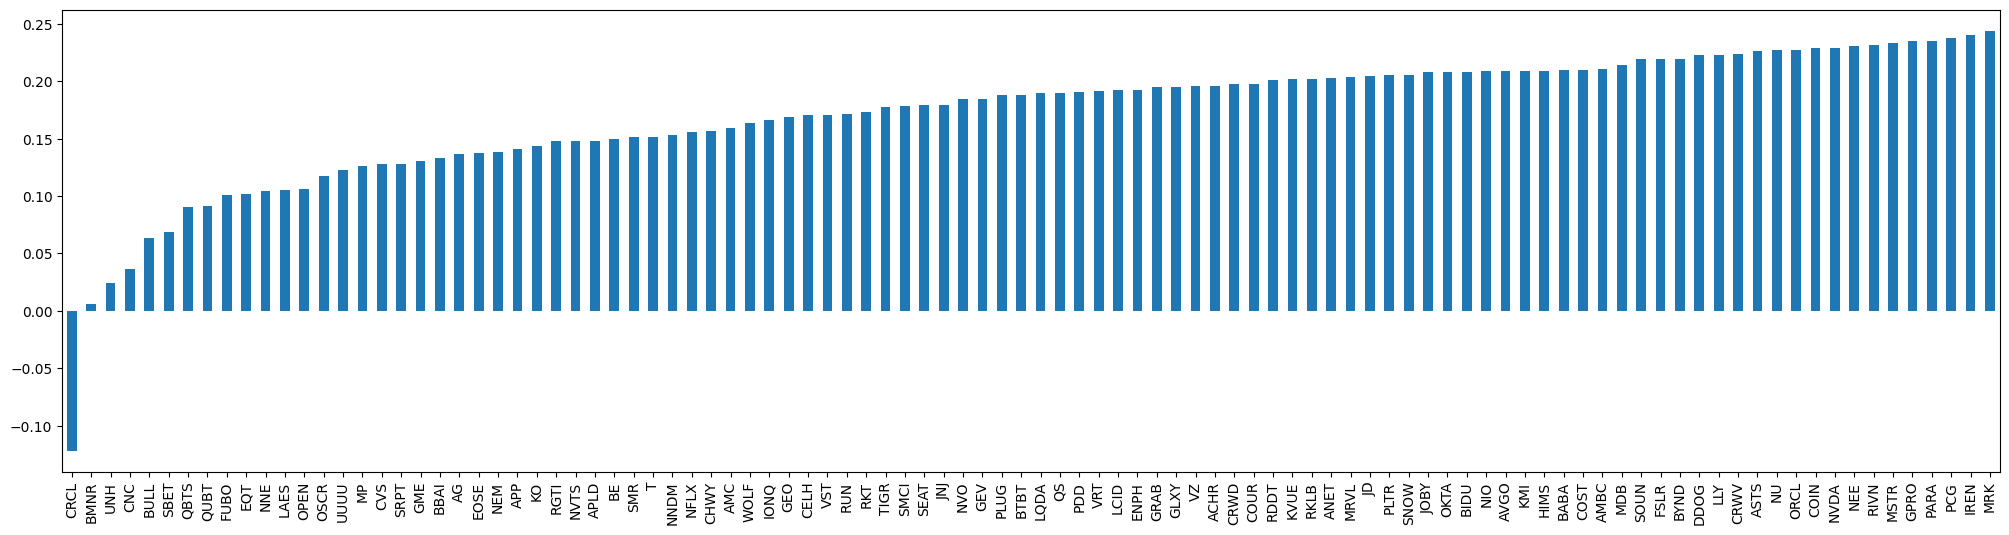

In [12]:
plt.figure(figsize=(25, 6))
seri=pd.DataFrame(active_stocks_corr).median(axis=0)#.plot.bar()#['NVDA']
seri_sorted=seri.sort_values()
seri_sorted.head(100).plot.bar()

In [13]:
seri_sorted.loc['PLTR']

0.20535381396552987

In [15]:
active_stocks_corr['EQT']

AAPL     0.172699
PYPL     0.276951
GOOGL    0.246140
QCOM     0.267377
MTCH     0.087157
DOW      0.059774
XOM      0.274636
OXY      0.281217
SLB      0.294201
TGT     -0.037719
UPS     -0.005405
NKE      0.047804
AZN      0.105596
PFE      0.059421
MRK      0.045703
JNJ     -0.055509
TMO      0.102140
UNH     -0.002691
VALE     0.130642
RIO      0.200865
JD       0.088555
KHC     -0.026908
PEP     -0.044199
DEO      0.022047
TSLA     0.266441
AVGO     0.394537
NVDA     0.483692
PLTR     0.318153
TLT     -0.028868
IEF     -0.070686
DAL      0.242998
CCL      0.314612
NEE      0.223527
VZ      -0.093801
PG      -0.028963
V        0.297851
F        0.057732
GM       0.063443
O        0.122819
dtype: float64

In [161]:
res_df=create_stock_correlation_network(all_price_sp500,120,output='df',transformation='log')#252*1
#clustered_heatmap(res_df,cmap='coolwarm')

In [162]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
from scipy.sparse.linalg import eigs
from sklearn.cluster import KMeans
from collections import defaultdict
import warnings
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
import networkx as nx
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns


def walktrap_communities(correlation_df, t=4, num_communities=None, threshold=0.0):
    """
    Walktrap community detection algorithm for fully connected correlation matrices.
    
    Parameters:
    -----------
    correlation_df : pandas.DataFrame
        Fully connected correlation matrix (n x n) as DataFrame
    t : int, default=4
        Length of random walks
    num_communities : int, optional
        Number of communities to detect. If None, automatically determined
    threshold : float, default=0.0
        Threshold for edge weights (correlations below this are set to 0)
    
    Returns:
    --------
    communities : list
        List of community assignments for each node
    modularity : float
        Modularity score of the detected communities
    """
    
    # Convert DataFrame to numpy array for computation
    correlation_matrix = correlation_df.values
    
    # Convert correlation matrix to adjacency matrix
    adj_matrix = np.abs(correlation_matrix.copy())
    
    # Apply threshold
    adj_matrix[adj_matrix < threshold] = 0
    
    # Ensure diagonal is zero (no self-loops)
    np.fill_diagonal(adj_matrix, 0)
    
    n = adj_matrix.shape[0]
    
    # Calculate transition matrix for random walks
    P = _calculate_transition_matrix(adj_matrix)
    
    # Calculate t-step transition probabilities
    P_t = np.linalg.matrix_power(P, t)
    
    # Calculate distance matrix based on random walk probabilities
    distance_matrix = _calculate_walktrap_distances(P_t)
    
    # Hierarchical clustering based on distances
    communities = _hierarchical_clustering(distance_matrix, adj_matrix, num_communities)
    
    # Calculate modularity
    modularity = _calculate_modularity(adj_matrix, communities)
    
    return communities, modularity


def _calculate_transition_matrix(adj_matrix):
    """Calculate the transition matrix for random walks."""
    # Calculate degree of each node
    degrees = np.sum(adj_matrix, axis=1)
    
    # Avoid division by zero
    degrees[degrees == 0] = 1
    
    # Create transition matrix P where P[i,j] = A[i,j] / degree[i]
    P = adj_matrix / degrees[:, np.newaxis]
    
    return P


def _calculate_walktrap_distances(P_t):
    """Calculate distances between nodes based on t-step random walk probabilities."""
    n = P_t.shape[0]
    distance_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i+1, n):
            # Calculate squared difference between probability distributions
            diff = P_t[i, :] - P_t[j, :]
            # Weight by stationary distribution (degree)
            stationary = np.sum(P_t, axis=0)
            stationary = stationary / np.sum(stationary)
            
            # Walktrap distance
            distance = np.sqrt(np.sum((diff ** 2) / (stationary + 1e-10)))
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance
    
    return distance_matrix


def _hierarchical_clustering(distance_matrix, adj_matrix, num_communities):
    """Perform hierarchical clustering based on walktrap distances."""
    n = distance_matrix.shape[0]
    
    if num_communities is None:
        # Automatically determine number of communities using modularity optimization
        best_modularity = -1
        best_communities = list(range(n))
        
        for k in range(2, min(n, 20)):  # Try different numbers of communities
            communities = _cluster_nodes(distance_matrix, k)
            modularity = _calculate_modularity(adj_matrix, communities)
            
            if modularity > best_modularity:
                best_modularity = modularity
                best_communities = communities
        
        return best_communities
    else:
        return _cluster_nodes(distance_matrix, num_communities)


def _cluster_nodes(distance_matrix, k):
    """Cluster nodes using K-means on distance matrix."""
    # Use spectral embedding for better clustering
    n = distance_matrix.shape[0]
    
    # Convert distances to similarities
    sigma = np.median(distance_matrix[distance_matrix > 0])
    similarity_matrix = np.exp(-distance_matrix ** 2 / (2 * sigma ** 2))
    
    # Spectral embedding
    try:
        # Calculate normalized Laplacian
        degrees = np.sum(similarity_matrix, axis=1)
        degrees[degrees == 0] = 1
        D_inv_sqrt = np.diag(1.0 / np.sqrt(degrees))
        L_norm = np.eye(n) - D_inv_sqrt @ similarity_matrix @ D_inv_sqrt
        
        # Find k smallest eigenvalues and eigenvectors
        eigenvals, eigenvecs = eigs(L_norm, k=k, which='SM')
        
        # Use eigenvectors as features for clustering
        features = np.real(eigenvecs)
        
        # K-means clustering
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        communities = kmeans.fit_predict(features)
        
    except:
        # Fallback to simple K-means on distance matrix
        warnings.warn("Spectral clustering failed, using simple K-means")
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        communities = kmeans.fit_predict(distance_matrix)
    
    return communities.tolist()


def _calculate_modularity(adj_matrix, communities):
    """Calculate modularity of the community structure."""
    n = len(communities)
    m = np.sum(adj_matrix) / 2  # Total number of edges
    
    if m == 0:
        return 0
    
    modularity = 0
    degrees = np.sum(adj_matrix, axis=1)
    
    for i in range(n):
        for j in range(n):
            if communities[i] == communities[j]:
                expected = (degrees[i] * degrees[j]) / (2 * m)
                modularity += adj_matrix[i, j] - expected
    
    return modularity / (2 * m)


def visualize_communities(correlation_df, communities, modularity=None, 
                         node_labels=None, figsize=(15, 12), save_path=None):
    """
    Comprehensive visualization of detected communities.
    
    Parameters:
    -----------
    correlation_df : pandas.DataFrame
        Original correlation matrix as DataFrame
    communities : list
        Community assignments for each node
    modularity : float, optional
        Modularity score to display
    node_labels : list, optional
        Labels for nodes (if None, uses DataFrame index)
    figsize : tuple, default=(15, 12)
        Figure size
    save_path : str, optional
        Path to save the figure
    """
    
    # Convert DataFrame to numpy array for computation
    correlation_matrix = correlation_df.values
    
    # Use DataFrame index names if node_labels not provided
    if node_labels is None:
        node_labels = correlation_df.index.tolist()
    
    fig = plt.figure(figsize=figsize)
    
    # Create subplots
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # 1. Network graph
    ax1 = fig.add_subplot(gs[0, :2])
    _plot_network_graph(correlation_matrix, communities, ax1, node_labels)
    
    # 2. Correlation matrix heatmap with community blocks
    ax2 = fig.add_subplot(gs[1, :2])
    _plot_correlation_heatmap(correlation_matrix, communities, ax2, node_labels)
    
    # 3. Community size distribution
    ax3 = fig.add_subplot(gs[0, 2])
    _plot_community_sizes(communities, ax3)
    
    # 4. 2D embedding of nodes
    ax4 = fig.add_subplot(gs[1, 2])
    _plot_node_embedding(correlation_matrix, communities, ax4)
    
    # 5. Modularity and statistics
    ax5 = fig.add_subplot(gs[2, :])
    _plot_community_statistics(correlation_matrix, communities, modularity, ax5)
    
    plt.suptitle(f'Walktrap Community Detection Results\n'
                f'{len(set(communities))} Communities Detected', 
                fontsize=16, fontweight='bold')
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.tight_layout()
    plt.show()
def _plot_network_graph(correlation_matrix, communities, ax, node_labels=None):
    """Plot network graph showing all correlations with contrasting colors for positive/negative correlations, 
    nodes grouped by community, and central nodes positioned in the center of each community."""
    import networkx as nx
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.colors import LinearSegmentedColormap
    
    # Create network
    G = nx.Graph()
    n = len(correlation_matrix)
    
    # Add nodes
    for i in range(n):
        G.add_node(i)
    
    # Add edges with weights based on absolute correlation values for centrality calculation
    for i in range(n):
        for j in range(i+1, n):
            weight = correlation_matrix[i, j]
            G.add_edge(i, j, weight=abs(weight))  # Use absolute value for centrality
    
    # Calculate meaningful centrality measures for correlation networks
    try:
        # Eigenvector centrality considers the importance of connected nodes
        eigenvector_centrality = nx.eigenvector_centrality(G, weight='weight', max_iter=1000)
    except:
        # Fallback to weighted degree if eigenvector fails to converge
        eigenvector_centrality = {i: sum(abs(correlation_matrix[i, :]) for i in range(n))}
    
    # Alternative: Strength centrality (sum of absolute correlations)
    strength_centrality = {}
    for i in range(n):
        strength_centrality[i] = sum(abs(correlation_matrix[i, j]) for j in range(n) if i != j)
    
    # Normalize strength centrality
    max_strength = max(strength_centrality.values())
    strength_centrality = {k: v/max_strength for k, v in strength_centrality.items()}
    
    # Use strength centrality as primary measure (more interpretable for correlations)
    centrality = strength_centrality
    
    # Create community-aware layout
    unique_communities = list(set(communities))
    community_positions = {}
    pos = {}
    
    # Layout each community separately with centrality-based positioning
    for c in unique_communities:
        # Get nodes in this community
        nodes_in_community = [i for i in range(n) if communities[i] == c]
        
        if len(nodes_in_community) == 1:
            # Single node community
            community_positions[c] = {nodes_in_community[0]: np.array([0.0, 0.0])}
        else:
            # Create subgraph for community
            subG = G.subgraph(nodes_in_community)
            
            # Use spring layout for community with centrality weights
            community_pos = nx.spring_layout(subG, k=0.8, iterations=100, seed=42)
            
            # Find the most central node in this community
            community_centralities = {node: centrality[node] for node in nodes_in_community}
            
            if len(set(community_centralities.values())) > 1:  # Check if centralities differ
                most_central_node = max(community_centralities, key=community_centralities.get)
                max_centrality = community_centralities[most_central_node]
                min_centrality = min(community_centralities.values())
                
                # Adjust positions so most central node is at community center
                center_offset = community_pos[most_central_node]
                for node in community_pos:
                    community_pos[node] -= center_offset
                    # Scale positions based on inverse centrality (less central = further from center)
                    if max_centrality > min_centrality:
                        centrality_ratio = (centrality[node] - min_centrality) / (max_centrality - min_centrality)
                        scale_factor = 1.0 - centrality_ratio * 0.6  # More central = closer to center
                        community_pos[node] *= scale_factor
            
            community_positions[c] = community_pos
    
    # Position communities in overall layout (circular arrangement)
    if len(unique_communities) == 1:
        # Single community - center it
        community_centers = {unique_communities[0]: np.array([0.0, 0.0])}
    else:
        # Multiple communities - arrange in circle
        angle_step = 2 * np.pi / len(unique_communities)
        radius = 4.0
        community_centers = {}
        for i, c in enumerate(unique_communities):
            angle = i * angle_step
            community_centers[c] = np.array([radius * np.cos(angle), radius * np.sin(angle)])
    
    # Combine community layouts with overall positioning
    for c in unique_communities:
        center = community_centers[c]
        for node, local_pos in community_positions[c].items():
            pos[node] = local_pos + center
    
    # Color nodes by community
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_communities)))
    node_colors = [colors[unique_communities.index(communities[i])] for i in range(n)]
    
    # Draw nodes with size based on centrality
    node_sizes = [200 + 400 * centrality[i] for i in range(n)]
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, 
                          node_size=node_sizes, alpha=0.8, ax=ax)
    
    # Enhanced edge drawing with contrasting colors and improved scaling
    edges = [(i, j) for i in range(n) for j in range(i+1, n)]
    weights = [correlation_matrix[i, j] for i, j in edges]
    
    # Calculate improved scaling for contrast
    abs_weights = [abs(w) for w in weights]
    max_abs_weight = max(abs_weights)
    min_abs_weight = min(abs_weights)
    
    # Enhanced width scaling with exponential curve for better contrast
    if max_abs_weight > min_abs_weight:
        normalized_weights = [(abs(w) - min_abs_weight) / (max_abs_weight - min_abs_weight) for w in weights]
        edge_widths = [0.2 + 3.0 * (nw ** 1.5) for nw in normalized_weights]  # Exponential scaling
        edge_alphas = [0.2 + 0.7 * (nw ** 0.8) for nw in normalized_weights]  # More contrast
    else:
        edge_widths = [1.5] * len(weights)
        edge_alphas = [0.5] * len(weights)
    
    # Create contrasting colormaps for positive/negative correlations
    # Negative correlations: red spectrum
    neg_colors = ['#ffeeee', '#ff6666', '#cc0000', '#800000']
    neg_cmap = LinearSegmentedColormap.from_list('negative', neg_colors)
    
    # Positive correlations: blue spectrum  
    pos_colors = ['#eeeeff', '#6666ff', '#0000cc', '#000080']
    pos_cmap = LinearSegmentedColormap.from_list('positive', pos_colors)
    
    # Draw edges with opposite colors for positive/negative correlations
    for (i, j), weight, width, alpha in zip(edges, weights, edge_widths, edge_alphas):
        # Determine color based on correlation sign and magnitude
        if weight < 0:
            color_intensity = abs(weight) / max_abs_weight
            edge_color = neg_cmap(color_intensity)
        else:
            color_intensity = weight / max_abs_weight
            edge_color = pos_cmap(color_intensity)
        
        ax.plot([pos[i][0], pos[j][0]], [pos[i][1], pos[j][1]],
                color=edge_color, alpha=alpha, linewidth=width, zorder=1)
    
    # Add labels if provided
    if node_labels:
        labels = {i: node_labels[i] for i in range(min(n, len(node_labels)))}
        nx.draw_networkx_labels(G, pos, labels, font_size=8, ax=ax)
    
    # Add legend for edge colors
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='#cc0000', lw=3, label='Negative Correlation'),
        Line2D([0], [0], color='#0000cc', lw=3, label='Positive Correlation')
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=8)
    
    ax.set_title('Community-Aware Correlation Network', fontweight='bold')
    ax.axis('off')




def _plot_correlation_heatmap(correlation_matrix, communities, ax, node_labels=None):
    """Plot correlation matrix ordered by communities."""
    # Sort nodes by community
    community_order = np.argsort(communities)
    sorted_matrix = correlation_matrix[np.ix_(community_order, community_order)]
    
    # Create heatmap
    im = ax.imshow(sorted_matrix, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
    
    # Add community boundaries
    unique_communities = sorted(set(communities))
    boundaries = []
    current_pos = 0
    
    for comm in unique_communities:
        count = communities.count(comm)
        boundaries.append(current_pos + count)
        current_pos += count
    
    # Draw community boundaries
    for boundary in boundaries[:-1]:
        ax.axhline(y=boundary-0.5, color='black', linewidth=2)
        ax.axvline(x=boundary-0.5, color='black', linewidth=2)
    
    # Add tick labels if node_labels provided
    if node_labels:
        ordered_labels = [node_labels[i] for i in community_order]
        ax.set_xticks(range(len(ordered_labels)))
        ax.set_yticks(range(len(ordered_labels)))
        ax.set_xticklabels(ordered_labels, rotation=45, ha='right')
        ax.set_yticklabels(ordered_labels)
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Correlation', rotation=270, labelpad=15)
    
    ax.set_title('Correlation Matrix (Ordered by Communities)', fontweight='bold')
    ax.set_xlabel('Nodes')
    ax.set_ylabel('Nodes')


def _plot_community_sizes(communities, ax):
    """Plot community size distribution."""
    from collections import Counter
    
    comm_counts = Counter(communities)
    sizes = list(comm_counts.values())
    
    ax.hist(sizes, bins=max(1, len(sizes)//3), alpha=0.7, color='skyblue', edgecolor='black')
    ax.set_xlabel('Community Size')
    ax.set_ylabel('Frequency')
    ax.set_title('Community Size Distribution', fontweight='bold')
    ax.grid(True, alpha=0.3)


def _plot_node_embedding(correlation_matrix, communities, ax):
    """Plot 2D embedding of nodes colored by community."""
    # Use t-SNE for dimensionality reduction
    if correlation_matrix.shape[0] > 50:
        # For large matrices, use PCA first
        pca = PCA(n_components=10)
        reduced_data = pca.fit_transform(correlation_matrix)
        embedding = TSNE(n_components=2, random_state=42, perplexity=min(30, len(correlation_matrix)-1)).fit_transform(reduced_data)
    else:
        embedding = TSNE(n_components=2, random_state=42, perplexity=min(30, len(correlation_matrix)-1)).fit_transform(correlation_matrix)
    
    # Color by community
    unique_communities = list(set(communities))
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_communities)))
    
    for i, comm in enumerate(unique_communities):
        mask = np.array(communities) == comm
        ax.scatter(embedding[mask, 0], embedding[mask, 1], 
                  c=[colors[i]], label=f'Community {comm}', alpha=0.7, s=50)
    
    ax.set_title('2D Node Embedding', fontweight='bold')
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    if len(unique_communities) <= 10:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


def _plot_community_statistics(correlation_matrix, communities, modularity, ax):
    """Plot community statistics and metrics."""
    from collections import Counter
    
    comm_counts = Counter(communities)
    unique_communities = sorted(comm_counts.keys())
    
    # Calculate intra- and inter-community correlations
    intra_corrs = []
    inter_corrs = []
    
    n = len(correlation_matrix)
    for i in range(n):
        for j in range(i+1, n):
            if communities[i] == communities[j]:
                intra_corrs.append(abs(correlation_matrix[i, j]))
            else:
                inter_corrs.append(abs(correlation_matrix[i, j]))
    
    # Create box plot
    data_to_plot = [intra_corrs, inter_corrs]
    labels = ['Intra-community', 'Inter-community']
    
    box_plot = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
    box_plot['boxes'][0].set_facecolor('lightgreen')
    box_plot['boxes'][1].set_facecolor('lightcoral')
    
    ax.set_ylabel('Absolute Correlation')
    ax.set_title('Intra- vs Inter-community Correlations', fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Add statistics text
    stats_text = f'Number of Communities: {len(unique_communities)}\n'
    stats_text += f'Largest Community: {max(comm_counts.values())} nodes\n'
    stats_text += f'Smallest Community: {min(comm_counts.values())} nodes\n'
    if modularity is not None:
        stats_text += f'Modularity: {modularity:.3f}\n'
    stats_text += f'Mean Intra-community |r|: {np.mean(intra_corrs):.3f}\n'
    stats_text += f'Mean Inter-community |r|: {np.mean(inter_corrs):.3f}'
    
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

def plot_walktrap_process(correlation_df, t_values=[1, 2, 4, 8], figsize=(8, 10)):
    """
    Visualize how community detection changes with different t values using separate plots.
    
    Parameters:
    -----------
    correlation_df : pandas.DataFrame
        Correlation matrix as DataFrame
    t_values : list, default=[1, 2, 4, 8]
        Different t values to compare
    figsize : tuple, default=(8, 10)
        Figure size for each plot
    """
    
    # Convert DataFrame to numpy array for computation
    correlation_matrix = correlation_df.values
    node_labels = correlation_df.index.tolist()
    
    results = []
    
    for t in t_values:
        # Run walktrap with different t values
        communities, modularity = walktrap_communities(correlation_df, t=t)
        results.append((communities, modularity))
        
        # Create separate figure for network graph
        fig_net, ax_net = plt.subplots(figsize=figsize)
        _plot_network_graph(correlation_matrix, communities, ax_net, node_labels)
        ax_net.set_title(f'Network Graph - t={t}, Modularity={modularity:.3f}', fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # Create separate figure for correlation heatmap
        fig_corr, ax_corr = plt.subplots(figsize=figsize)
        _plot_correlation_heatmap(correlation_matrix, communities, ax_corr, node_labels)
        ax_corr.set_title(f'Correlation Heatmap - {len(set(communities))} Communities Detected (t={t})')
        plt.tight_layout()
        plt.show()
    
    return results



def detect_communities_walktrap(correlation_df, **kwargs):
    """
    Convenience function for walktrap community detection with index name mapping.
    
    Parameters:
    -----------
    correlation_df : pandas.DataFrame
        Correlation matrix as DataFrame
    **kwargs : additional arguments for walktrap_communities
    
    Returns:
    --------
    dict with keys:
        - 'communities': list of community assignments
        - 'community_mapping': dict mapping index names to communities
        - 'modularity': modularity score
        - 'num_communities': number of detected communities
        - 'index_names': list of index names
    """
    communities, modularity = walktrap_communities(correlation_df, **kwargs)
    
    # Create mapping from index names to communities
    index_names = correlation_df.index.tolist()
    community_mapping = {index_names[i]: communities[i] for i in range(len(communities))}
    
    return {
        'communities': communities,
        'community_mapping': community_mapping,
        'modularity': modularity,
        'num_communities': len(set(communities)),
        'index_names': index_names
    }


# Example usage and testing
if __name__ == "__main__":
    # Generate a test correlation matrix with community structure
    np.random.seed(42)
    n = 50
    
    # Create block correlation matrix
    corr_matrix = np.random.rand(n, n) * 0.3
    
    # Add strong correlations within communities
    block_size = 10
    for i in range(0, n, block_size):
        end_i = min(i + block_size, n)
        for j in range(i, end_i):
            for k in range(i, end_i):
                if j != k:
                    corr_matrix[j, k] = 0.8 + np.random.rand() * 0.2
    
    # Make symmetric
    corr_matrix = (corr_matrix + corr_matrix.T) / 2
    np.fill_diagonal(corr_matrix, 1.0)
    
    # Convert to DataFrame with meaningful index names
    stock_names = [f'Stock_{chr(65 + i//26)}{i%26 + 1}' for i in range(n)]
    correlation_df = pd.DataFrame(corr_matrix, 
                                 columns=stock_names,
                                 index=stock_names)
    
    # Detect communities
    result = detect_communities_walktrap(correlation_df, t=4)
    
    print(f"Detected {result['num_communities']} communities")
    print(f"Modularity: {result['modularity']:.3f}")
    print(f"Community assignments: {list(result['community_mapping'].items())[:10]}...")  # Show first 10
    
    # Show community mapping for first few stocks
    print("\nFirst 10 stock community assignments:")
    for stock, comm in list(result['community_mapping'].items())[:10]:
        print(f"{stock}: Community {comm}")


Detected 5 communities
Modularity: 0.376
Community assignments: [('Stock_A1', 2), ('Stock_A2', 2), ('Stock_A3', 2), ('Stock_A4', 2), ('Stock_A5', 2), ('Stock_A6', 2), ('Stock_A7', 2), ('Stock_A8', 2), ('Stock_A9', 2), ('Stock_A10', 2)]...

First 10 stock community assignments:
Stock_A1: Community 2
Stock_A2: Community 2
Stock_A3: Community 2
Stock_A4: Community 2
Stock_A5: Community 2
Stock_A6: Community 2
Stock_A7: Community 2
Stock_A8: Community 2
Stock_A9: Community 2
Stock_A10: Community 2


<Axes: >

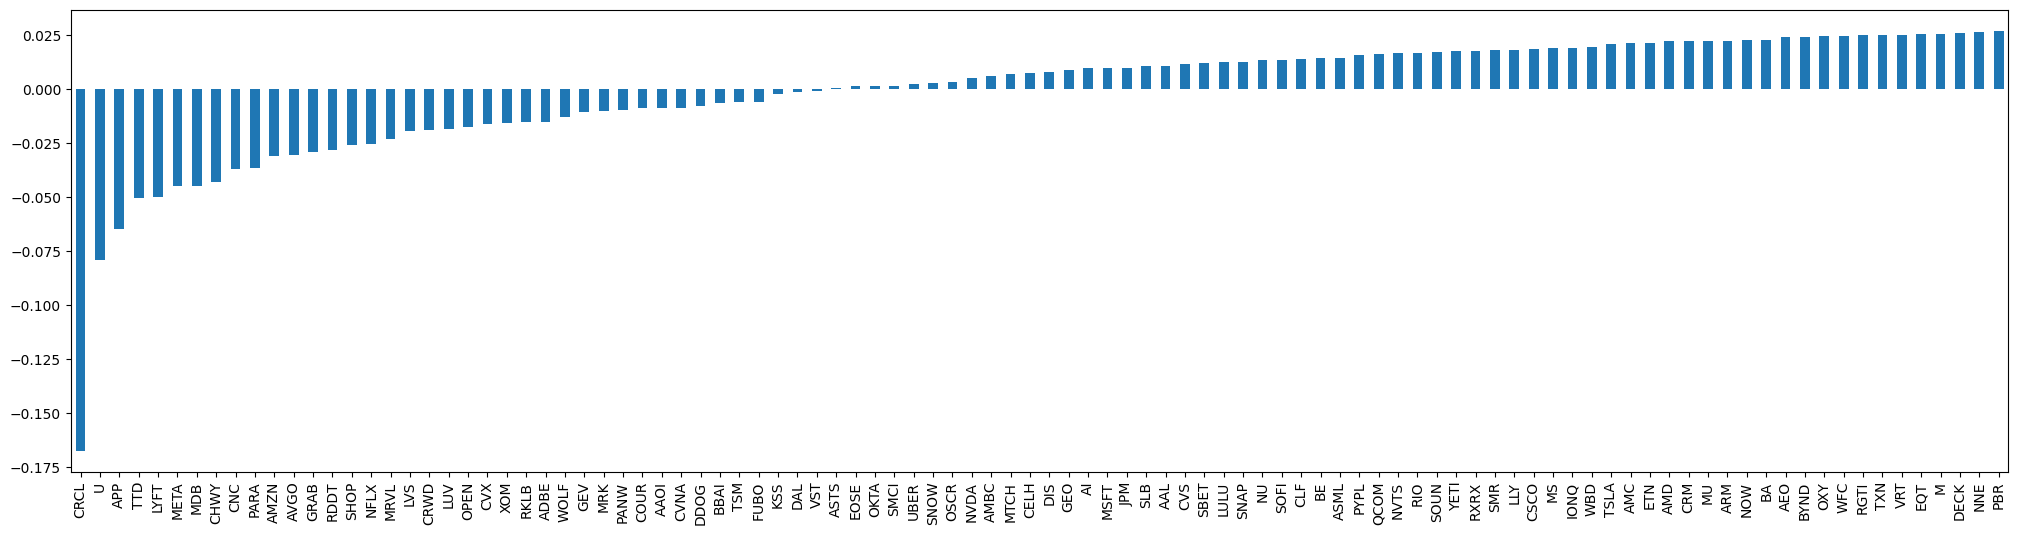

In [127]:



plt.figure(figsize=(25, 6))
seri=res_df['BULL']
seri_sorted=seri.sort_values()
seri_sorted.head(100).plot.bar()

In [109]:
seri.shape

(213,)

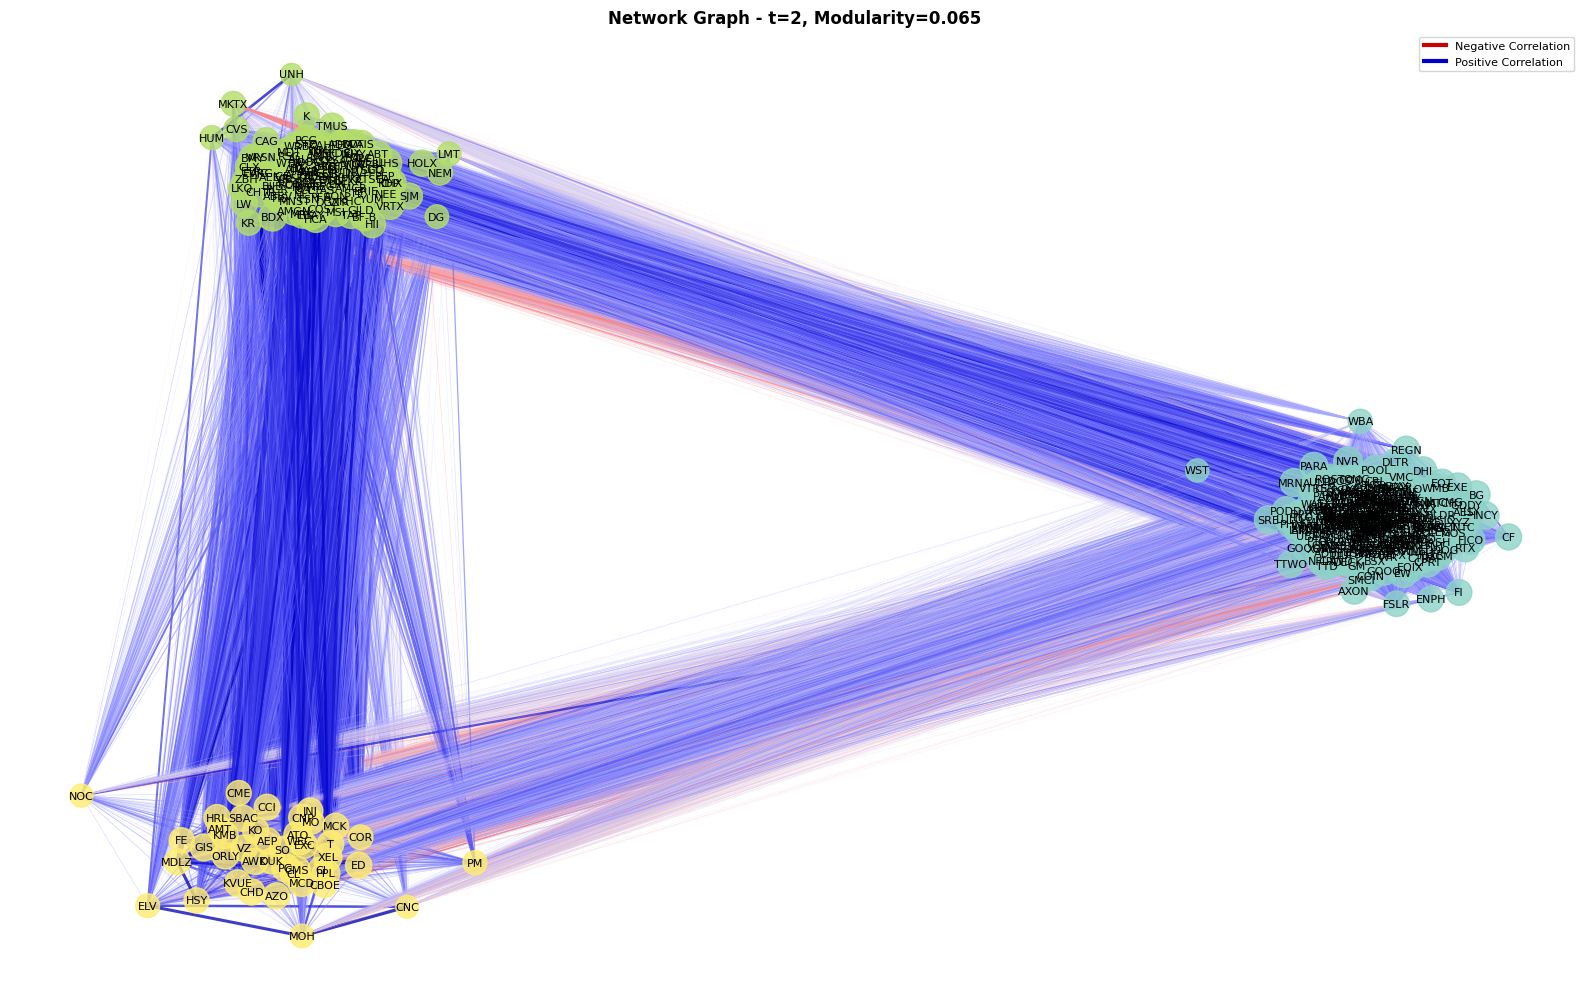

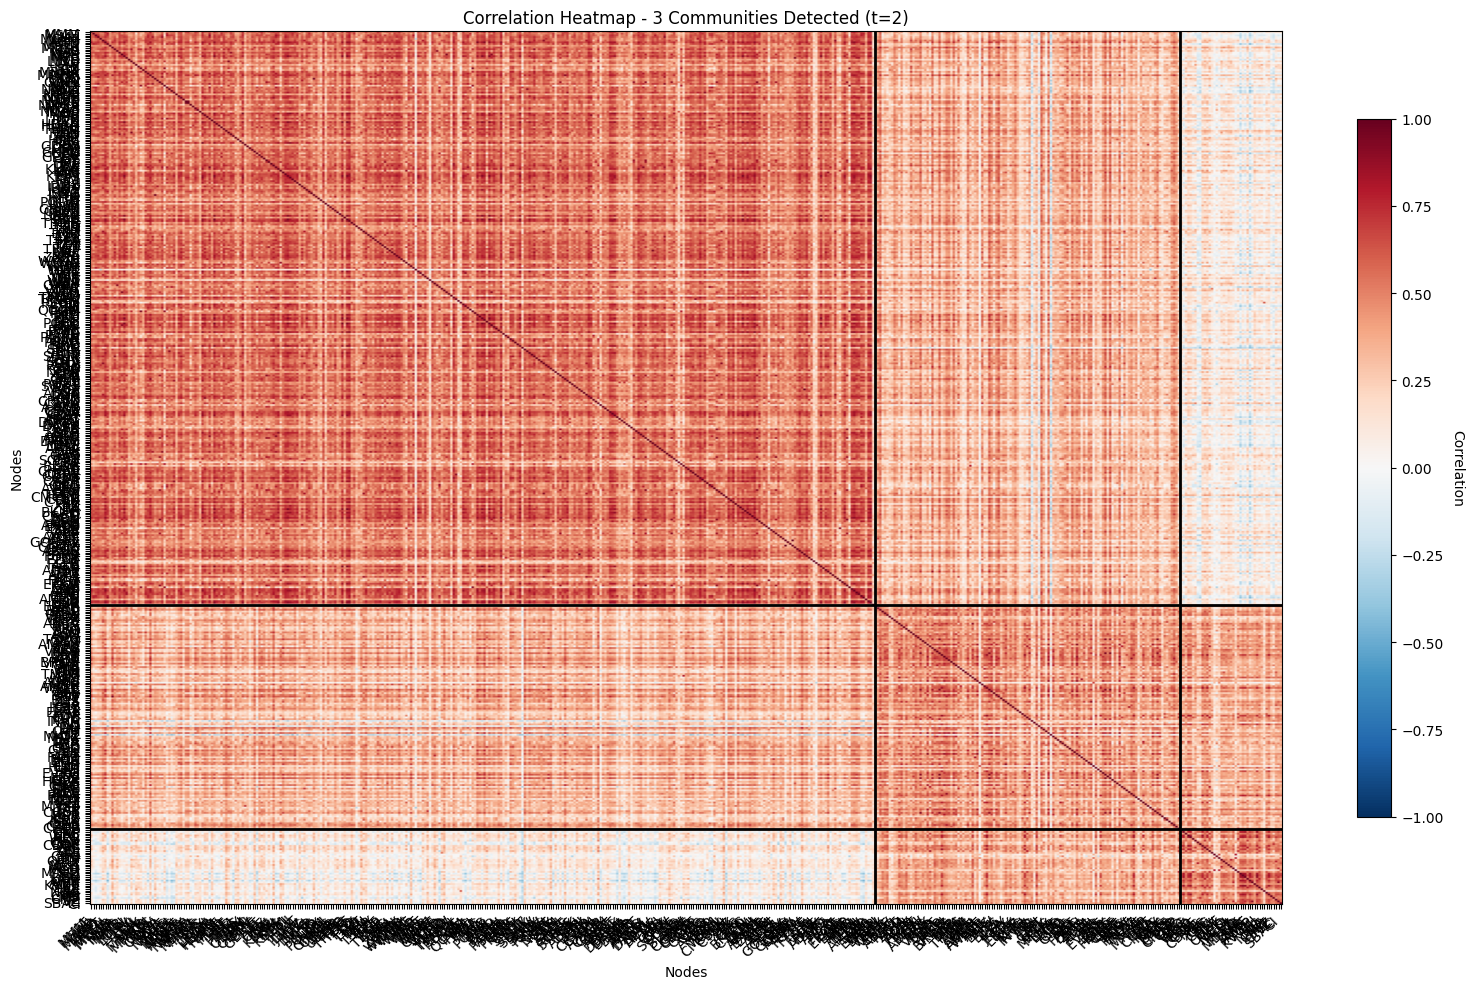

In [163]:
results=plot_walktrap_process(res_df, t_values=[2], figsize=(16, 10))

In [152]:
r=pd.Series(results[0][0],index=res_df.index)#.value_counts().sort_index().plot.bar(figsize=(16, 6), title='Community Sizes for t=2')

In [153]:
r.value_counts()

0    314
2    131
1     58
Name: count, dtype: int64

In [9]:
del all_price['TLT']
del all_price['IEF']

In [21]:
res_df.loc['PLTR',].sort_values()

MRK     -0.087102
JNJ     -0.047842
PEP     -0.037524
KHC     -0.011898
PG      -0.002417
UNH      0.006556
VZ       0.031901
AZN      0.059595
IEF      0.061387
TLT      0.071253
NEE      0.084914
DEO      0.101633
PFE      0.115344
XOM      0.124281
O        0.131341
VALE     0.166252
SLB      0.171498
RIO      0.178038
TGT      0.184114
OXY      0.189473
NKE      0.198601
TMO      0.203568
JD       0.211262
UPS      0.224215
DOW      0.225825
BRK-B    0.251896
MTCH     0.273067
PYPL     0.274319
F        0.279916
GM       0.300629
V        0.313443
GOOGL    0.337850
DAL      0.338061
AAPL     0.350998
QCOM     0.374873
CCL      0.375778
AVGO     0.388560
NVDA     0.430699
TSLA     0.442496
PLTR     1.000000
Name: PLTR, dtype: float64

(<seaborn.matrix.ClusterGrid at 0x177e0cc90>,
             TLT       IEF       UNH        PG       KHC       PEP       MRK  \
 TLT    1.000000  0.913691  0.000612  0.155933  0.165297  0.183659  0.089328   
 IEF    0.913691  1.000000 -0.004398  0.161412  0.148016  0.179124  0.071655   
 UNH    0.000612 -0.004398  1.000000  0.126067  0.142315  0.155743  0.172078   
 PG     0.155933  0.161412  0.126067  1.000000  0.417136  0.595242  0.396194   
 KHC    0.165297  0.148016  0.142315  0.417136  1.000000  0.603979  0.321496   
 PEP    0.183659  0.179124  0.155743  0.595242  0.603979  1.000000  0.380828   
 MRK    0.089328  0.071655  0.172078  0.396194  0.321496  0.380828  1.000000   
 JNJ    0.131845  0.153527  0.171739  0.404381  0.339480  0.409334  0.424932   
 DEO    0.159662  0.168722  0.078650  0.373428  0.348474  0.385062  0.277396   
 AZN    0.183329  0.208817  0.109043  0.329542  0.258325  0.298846  0.410439   
 PFE    0.106985  0.101296  0.142097  0.254071  0.269977  0.301729  0.3920

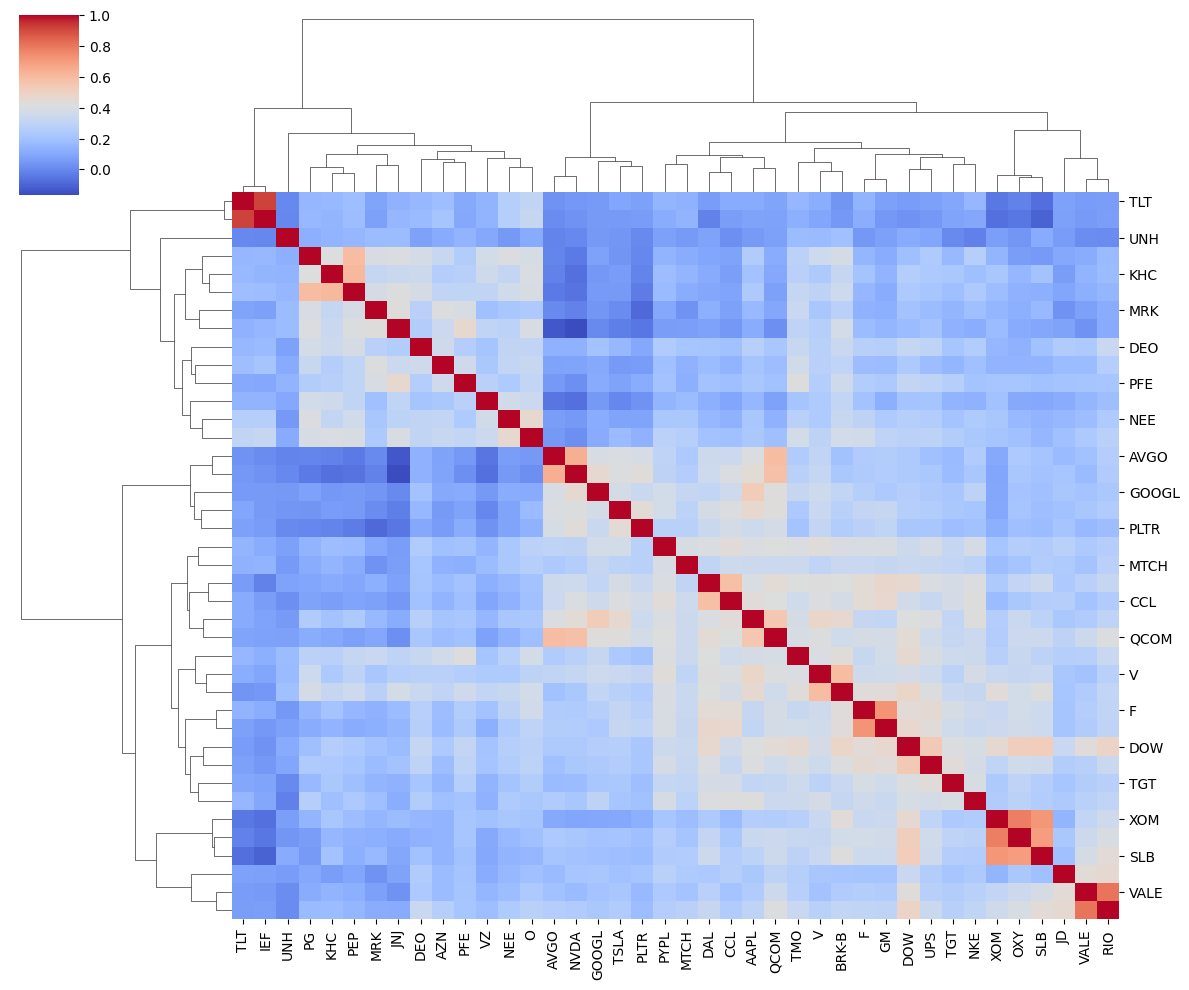

In [20]:
#{**all_price, **all_price_active}
res_df=create_stock_correlation_network(all_price,252*3,output='df',transformation='log')
clustered_heatmap(res_df,cmap='coolwarm')





(<seaborn.matrix.ClusterGrid at 0x14dc92dd0>,
             TLT       IEF       UNH       MRK       JNJ       AZN       PFE  \
 TLT    1.000000  0.908780 -0.000909  0.033988  0.048361  0.107504  0.087781   
 IEF    0.908780  1.000000  0.008390  0.035219  0.091245  0.127770  0.095993   
 UNH   -0.000909  0.008390  1.000000  0.213241  0.267417  0.178256  0.192650   
 MRK    0.033988  0.035219  0.213241  1.000000  0.421836  0.396761  0.344205   
 JNJ    0.048361  0.091245  0.267417  0.421836  1.000000  0.350634  0.441620   
 AZN    0.107504  0.127770  0.178256  0.396761  0.350634  1.000000  0.346477   
 PFE    0.087781  0.095993  0.192650  0.344205  0.441620  0.346477  1.000000   
 DEO    0.069818  0.097674  0.170674  0.252032  0.292667  0.346322  0.246876   
 NEE    0.214677  0.238523  0.125144  0.183641  0.301152  0.254238  0.207230   
 O      0.200047  0.237577  0.179277  0.220558  0.369074  0.260776  0.255990   
 VZ     0.082368  0.095046  0.171986  0.225049  0.319403  0.217334  0.2582

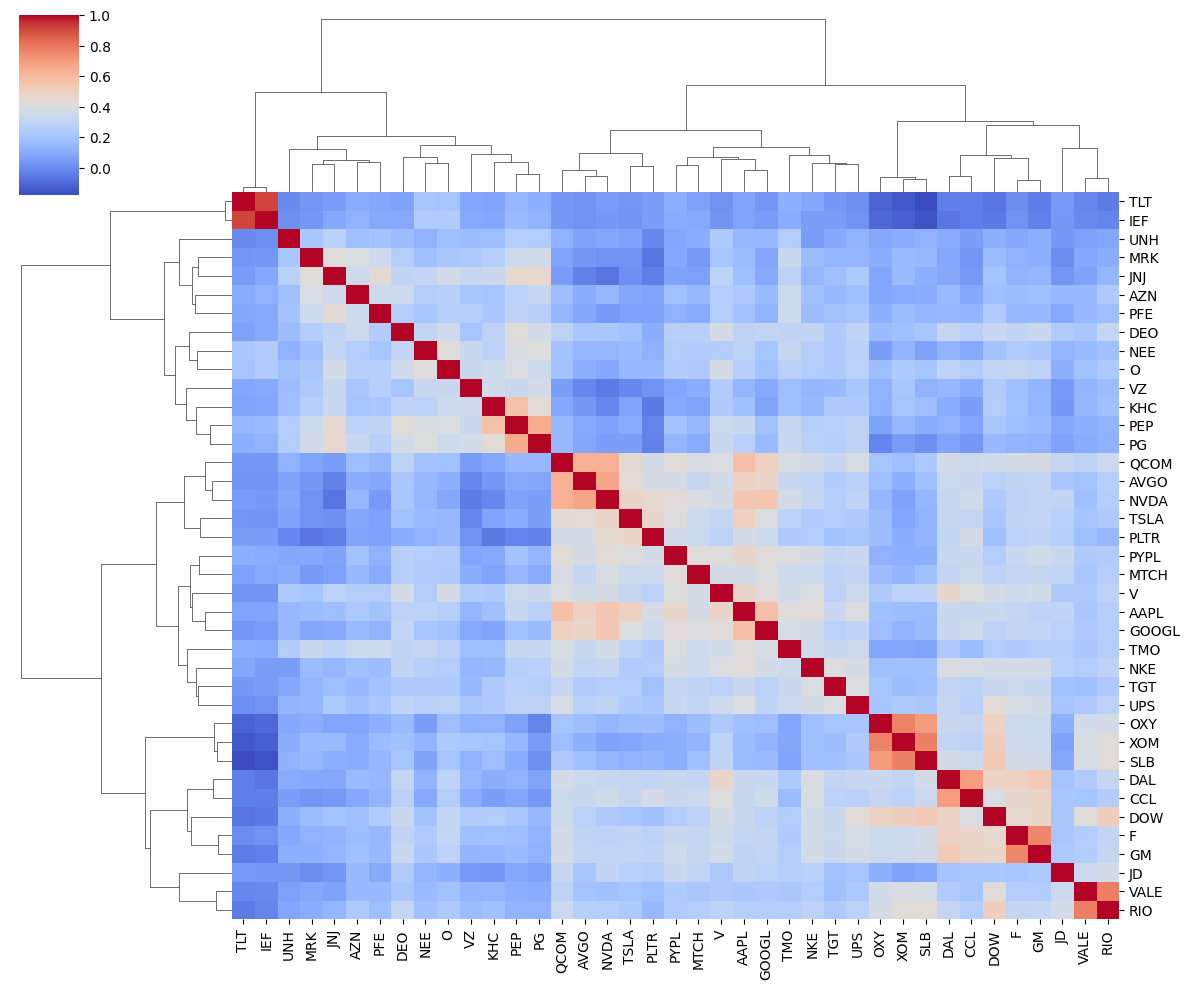

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter

# Generate sample data
x = np.linspace(0, 4*np.pi, 100)
y = np.sin(x)

# Setup figure and axis
fig, ax = plt.subplots(figsize=(8,4))
line, = ax.plot([], [], lw=2)
ax.set_xlim(0, 4*np.pi)
ax.set_ylim(-1.1, 1.1)

# Animation functions
def init():
    line.set_data([], [])
    return line,

def update(frame):
    line.set_data(x[:frame], y[:frame])
    return line,

# Create animation
ani = FuncAnimation(fig, update, frames=len(x)+1,
                    init_func=init, blit=True,
                    interval=50)

# Save as MP4 video
writer = FFMpegWriter(fps=15, bitrate=1800)
ani.save("animation.mp4", writer=writer)
plt.close()


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter

# Generate static x-values (0 to 4π with 500 points)
x = np.linspace(0, 4*np.pi, 500)
t_values = np.linspace(0.1, 2, 200)  # Time parameter evolution

# Configure plot
fig, ax = plt.subplots(figsize=(10, 4))
line, = ax.plot([], [], lw=2, color='crimson')
ax.set_xlim(0, 4*np.pi)
ax.set_ylim(-1.1, 1.1)
ax.grid(alpha=0.4)

# Animation functions
def init():
    line.set_data([], [])
    return line,

def update(t):
    y = np.sin(x * t)  # Core equation y = sin(xt)
    line.set_data(x, y)
    ax.set_title(f'y = sin(xt) | t = {t:.2f}', fontsize=12)
    return line,

# Create animation
ani = FuncAnimation(fig, update, frames=t_values,
                    init_func=init, blit=True, interval=50)

# Save as video (requires FFmpeg)
writer = FFMpegWriter(fps=20, bitrate=2000)
ani.save("sine_evolution.mp4", writer=writer)
plt.close()


NameError: name 'downloader' is not defined

In [82]:
plot_network_and_heatmap(all_price,200)

Error: create_stock_correlation_network function not available


(None, None)

In [80]:
analyze_correlation_network(res,top_n=10)

{'num_nodes': 29,
 'num_edges': 406,
 'avg_correlation': np.float64(0.31968025438490366),
 'max_correlation': np.float64(0.9412442671096187),
 'min_correlation': np.float64(-0.8017368691514044),
 'top_correlations': [{'stocks': ('DOW', 'MRK'),
   'correlation': np.float64(0.9412442671096187)},
  {'stocks': ('DOW', 'TGT'), 'correlation': np.float64(0.9331598847811812)},
  {'stocks': ('DOW', 'PEP'), 'correlation': np.float64(0.9285619873561776)},
  {'stocks': ('PEP', 'MRK'), 'correlation': np.float64(0.9165853969994254)},
  {'stocks': ('DOW', 'PFE'), 'correlation': np.float64(0.8986140756135339)},
  {'stocks': ('DOW', 'NKE'), 'correlation': np.float64(0.8969778554075569)},
  {'stocks': ('PFE', 'MRK'), 'correlation': np.float64(0.888137615669571)},
  {'stocks': ('TGT', 'UPS'), 'correlation': np.float64(0.8880850861893352)},
  {'stocks': ('DOW', 'OXY'), 'correlation': np.float64(0.883548736338841)},
  {'stocks': ('OXY', 'SLB'), 'correlation': np.float64(0.8832685392449435)}]}

In [32]:
# def download_and_calculate_volatility(symbol, start_date, end_date, window=20):
#     """
#     Enhanced function to calculate both volatility measures
#     """
#     print(f"Downloading data for {symbol}...")
#     data = yf.download(symbol, start=start_date, end=end_date)
    
#     # Calculate both volatility measures
#     data['GK_Volatility'] = garman_klass_volatility(data, window)
#     data['YZ_Volatility'] = yang_zhang_volatility(data, window)
    
    # return data
def plot_volatility_comparison(data, symbol):
    """
    Enhanced visualization with both volatility measures and current values
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Price plot
    ax1.plot(data.index, data['Close'], label='Closing Price')
    ax1.set_title(f'{symbol} - Price and Volatility Comparison')
    ax1.set_ylabel('Price ($)')
    ax1.grid(True)
    
    # Get the latest volatility values
    latest_gk = data['GK_Volatility'].iloc[-1]
    latest_yz = data['YZ_Volatility'].iloc[-1]
    
    # Volatility comparison plot
    ax2.plot(data.index, data['GK_Volatility'], 
             label=f'Garman-Klass (Current: {latest_gk:.2%})', color='blue',alpha=0.5)
    ax2.plot(data.index, data['YZ_Volatility'], 
             label=f'Yang-Zhang (Current: {latest_yz:.2%})', color='red',alpha=0.3)
    ax2.axhline(y=latest_gk, color='blue', linestyle='--', alpha=1)
    ax2.axhline(y=latest_yz, color='red', linestyle='--', alpha=1)
    # Add text annotation with current values
    # ax2.text(0.02, 0.98, f'Latest Volatility:\nGK: {latest_gk:.2%}\nYZ: {latest_yz:.2%}', 
    #          transform=ax2.transAxes, verticalalignment='top',
    #          bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    ax2.set_title('Volatility Comparison')
    ax2.set_ylabel('Annualized Volatility')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# # Example usage
# if __name__ == "__main__":
#     # Parameters
#     symbol = 'AAPL'
#     start_date = '2019-01-01'
#     end_date = '2025-05-22' 
#     window = 20
    
#     # Download data and calculate volatility
#     stock_data = download_and_calculate_gk_volatility(symbol, start_date, end_date, window)
    
#     # Display results
#     print(f"\nGarman-Klass Volatility for {symbol}:")
#     print("=" * 50)
#     print(stock_data[['Close', 'GK_Volatility']].tail(10))
    
#     # Calculate summary statistics
#     avg_volatility = stock_data['GK_Volatility'].mean()
#     min_volatility = stock_data['GK_Volatility'].min()
#     max_volatility = stock_data['GK_Volatility'].max()
    
#     print(f"\nSummary Statistics:")
#     print(f"Average Volatility: {avg_volatility:.4f}")
#     print(f"Minimum Volatility: {min_volatility:.4f}")
#     print(f"Maximum Volatility: {max_volatility:.4f}")
    
#     # Plot the results
#     plot_volatility(stock_data, symbol)
    
#     # Compare multiple stocks
#     symbols = ['AAPL', 'GOOGL', 'MSFT', 'TSLA']
#     comparison_data = {}
    
#     print(f"\nComparing Garman-Klass Volatility across stocks:")
#     print("=" * 60)
    
#     for stock in symbols:
#         try:
#             data = download_and_calculate_gk_volatility(stock, start_date, end_date, window)
#             latest_vol = data['GK_Volatility'].iloc[-1]
#             avg_vol = data['GK_Volatility'].mean()
#             comparison_data[stock] = {'Latest': latest_vol, 'Average': avg_vol}
#             print(f"{stock}: Latest = {latest_vol:.4f}, Average = {avg_vol:.4f}")
#         except Exception as e:
#             print(f"Error processing {stock}: {e}")
    
#     # Create comparison DataFrame
#     comparison_df = pd.DataFrame(comparison_data).T
#     print(f"\nVolatility Comparison:")
#     print(comparison_df.round(4))


In [3]:
ref_FOC = FOC()

In [9]:
def example_result_callback(result):
    print("Result from target function:", result)

In [12]:
def example_result_callback(result,ls):
    ls.append(result)
    raise Exception('stop')

In [21]:
ls=[]
ref_FOC.create_quote_stream_options_price_data(20,'AMC---250530C00003000',result_callback=lambda x:example_result_callback(x,ls))


Exception in thread Thread-54 (_run):
Traceback (most recent call last):
  File "/Users/williamxu/anaconda3/lib/python3.11/site-packages/FOC/main.py", line 116, in json_extract_node
    json_data = json_data[key]
                ~~~~~~~~~^^^^^
TypeError: 'NoneType' object is not subscriptable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/williamxu/anaconda3/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/Users/williamxu/anaconda3/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/Users/williamxu/anaconda3/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/williamxu/anaconda3/lib/python3.11/site-packages/FOC/intervalrunner.py", line 23, in _run
    result = self.target_func(*self.func_args)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/wil

In [23]:
ls=[]
ref_FOC.create_quote_stream_options_price_data(20,'AAPL--250530C00200000',result_callback=lambda x:example_result_callback(x,ls))


Exception in thread Thread-55 (_run):
Traceback (most recent call last):
  File "/Users/williamxu/anaconda3/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/Users/williamxu/anaconda3/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/Users/williamxu/anaconda3/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/williamxu/anaconda3/lib/python3.11/site-packages/FOC/intervalrunner.py", line 25, in _run
    self.result_callback(result)
  File "/var/folders/_q/zvg1j91x7sx_8_rt3f62v0ph0000gn/T/ipykernel_81809/2323725644.py", line 2, in <lambda>
  File "/var/folders/_q/zvg1j91x7sx_8_rt3f62v0ph0000gn/T/ipykernel_81809/3823222416.py", line 3, in example_result_callback
Exception: stop


In [24]:
ls[0]

label                 Last Sale    Net Day High Day Low Volume Prev Close  \
AAPL--250530C00200000                                                       
value                      1.62  -2.68     2.64    1.41  25575        4.3   

label                  Open Open Interest Tick  Bid  ... Contract Low Market  \
AAPL--250530C00200000                                ...                       
value                  1.53          3540       1.6  ...         1.41  OPRAC   

label                    Delta    Gamma      Rho     Theta     Vega   Impvol  \
AAPL--250530C00200000                                                          
value                  0.30546  0.04101  0.01112  -0.21995  0.09476  0.31613   

label                            timestamp        contract_symbol  
AAPL--250530C00200000                                              
value                  2025-05-25 15:42:00  AAPL--250530C00200000  

[1 rows x 24 columns]

In [26]:
ls=[]
ref_FOC.create_quote_stream_options_price_data(20,'TSLA--250530C00440000',result_callback=lambda x:example_result_callback(x,ls))


Exception in thread Thread-57 (_run):
Traceback (most recent call last):
  File "/Users/williamxu/anaconda3/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/Users/williamxu/anaconda3/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/Users/williamxu/anaconda3/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/williamxu/anaconda3/lib/python3.11/site-packages/FOC/intervalrunner.py", line 25, in _run
    self.result_callback(result)
  File "/var/folders/_q/zvg1j91x7sx_8_rt3f62v0ph0000gn/T/ipykernel_81809/1577127683.py", line 2, in <lambda>
  File "/var/folders/_q/zvg1j91x7sx_8_rt3f62v0ph0000gn/T/ipykernel_81809/3823222416.py", line 3, in example_result_callback
Exception: stop


In [41]:
ls[0]

price  nlsShareVolume   nlsTime   nlsVolume previousClose todayHighLow  \
0  195.27           850.0  16:00:00  78,432,918       $201.36            /   

  fiftyTwoWeekHighLow  
0    $260.1/$169.2101

In [39]:
ls=[]
ref_FOC.create_quote_stream_stock_price(20,'AAPL',last_n_price = 50,result_callback=lambda x:example_result_callback(x,ls))


Exception in thread Thread-74 (_run):
Traceback (most recent call last):
  File "/Users/williamxu/anaconda3/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/Users/williamxu/anaconda3/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/Users/williamxu/anaconda3/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/williamxu/anaconda3/lib/python3.11/site-packages/FOC/intervalrunner.py", line 25, in _run
    self.result_callback(result)
  File "/var/folders/_q/zvg1j91x7sx_8_rt3f62v0ph0000gn/T/ipykernel_81809/625373052.py", line 2, in <lambda>
  File "/var/folders/_q/zvg1j91x7sx_8_rt3f62v0ph0000gn/T/ipykernel_81809/3823222416.py", line 3, in example_result_callback
Exception: stop


In [28]:
ref_FOC = FOC()

# Options Chain of AAPL CALL options for 6 October 2023
options_chain = ref_FOC.get_options_chain("AAPL","2023-10-06",OptionType.CALL)

TypeError: FOC.get_options_chain() missing 2 required positional arguments: 'expiration_date' and 'option_type'

Processing data request for TGT from 2007-01-03 to 2025-06-18...
Found cached data for TGT (last updated: 2025-06-20 16:00:07)
All requested data for TGT available in cache!


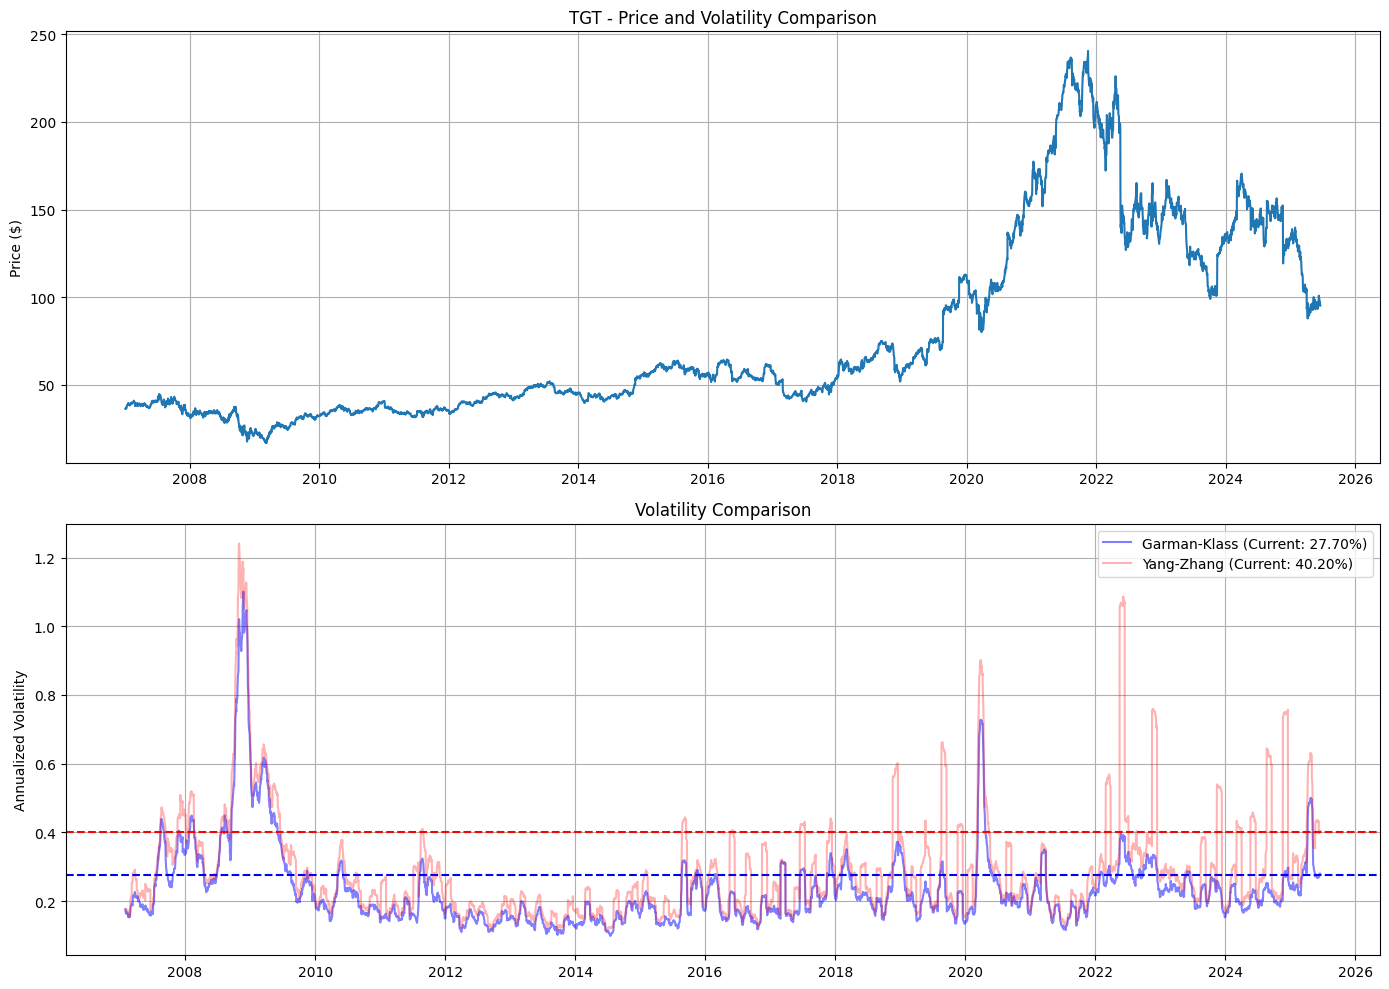

TGT: YZ-pval: 0.149,  GK-pval: 0.206


/var/folders/_q/zvg1j91x7sx_8_rt3f62v0ph0000gn/T/ipykernel_16333/2872722370.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  latest_pval=lambda s: larger_proportion(s.dropna(),s[-1])


In [35]:
stock='TGT'
res_dict=dict()
window=20
p_val=dict()
try:
    data =  downloader(stock, start_date,end_date)
    data['GK_Volatility'] = garman_klass_volatility(data, window)
    data['YZ_Volatility'] = yang_zhang_volatility(data, window)
    plot_volatility_comparison(data, stock)
    #larger_proportion(res_dict[stock]['YZ_Volatility'].dropna(),0.5)
    # comparison_data[stock] = {
    #     'GK_Mean': data['GK_Volatility'].mean(),
    #     'YZ_Mean': data['YZ_Volatility'].mean(),
    #     'Volatility_Ratio': data['YZ_Volatility'].mean() / data['GK_Volatility'].mean()
    # }
    res_dict[stock]=data
except Exception as e:
    print(f"Error processing {stock}: {e}")

for stock,data in res_dict.items():
    p_val[stock]={"YZ-pval":latest_pval(data['YZ_Volatility']),"GK-pval":latest_pval(data['GK_Volatility'])}
    print('{}: YZ-pval: {:.3f},  GK-pval: {:.3f}'.format(stock,p_val[stock]["YZ-pval"], p_val[stock]["GK-pval"]))

In [ ]:
cached = list_cached_symbols()
for info in cached:
    print(f"Symbol: {info['symbol']}")
    print(f"  Date Range: {info['date_range']}")
    print(f"  Records: {info['records']}")
    print(f"  Last Updated: {info['last_update']}")
    print(f"  File Size: {info['file_size']}")

Symbol: AAPL
  Date Range: 2022-01-03 to 2024-01-30
  Records: 521
  Last Updated: 2025-05-30 16:36:41.351814
  File Size: 25.8 KB


In [175]:
data2 = downloader("AAPL", "2023-06-01", "2025-05-31")

Processing data request for AAPL from 2023-06-01 to 2025-05-31...
Found cached data for AAPL (last updated: 2025-05-31 20:01:03)
Fetching missing data for AAPL: 2025-05-30 to 2025-05-31


[*********************100%***********************]  1 of 1 completed

Data download complete for AAPL. Shape: (501, 5)


In [12]:
# In main execution block
#stock_data = download_and_calculate_volatility(symbol, start_date, end_date)
#stock='DAL'#'603299.SS'
# Enhanced multi-stock comparison
#symbols = [stock]#['603100.SS']#['9979.HK']#['TSLA','AVGO']#['PEP','MRK','BMY','TSLA']#['PFE','DAL','OXY']#['AAPL', 'GOOGL', 'MSFT', 'TSLA']
comparison_data = {}

window = 20
res_dict=dict()
p_val=dict()



for stock in symbols:
    try:
        data =  downloader(stock, start_date,end_date)
        data['GK_Volatility'] = garman_klass_volatility(data, window)
        data['YZ_Volatility'] = yang_zhang_volatility(data, window)
        #plot_volatility_comparison(data, stock)
        #larger_proportion(res_dict[stock]['YZ_Volatility'].dropna(),0.5)
        # comparison_data[stock] = {
        #     'GK_Mean': data['GK_Volatility'].mean(),
        #     'YZ_Mean': data['YZ_Volatility'].mean(),
        #     'Volatility_Ratio': data['YZ_Volatility'].mean() / data['GK_Volatility'].mean()
        # }
        res_dict[stock]=data
    except Exception as e:
        print(f"Error processing {stock}: {e}")

for stock,data in res_dict.items():
    p_val[stock]={"YZ-pval":latest_pval(data['YZ_Volatility']),"GK-pval":latest_pval(data['GK_Volatility'])}
    print('{}: YZ-pval: {:.3f},  GK-pval: {:.3f}'.format(stock,p_val[stock]["YZ-pval"], p_val[stock]["GK-pval"]))
# comparison_df = pd.DataFrame(comparison_data).T
# print("\nMulti-Stock Volatility Analysis:")
# print(comparison_df.round(4))


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2007-01-02)')


Processing data request for AAPL from 2007-01-01 to 2025-06-03...
Found cached data for AAPL (last updated: 2025-06-02 09:55:43)
Fetching missing data for AAPL: 2007-01-01 to 2007-01-02
Fetching missing data for AAPL: 2025-05-31 to 2025-06-03


[*********************100%***********************]  1 of 1 completed


Data download complete for AAPL. Shape: (4633, 5)
Processing data request for PYPL from 2007-01-01 to 2025-06-03...
Found cached data for PYPL (last updated: 2025-06-02 14:57:55)
Fetching missing data for PYPL: 2007-01-01 to 2015-07-05


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PYPL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2015-07-05) (Yahoo error = "Data doesn\'t exist for startDate = 1167627600, endDate = 1436068800")')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GOOGL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2007-01-02)')


Fetching missing data for PYPL: 2025-05-31 to 2025-06-03
Data download complete for PYPL. Shape: (2493, 5)
Processing data request for GOOGL from 2007-01-01 to 2025-06-03...
Found cached data for GOOGL (last updated: 2025-06-02 09:55:44)
Fetching missing data for GOOGL: 2007-01-01 to 2007-01-02
Fetching missing data for GOOGL: 2025-05-31 to 2025-06-03


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['QCOM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2007-01-02)')


Data download complete for GOOGL. Shape: (4633, 5)
Processing data request for QCOM from 2007-01-01 to 2025-06-03...
Found cached data for QCOM (last updated: 2025-06-02 09:55:44)
Fetching missing data for QCOM: 2007-01-01 to 2007-01-02
Fetching missing data for QCOM: 2025-05-31 to 2025-06-03


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MTCH']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2007-01-02)')


Data download complete for QCOM. Shape: (4633, 5)
Processing data request for MTCH from 2007-01-01 to 2025-06-03...
Found cached data for MTCH (last updated: 2025-06-02 09:55:44)
Fetching missing data for MTCH: 2007-01-01 to 2007-01-02
Fetching missing data for MTCH: 2025-05-31 to 2025-06-03


[*********************100%***********************]  1 of 1 completed


Data download complete for MTCH. Shape: (4633, 5)
Processing data request for DOW from 2007-01-01 to 2025-06-03...
Found cached data for DOW (last updated: 2025-06-02 09:55:44)
Fetching missing data for DOW: 2007-01-01 to 2019-03-19


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DOW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2019-03-19) (Yahoo error = "Data doesn\'t exist for startDate = 1167627600, endDate = 1552968000")')
[*********************100%***********************]  1 of 1 completed


Fetching missing data for DOW: 2025-05-31 to 2025-06-03
Data download complete for DOW. Shape: (1560, 5)
Processing data request for XOM from 2007-01-01 to 2025-06-03...
Found cached data for XOM (last updated: 2025-06-02 09:55:45)
Fetching missing data for XOM: 2007-01-01 to 2007-01-02


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['XOM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2007-01-02)')


Fetching missing data for XOM: 2025-05-31 to 2025-06-03


[*********************100%***********************]  1 of 1 completed


Data download complete for XOM. Shape: (4633, 5)
Processing data request for OXY from 2007-01-01 to 2025-06-03...
Found cached data for OXY (last updated: 2025-06-02 09:55:45)
Fetching missing data for OXY: 2007-01-01 to 2007-01-02


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['OXY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2007-01-02)')
[*********************100%***********************]  1 of 1 completed


Fetching missing data for OXY: 2025-05-31 to 2025-06-03
Data download complete for OXY. Shape: (4633, 5)
Processing data request for CVX from 2007-01-01 to 2025-06-03...
Found cached data for CVX (last updated: 2025-06-02 09:55:46)
Fetching missing data for CVX: 2007-01-01 to 2007-01-02


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CVX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2007-01-02)')
[*********************100%***********************]  1 of 1 completed


Fetching missing data for CVX: 2025-05-31 to 2025-06-03
Data download complete for CVX. Shape: (4633, 5)
Processing data request for SLB from 2007-01-01 to 2025-06-03...
Found cached data for SLB (last updated: 2025-06-02 09:55:46)
Fetching missing data for SLB: 2007-01-01 to 2007-01-02


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SLB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2007-01-02)')


Fetching missing data for SLB: 2025-05-31 to 2025-06-03


[*********************100%***********************]  1 of 1 completed


Data download complete for SLB. Shape: (4633, 5)
Processing data request for SU from 2007-01-01 to 2025-06-03...
Found cached data for SU (last updated: 2025-06-02 09:55:46)
Fetching missing data for SU: 2007-01-01 to 2007-01-02


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SU']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2007-01-02)')
[*********************100%***********************]  1 of 1 completed


Fetching missing data for SU: 2025-05-31 to 2025-06-03
Data download complete for SU. Shape: (4633, 5)


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TGT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2007-01-02)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TGT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-06-03 -> 2025-06-03)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['UPS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2007-01-02)')


Processing data request for TGT from 2007-01-01 to 2025-06-03...
Found cached data for TGT (last updated: 2025-06-04 15:48:15)
Fetching missing data for TGT: 2007-01-01 to 2007-01-02
Fetching missing data for TGT: 2025-06-03 to 2025-06-03
Data download complete for TGT. Shape: (4633, 5)
Processing data request for UPS from 2007-01-01 to 2025-06-03...
Found cached data for UPS (last updated: 2025-06-02 09:55:47)
Fetching missing data for UPS: 2007-01-01 to 2007-01-02
Fetching missing data for UPS: 2025-05-31 to 2025-06-03


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NEE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2007-01-02)')


Data download complete for UPS. Shape: (4633, 5)
Processing data request for NEE from 2007-01-01 to 2025-06-03...
Found cached data for NEE (last updated: 2025-06-02 09:55:47)
Fetching missing data for NEE: 2007-01-01 to 2007-01-02
Fetching missing data for NEE: 2025-05-31 to 2025-06-03


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PEP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2007-01-02)')


Data download complete for NEE. Shape: (4633, 5)
Processing data request for PEP from 2007-01-01 to 2025-06-03...
Found cached data for PEP (last updated: 2025-06-02 09:55:48)
Fetching missing data for PEP: 2007-01-01 to 2007-01-02
Fetching missing data for PEP: 2025-05-31 to 2025-06-03


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AZN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2007-01-02)')


Data download complete for PEP. Shape: (4633, 5)
Processing data request for AZN from 2007-01-01 to 2025-06-03...
Found cached data for AZN (last updated: 2025-06-03 15:28:30)
Fetching missing data for AZN: 2007-01-01 to 2007-01-02
Fetching missing data for AZN: 2025-06-03 to 2025-06-03


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AZN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-06-03 -> 2025-06-03)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PFE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2007-01-02)')


Data download complete for AZN. Shape: (4633, 5)
Processing data request for PFE from 2007-01-01 to 2025-06-03...
Found cached data for PFE (last updated: 2025-06-03 15:11:50)
Fetching missing data for PFE: 2007-01-01 to 2007-01-02
Fetching missing data for PFE: 2025-06-03 to 2025-06-03


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PFE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-06-03 -> 2025-06-03)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MRK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2007-01-02)')


Data download complete for PFE. Shape: (4633, 5)
Processing data request for MRK from 2007-01-01 to 2025-06-03...
Found cached data for MRK (last updated: 2025-06-02 09:55:48)
Fetching missing data for MRK: 2007-01-01 to 2007-01-02
Fetching missing data for MRK: 2025-05-31 to 2025-06-03


[*********************100%***********************]  1 of 1 completed


Data download complete for MRK. Shape: (4633, 5)
Processing data request for BMY from 2007-01-01 to 2025-06-03...
Found cached data for BMY (last updated: 2025-06-02 14:56:01)
Fetching missing data for BMY: 2007-01-01 to 2007-01-02


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BMY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2007-01-02)')
[*********************100%***********************]  1 of 1 completed


Fetching missing data for BMY: 2025-05-31 to 2025-06-03
Data download complete for BMY. Shape: (4633, 5)
Processing data request for UNH from 2007-01-01 to 2025-06-03...
Found cached data for UNH (last updated: 2025-06-02 09:55:49)
Fetching missing data for UNH: 2007-01-01 to 2007-01-02


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['UNH']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2007-01-02)')
[*********************100%***********************]  1 of 1 completed


Fetching missing data for UNH: 2025-05-31 to 2025-06-03
Data download complete for UNH. Shape: (4633, 5)
Processing data request for VALE from 2007-01-01 to 2025-06-03...
Found cached data for VALE (last updated: 2025-06-02 09:55:49)
Fetching missing data for VALE: 2007-01-01 to 2007-01-02


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['VALE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2007-01-02)')


Fetching missing data for VALE: 2025-05-31 to 2025-06-03


[*********************100%***********************]  1 of 1 completed


Data download complete for VALE. Shape: (4633, 5)
Processing data request for RIO from 2007-01-01 to 2025-06-03...
Found cached data for RIO (last updated: 2025-06-03 15:09:09)
Fetching missing data for RIO: 2007-01-01 to 2007-01-02


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['RIO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2007-01-02)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['RIO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-06-03 -> 2025-06-03)')


Fetching missing data for RIO: 2025-06-03 to 2025-06-03
Data download complete for RIO. Shape: (4633, 5)


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['JD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2014-05-21) (Yahoo error = "Data doesn\'t exist for startDate = 1167627600, endDate = 1400644800")')


Processing data request for JD from 2007-01-01 to 2025-06-03...
Found cached data for JD (last updated: 2025-06-02 09:55:50)
Fetching missing data for JD: 2007-01-01 to 2014-05-21


[*********************100%***********************]  1 of 1 completed


Fetching missing data for JD: 2025-05-31 to 2025-06-03
Data download complete for JD. Shape: (2774, 5)
Processing data request for TSLA from 2007-01-01 to 2025-06-03...
Found cached data for TSLA (last updated: 2025-06-02 09:55:50)
Fetching missing data for TSLA: 2007-01-01 to 2010-06-28


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2010-06-28) (Yahoo error = "Data doesn\'t exist for startDate = 1167627600, endDate = 1277697600")')
[*********************100%***********************]  1 of 1 completed


Fetching missing data for TSLA: 2025-05-31 to 2025-06-03
Data download complete for TSLA. Shape: (3755, 5)
Processing data request for AVGO from 2007-01-01 to 2025-06-03...
Found cached data for AVGO (last updated: 2025-06-02 09:55:51)
Fetching missing data for AVGO: 2007-01-01 to 2009-08-05


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AVGO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2009-08-05) (Yahoo error = "Data doesn\'t exist for startDate = 1167627600, endDate = 1249444800")')
[*********************100%***********************]  1 of 1 completed


Fetching missing data for AVGO: 2025-05-31 to 2025-06-03
Data download complete for AVGO. Shape: (3980, 5)
Processing data request for TLT from 2007-01-01 to 2025-06-03...
Found cached data for TLT (last updated: 2025-06-02 09:55:51)
Fetching missing data for TLT: 2007-01-01 to 2007-01-02


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TLT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2007-01-02)')
[*********************100%***********************]  1 of 1 completed


Fetching missing data for TLT: 2025-05-31 to 2025-06-03
Data download complete for TLT. Shape: (4633, 5)
Processing data request for IEF from 2007-01-01 to 2025-06-03...
Found cached data for IEF (last updated: 2025-06-02 09:55:51)
Fetching missing data for IEF: 2007-01-01 to 2007-01-02


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['IEF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2007-01-02)')
[*********************100%***********************]  1 of 1 completed


Fetching missing data for IEF: 2025-05-31 to 2025-06-03
Data download complete for IEF. Shape: (4633, 5)
Processing data request for DAL from 2007-01-01 to 2025-06-03...
Found cached data for DAL (last updated: 2025-06-02 14:41:10)
Fetching missing data for DAL: 2007-01-01 to 2007-05-02


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DAL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2007-05-02) (Yahoo error = "Data doesn\'t exist for startDate = 1167627600, endDate = 1178078400")')
[*********************100%***********************]  1 of 1 completed


Fetching missing data for DAL: 2025-05-31 to 2025-06-03
Data download complete for DAL. Shape: (4550, 5)
Processing data request for NKE from 2007-01-01 to 2025-06-03...
Found cached data for NKE (last updated: 2025-06-02 09:55:52)
Fetching missing data for NKE: 2007-01-01 to 2007-01-02


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NKE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2007-01-02)')
[*********************100%***********************]  1 of 1 completed
/var/folders/_q/zvg1j91x7sx_8_rt3f62v0ph0000gn/T/ipykernel_56405/3330865663.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  latest_pval=lambda s: larger_proportion(s.dropna(),s[-1])


Fetching missing data for NKE: 2025-05-31 to 2025-06-03
Data download complete for NKE. Shape: (4633, 5)
AAPL: YZ-pval: 0.183,  GK-pval: 0.406
PYPL: YZ-pval: 0.628,  GK-pval: 0.816
GOOGL: YZ-pval: 0.135,  GK-pval: 0.074
QCOM: YZ-pval: 0.341,  GK-pval: 0.551
MTCH: YZ-pval: 0.449,  GK-pval: 0.443
DOW: YZ-pval: 0.101,  GK-pval: 0.353
XOM: YZ-pval: 0.429,  GK-pval: 0.569
OXY: YZ-pval: 0.337,  GK-pval: 0.519
CVX: YZ-pval: 0.437,  GK-pval: 0.617
SLB: YZ-pval: 0.436,  GK-pval: 0.670
SU: YZ-pval: 0.541,  GK-pval: 0.650
TGT: YZ-pval: 0.119,  GK-pval: 0.233
UPS: YZ-pval: 0.263,  GK-pval: 0.500
NEE: YZ-pval: 0.076,  GK-pval: 0.070
PEP: YZ-pval: 0.512,  GK-pval: 0.439
AZN: YZ-pval: 0.388,  GK-pval: 0.338
PFE: YZ-pval: 0.457,  GK-pval: 0.397
MRK: YZ-pval: 0.135,  GK-pval: 0.142
BMY: YZ-pval: 0.251,  GK-pval: 0.177
UNH: YZ-pval: 0.021,  GK-pval: 0.045
VALE: YZ-pval: 0.959,  GK-pval: 0.988
RIO: YZ-pval: 0.946,  GK-pval: 0.946
JD: YZ-pval: 0.654,  GK-pval: 0.868
TSLA: YZ-pval: 0.380,  GK-pval: 0.565
A

In [11]:
# Define trading days for different periods
# Approximate trading days (assuming ~252 trading days per year)
periods = {
    "3M": 63,    # 3 months ≈ 63 trading days
    "6M": 126,   # 6 months ≈ 126 trading days
    "1Y": 252,   # 1 year ≈ 252 trading days
    "3Y": 756,   # 3 years ≈ 756 trading days
    "5Y": 1260,  # 5 years ≈ 1260 trading days
    "10Y": 2520  # 10 years ≈ 2520 trading days
}

# Option 1: Analyze all periods for each stock
for stock, data in res_dict.items():
    #print(f"\n{stock}:")
    p_val[stock] = {}
    
    for period_name, days in periods.items():
        # Slice the data to get the last N trading days
        recent_data = data.tail(days)
        
        # Calculate p-values for the restricted period
        yz_pval = latest_pval(recent_data['YZ_Volatility'])
        #gk_pval = latest_pval(recent_data['GK_Volatility'])
        
        p_val[stock][f"{period_name}_YZ-pval"] = yz_pval
        #p_val[stock][f"{period_name}_GK-pval"] = gk_pval
        
        #print(f'  {period_name}: YZ-pval: {yz_pval:.3f}, GK-pval: {gk_pval:.3f}')

# Option 2: Analyze a specific period only (e.g., last 1 year)
# selected_period = "1Y"  # Change this to desired period
# selected_days = periods[selected_period]

# print(f"\n=== Analysis for Last {selected_period} ===")
# p_val_period = {}

# for stock, data in res_dict.items():
#     # Restrict to selected period
#     recent_data = data.tail(selected_days)
    
#     p_val_period[stock] = {
#         "YZ-pval": latest_pval(recent_data['YZ_Volatility']),
#         "GK-pval": latest_pval(recent_data['GK_Volatility'])
#     }
    
#     print('{}: YZ-pval: {:.3f}, GK-pval: {:.3f}'.format(
#         stock, 
#         p_val_period[stock]["YZ-pval"], 
#         p_val_period[stock]["GK-pval"]
#     ))

# # Option 3: Function to get analysis for any specific period
# def analyze_period(res_dict, period_days, period_name=""):
#     """Analyze volatility p-values for a specific time period"""
#     results = {}
    
#     if period_name:
#         print(f"\n=== Analysis for {period_name} ===")
    
#     for stock, data in res_dict.items():
#         # Ensure we don't try to slice more data than available
#         actual_days = min(period_days, len(data))
#         recent_data = data.tail(actual_days)
        
#         results[stock] = {
#             "YZ-pval": latest_pval(recent_data['YZ_Volatility']),
#             "GK-pval": latest_pval(recent_data['GK_Volatility']),
#             #"data_points": len(recent_data)
#         }
        
#         print('{}: YZ-pval: {:.3f}, GK-pval: {:.3f} (n={})'.format(
#             stock, 
#             results[stock]["YZ-pval"], 
#             results[stock]["GK-pval"],
#             len(recent_data)
#             #results[stock]["data_points"]
#         ))
    
#     return results

# # Example usage of the function
# results_1y = analyze_period(res_dict, periods["1Y"], "Last 1 Year")
# results_3m = analyze_period(res_dict, periods["6M"], "Last 3 Months")

/var/folders/_q/zvg1j91x7sx_8_rt3f62v0ph0000gn/T/ipykernel_68520/3330865663.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  latest_pval=lambda s: larger_proportion(s.dropna(),s[-1])


In [12]:
p_val['XOM']

{'3M_YZ-pval': 0.9206349206349206,
 '6M_YZ-pval': 0.4603174603174603,
 '1Y_YZ-pval': 0.3253968253968254,
 '3Y_YZ-pval': 0.49206349206349204,
 '5Y_YZ-pval': 0.6674603174603174,
 '10Y_YZ-pval': 0.43214285714285716}

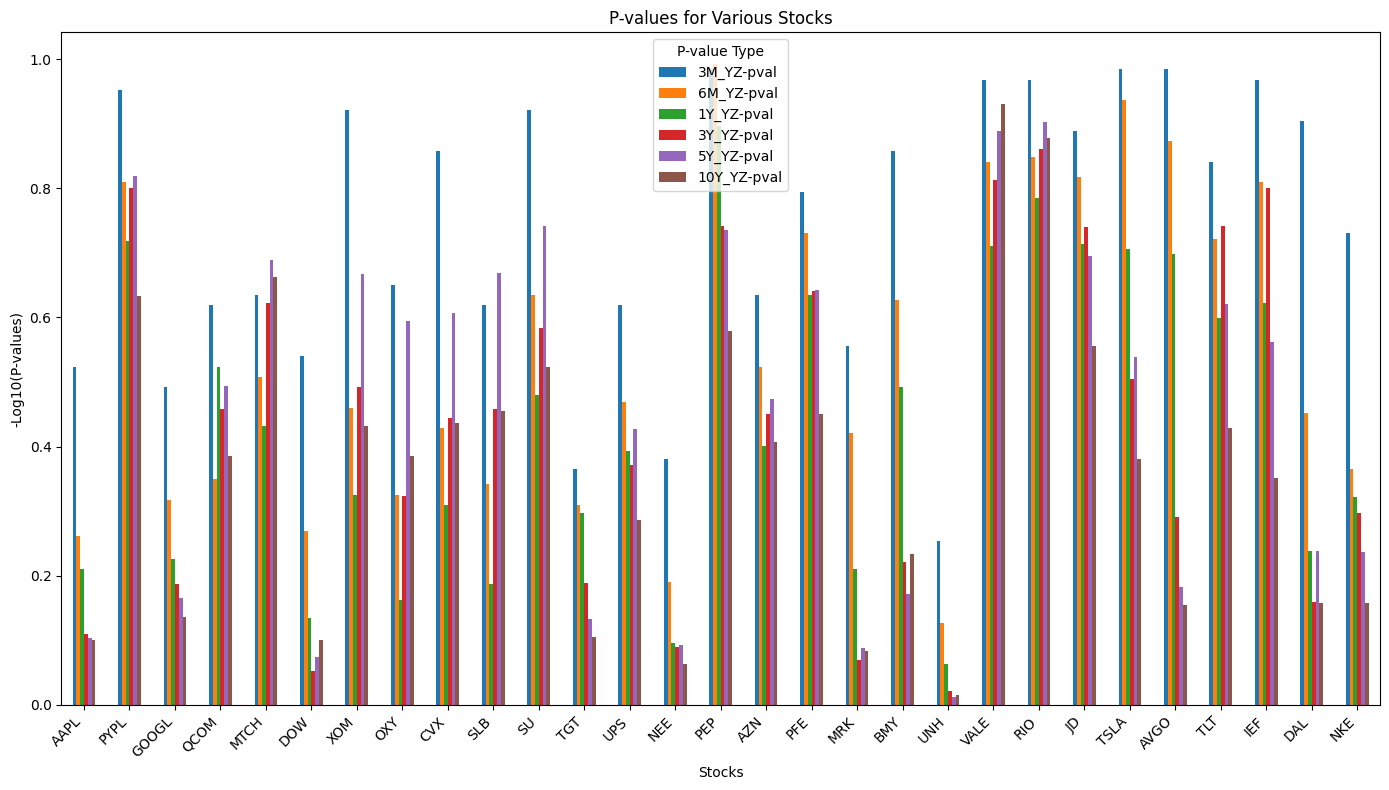

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Convert the data into a DataFrame
df = pd.DataFrame(p_val).T

# Apply -log10 transformation to the p-values
#df_log = -np.log10(df)
df_log=df
# Plotting the transformed values
fig, ax = plt.subplots(figsize=(14, 8))
df_log.plot(kind='bar', ax=ax)

# Adding labels and title
plt.title("P-values for Various Stocks")#-Log10 Transformed 
plt.xlabel("Stocks")
plt.ylabel("-Log10(P-values)")
plt.xticks(rotation=45, ha='right')
plt.legend(title='P-value Type')
plt.tight_layout()

# Show plot
plt.show()


In [212]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

class KDJCrossoverDetector:
    def __init__(self, data,n=9, m1=3, m2=3):
        """
        Initialize KDJ Crossover Detector
        
        Parameters:
        symbol: Stock symbol (e.g., 'AAPL', 'TSLA')
        period: Data period ('1y', '2y', '5y', 'max', etc.)
        n: Period for %K calculation (default: 9)
        m1: Smoothing period for %K (default: 3)
        m2: Smoothing period for %D (default: 3)
        """
        self.n = n
        self.m1 = m1
        self.m2 = m2
        self.data = data
        self.kdj_data = None
        self.symbol=data.columns[0][1]
    
    def calculate_kdj(self):
        """Calculate KDJ indicator"""
        if self.data is None:
            print("No data available. Please fetch data first.")
            return None
        
        df = self.data.copy()
        
        # Ensure all price columns are numeric
        # for col in ['High', 'Low', 'Close']:
        #     df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # Remove any rows with NaN values in price data
        df.columns=[i[0] for i in df.columns]
        #print(df)
        #df = df.dropna(subset=['High', 'Low', 'Close'])
        
        # Calculate RSV (Raw Stochastic Value)
        low_n = df['Low'].rolling(window=self.n).min()
        high_n = df['High'].rolling(window=self.n).max()
        
        # Calculate RSV with proper handling of division by zero
        denominator = high_n - low_n
        rsv = np.where(denominator != 0, 100 * (df['Close'] - low_n) / denominator, 50)
        rsv = pd.Series(rsv, index=df.index)
        
        # Initialize K, D, J series
        k_values = []
        d_values = []
        j_values = []
        
        # Initial values
        k_prev = 50.0  # Starting value for K
        d_prev = 50.0  # Starting value for D
        
        for i, rsv_val in enumerate(rsv):
            # Ensure rsv_val is numeric
            if pd.isna(rsv_val) or not isinstance(rsv_val, (int, float)):
                rsv_val = 50.0
            else:
                rsv_val = float(rsv_val)
            
            # Calculate K: K = (2/3) * K_prev + (1/3) * RSV
            k_curr = (2.0/3.0) * float(k_prev) + (1.0/3.0) * rsv_val
            
            # Calculate D: D = (2/3) * D_prev + (1/3) * K
            d_curr = (2.0/3.0) * float(d_prev) + (1.0/3.0) * k_curr
            
            # Calculate J: J = 3*K - 2*D
            j_curr = 3.0 * k_curr - 2.0 * d_curr
            
            k_values.append(k_curr)
            d_values.append(d_curr)
            j_values.append(j_curr)
            
            k_prev = k_curr
            d_prev = d_curr
        
        # Add KDJ to dataframe
        df['K'] = k_values
        df['D'] = d_values
        df['J'] = j_values
        df['RSV'] = rsv
        
        self.kdj_data = df
        return df
    
    def detect_crossovers(self):
        """Detect KDJ crossover signals"""
        if self.kdj_data is None:
            print("KDJ data not calculated. Please calculate KDJ first.")
            return None
        
        df = self.kdj_data.copy()
        
        # Calculate crossover signals
        df['K_cross_D'] = np.where(
            (df['K'].shift(1) <= df['D'].shift(1)) & (df['K'] > df['D']), 1,
            np.where((df['K'].shift(1) >= df['D'].shift(1)) & (df['K'] < df['D']), -1, 0)
        )
        
        df['K_cross_J'] = np.where(
            (df['K'].shift(1) <= df['J'].shift(1)) & (df['K'] > df['J']), 1,
            np.where((df['K'].shift(1) >= df['J'].shift(1)) & (df['K'] < df['J']), -1, 0)
        )
        
        df['D_cross_J'] = np.where(
            (df['D'].shift(1) <= df['J'].shift(1)) & (df['D'] > df['J']), 1,
            np.where((df['D'].shift(1) >= df['J'].shift(1)) & (df['D'] < df['J']), -1, 0)
        )
        
        # Golden Cross (bullish): K crosses above D
        df['Golden_Cross'] = (df['K_cross_D'] == 1)
        
        # Death Cross (bearish): K crosses below D
        df['Death_Cross'] = (df['K_cross_D'] == -1)
        
        # Additional signals
        df['Bullish_Signal'] = (
            (df['K_cross_D'] == 1) | 
            ((df['K'] > df['D']) & (df['J'] > df['K']) & (df['K'] > 20))
        )
        
        df['Bearish_Signal'] = (
            (df['K_cross_D'] == -1) | 
            ((df['K'] < df['D']) & (df['J'] < df['K']) & (df['K'] < 80))
        )
        
        self.kdj_data = df
        return df

    def get_crossover_summary(self, days=30):
        """Get summary of recent crossover signals"""
        if self.kdj_data is None:
            return "No KDJ data available"
        
        recent_data = self.kdj_data.tail(days)
        
        golden_crosses = recent_data[recent_data['Golden_Cross']].index.tolist()
        death_crosses = recent_data[recent_data['Death_Cross']].index.tolist()
        
        summary = f"\n=== KDJ Crossover Summary for {self.symbol} (Last {days} days) ===\n"
        
        if golden_crosses:
            summary += f"Golden Crosses (Bullish): {len(golden_crosses)}\n"
            for date in golden_crosses[-3:]:  # Show last 3
                k_val = recent_data.loc[date, 'K']
                d_val = recent_data.loc[date, 'D']
                summary += f"  - {date.strftime('%Y-%m-%d')}: K({k_val:.2f}) crossed above D({d_val:.2f})\n"
        
        if death_crosses:
            summary += f"Death Crosses (Bearish): {len(death_crosses)}\n"
            for date in death_crosses[-3:]:  # Show last 3
                k_val = recent_data.loc[date, 'K']
                d_val = recent_data.loc[date, 'D']
                summary += f"  - {date.strftime('%Y-%m-%d')}: K({k_val:.2f}) crossed below D({d_val:.2f})\n"
        return summary
        
        # Current values
    def signalling(self,parameter=2):
        latest = self.kdj_data.iloc[-1]
        summary=''
        summary += f"\nCurrent Values ({latest.name.strftime('%Y-%m-%d')}):\n"
        summary += f"  K: {latest['K']:.2f}\n"
        summary += f"  D: {latest['D']:.2f}\n"
        summary += f"  J: {latest['J']:.2f}\n"
        summary += f"  Price: ${latest['Close']:.2f}\n"
        
        # Check if K, D, J values are very close (within 1 point)
        k_val = latest['K']
        d_val = latest['D']
        j_val = latest['J']
        
        kd_diff = abs(k_val - d_val)
        kj_diff = abs(k_val - j_val)
        dj_diff = abs(d_val - j_val)
        
        summary=None
        if (kd_diff <= parameter) or (kj_diff <= parameter) or (dj_diff <= parameter):
            summary =f"\n⚠️  WARNING: KDJ values are converging!\n"
            summary += f"   K-D difference: {kd_diff:.2f}\n"
            summary += f"   K-J difference: {kj_diff:.2f}\n"
            summary += f"   D-J difference: {dj_diff:.2f}\n"
            summary += f"   This may indicate an upcoming crossover or period of indecision.\n"
        
        return summary
    
    def plot_kdj(self, days=60):
        """Plot KDJ indicator with crossover signals"""
        if self.kdj_data is None:
            print("No KDJ data to plot")
            return
        
        recent_data = self.kdj_data.tail(days)
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), 
                                       gridspec_kw={'height_ratios': [2, 1]})
        
        # Plot price and signals
        ax1.plot(recent_data.index, recent_data['Close'], label='Close Price', linewidth=2)
        
        # Mark crossover points
        golden_crosses = recent_data[recent_data['Golden_Cross']]
        death_crosses = recent_data[recent_data['Death_Cross']]
        
        if not golden_crosses.empty:
            ax1.scatter(golden_crosses.index, golden_crosses['Close'], 
                       color='green', marker='^', s=100, label='Golden Cross', zorder=5)
        
        if not death_crosses.empty:
            ax1.scatter(death_crosses.index, death_crosses['Close'], 
                       color='red', marker='v', s=100, label='Death Cross', zorder=5)
        
        ax1.set_title(f'{self.symbol} Price with KDJ Crossover Signals')
        ax1.set_ylabel('Price ($)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot KDJ lines
        ax2.plot(recent_data.index, recent_data['K'], label='K', color='blue', linewidth=2)
        ax2.plot(recent_data.index, recent_data['D'], label='D', color='red', linewidth=2)
        ax2.plot(recent_data.index, recent_data['J'], label='J', color='green', linewidth=1, alpha=0.7)
        
        # Add horizontal lines for overbought/oversold levels
        ax2.axhline(y=80, color='red', linestyle='--', alpha=0.5, label='Overbought (80)')
        ax2.axhline(y=20, color='green', linestyle='--', alpha=0.5, label='Oversold (20)')
        ax2.axhline(y=50, color='gray', linestyle='-', alpha=0.3)
        
        ax2.set_title('KDJ Indicator')
        ax2.set_ylabel('KDJ Values')
        ax2.set_xlabel('Date')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_ylim(0, 100)
        
        plt.tight_layout()
        plt.show()
    
    def run_analysis(self,verbose=False):
        """Run complete KDJ analysis"""
        #print(f"Starting KDJ analysis for {self.data.columns[0][1]}...")
        
        # Fetch data
        # if not self.fetch_data():
        #     return
        
        # Calculate KDJ
        self.calculate_kdj()
        print("KDJ indicator calculated successfully")
        
        # Detect crossovers
        self.detect_crossovers()
        
        if verbose:
            #Print summary
            print(self.get_crossover_summary())

        signal=self.signalling()
        if (signal is not None) or verbose:
            print("Crossover signals detected")
            print(signal)
        # Plot results
            self.plot_kdj()
            return signal
        #print(self.get_crossover_summary())

# def main():
#     """Example usage"""
#     # Example 1: Analyze Apple stock
#     print("=== KDJ Crossover Analysis ===")
    
#     detector = KDJCrossoverDetector(data2)
#     detector.run_analysis()
    
    # # Example 2: Quick analysis of multiple stocks
    # symbols = ['TSLA', 'GOOGL', 'MSFT']
    
    # print("\n" + "="*50)
    # print("QUICK ANALYSIS OF MULTIPLE STOCKS")
    # print("="*50)
    
    # for symbol in symbols:
    #     print(f"\n--- {symbol} ---")
    #     detector = KDJCrossoverDetector(symbol, period='3mo')
    #     if detector.fetch_data():
    #         detector.calculate_kdj()
    #         detector.detect_crossovers()
    #         print(detector.get_crossover_summary(days=10))

# if __name__ == "__main__":
#     main()

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PFE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2007-01-02)')
[*********************100%***********************]  1 of 1 completed

Processing data request for PFE from 2007-01-01 to 2025-05-31...
Found cached data for PFE (last updated: 2025-05-31 21:52:38)
Fetching missing data for PFE: 2007-01-01 to 2007-01-02
Fetching missing data for PFE: 2025-05-31 to 2025-05-31
Data download complete for PFE. Shape: (4632, 5)
KDJ indicator calculated successfully

=== KDJ Crossover Summary for PFE (Last 30 days) ===
Golden Crosses (Bullish): 1
  - 2025-05-16: K(39.47) crossed above D(36.93)
Death Crosses (Bearish): 1
  - 2025-05-06: K(64.45) crossed below D(75.64)

Crossover signals detected
None


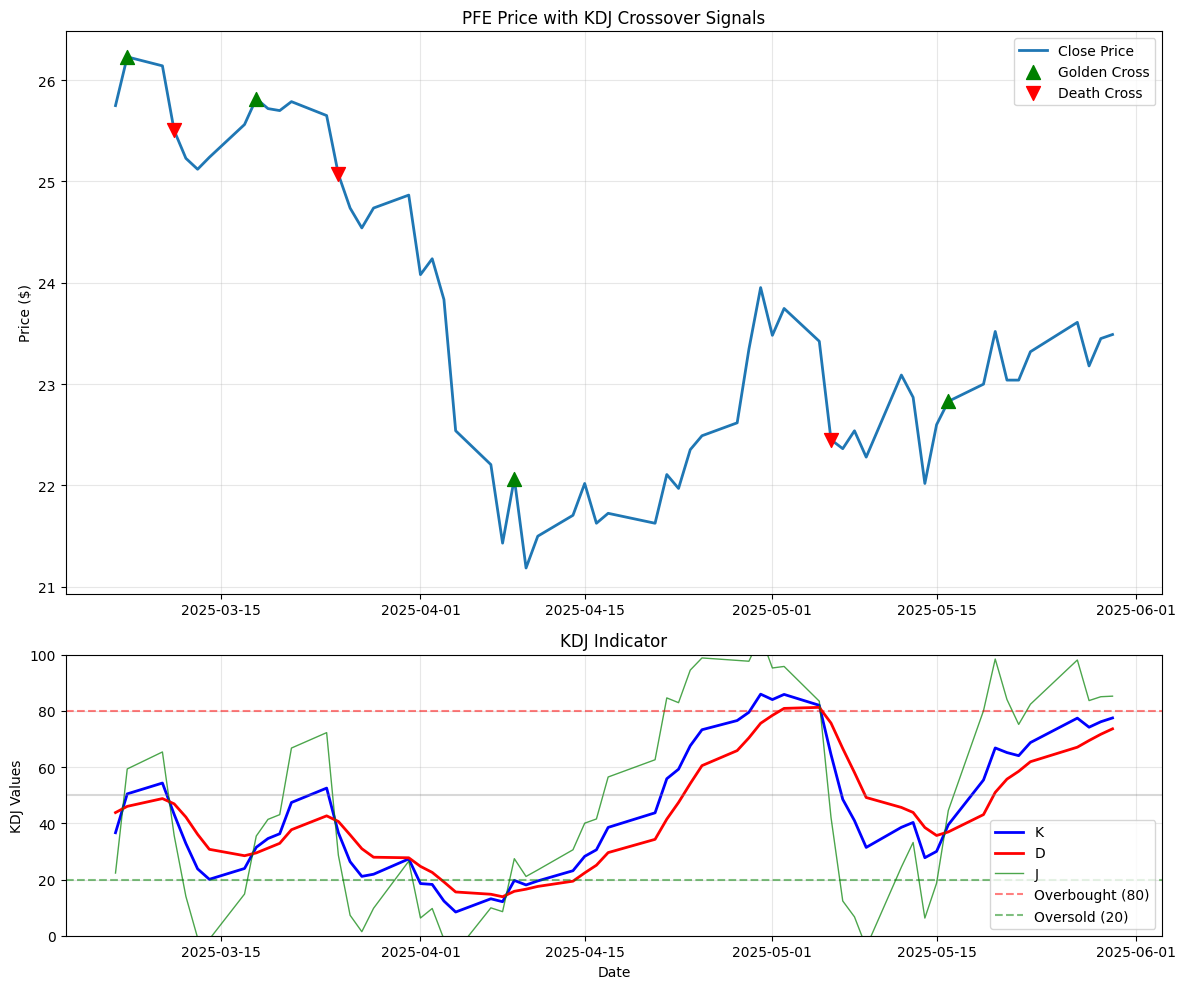

In [206]:
stock='PFE'
data =  downloader(stock, start_date,end_date)
detector = KDJCrossoverDetector(data)
signal=detector.run_analysis(verbose=True)

Processing data request for UTG.L from 2007-01-01 to 2025-05-31...
No cached data found for UTG.L - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for UTG.L. Shape: (4651, 5)
KDJ indicator calculated successfully
Processing data request for DOM.L from 2007-01-01 to 2025-05-31...
No cached data found for DOM.L - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for DOM.L. Shape: (4651, 5)
KDJ indicator calculated successfully
Processing data request for GLEN.L from 2007-01-01 to 2025-05-31...
No cached data found for GLEN.L - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for GLEN.L. Shape: (3543, 5)
KDJ indicator calculated successfully
Processing data request for DGE.L from 2007-01-01 to 2025-05-31...
No cached data found for DGE.L - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for DGE.L. Shape: (4650, 5)
KDJ indicator calculated successfully
Processing data request for POLR.L from 2007-01-01 to 2025-05-31...
No cached data found for POLR.L - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for POLR.L. Shape: (4626, 5)
KDJ indicator calculated successfully
Crossover signals detected

⚠️  WARNING: KDJ values are converging!
   K-D difference: 0.42
   K-J difference: 0.84
   D-J difference: 1.26
   This may indicate an upcoming crossover or period of indecision.



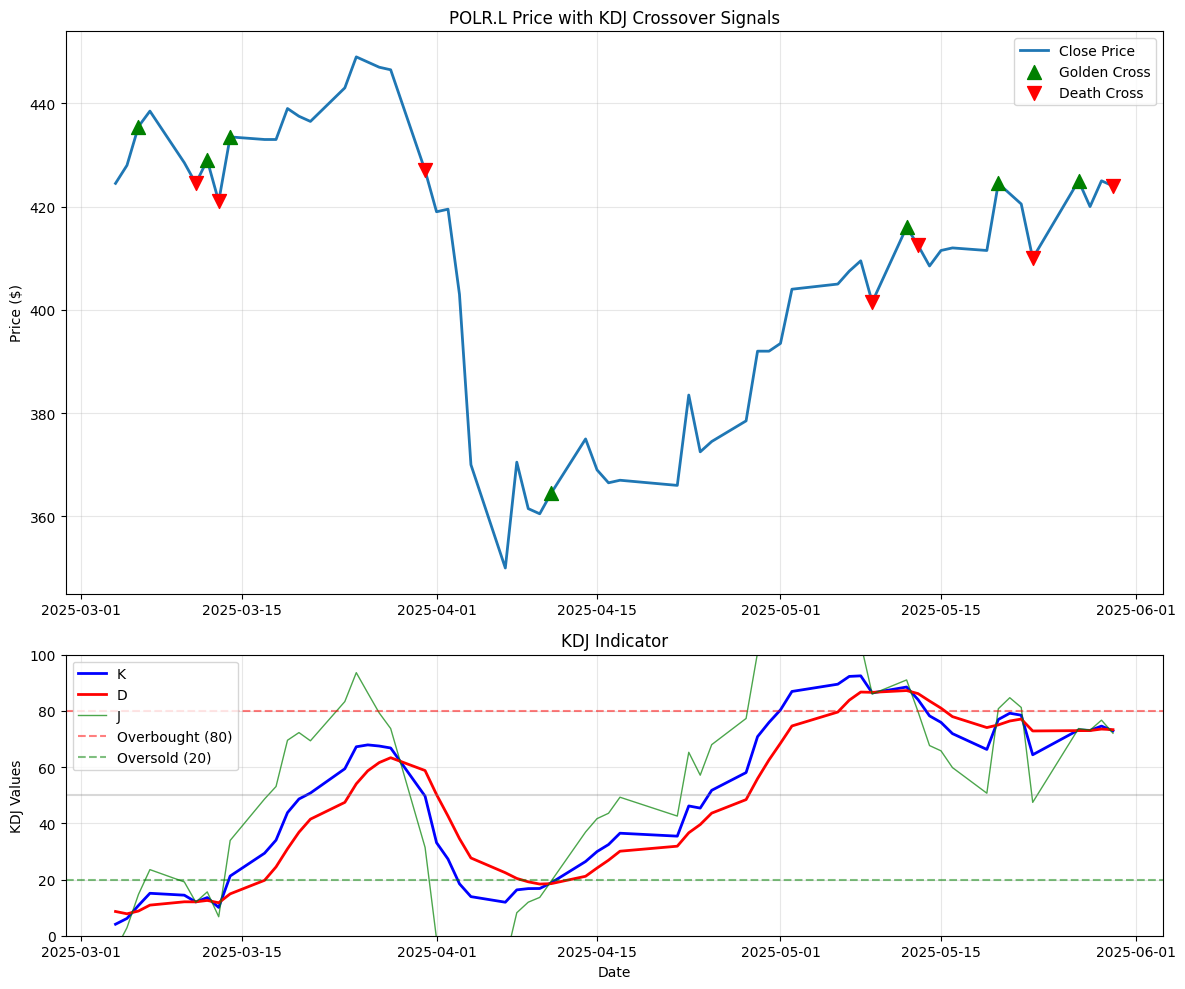

Processing data request for IPX.L from 2007-01-01 to 2025-05-31...
No cached data found for IPX.L - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for IPX.L. Shape: (4651, 5)
KDJ indicator calculated successfully
Processing data request for WPP.L from 2007-01-01 to 2025-05-31...
No cached data found for WPP.L - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for WPP.L. Shape: (4650, 5)
KDJ indicator calculated successfully
Processing data request for SAFE.L from 2007-01-01 to 2025-05-31...
No cached data found for SAFE.L - downloading all data...


[*********************100%***********************]  1 of 1 completed

Data download complete for SAFE.L. Shape: (4603, 5)
KDJ indicator calculated successfully


In [216]:
signals=dict()
for stock in uk_symbols:
    
    data =  downloader(stock, start_date,end_date)
    detector = KDJCrossoverDetector(data)
    signal=detector.run_analysis()
    if signal is not None:
        signals[stock]=signal

In [217]:
signals

{'POLR.L': '\n⚠️  WARNING: KDJ values are converging!\n   K-D difference: 0.42\n   K-J difference: 0.84\n   D-J difference: 1.26\n   This may indicate an upcoming crossover or period of indecision.\n'}

In [164]:
data

Close       High        Low       Open    Volume  \
Date                                                               
2007-01-03   9.634974   9.836217   9.550137   9.667529  17299200   
2007-01-04   9.733624   9.763219   9.555071   9.634976  15085600   
2007-01-05   9.749405   9.806621   9.637932   9.677391  14996800   
2007-01-08   9.719813   9.765191   9.631030   9.716854  10109600   
2007-01-09   9.841148   9.858905   9.703041   9.719811  15167200   
...               ...        ...        ...        ...       ...   
2025-05-15  62.400002  62.680000  60.419998  60.639999  14371100   
2025-05-16  63.110001  63.750000  62.500000  62.500000  12950600   
2025-05-19  62.080002  62.430000  61.759998  62.150002  15105300   
2025-05-20  62.560001  63.189999  62.279999  62.500000  10771800   
2025-05-21  59.980000  61.759998  59.880001  61.169998  17354700   

            GK_Volatility  YZ_Volatility  
Date                                      
2007-01-03            NaN            NaN  
2007-01-04            NaN            NaN  
2007-01-05            NaN            NaN  
2007-01-08            NaN            NaN  
2007-01-09            NaN            NaN  
...                   ...            ...  
2025-05-15       0.287548       0.432305  
2025-05-16       0.281116       0.428843  
2025-05-19       0.252806       0.411476  
2025-05-20       0.242664       0.405377  
2025-05-21       0.234574       0.396442  

[4626 rows x 7 columns]

In [88]:
larger_proportion(res_dict['PFE']['YZ_Volatility'].dropna(),0.5)

0.03430308293530178

In [92]:
import seaborn as sns
def validate_volatility_estimators(data, window=20, trading_periods=252):
    """
    Comprehensive validation of volatility estimators with multiple metrics.
    
    Parameters:
    data: DataFrame containing 'GK_Volatility' and 'YZ_Volatility'
    window: Lookback window for realized volatility calculation
    trading_periods: Annualization factor (default 252)
    
    Returns:
    pd.Series with validation metrics
    """
    # Calculate realized volatility benchmark
    realized_vol = data['Close'].pct_change().rolling(window).std() * np.sqrt(trading_periods)
    #return realized_vol
    metrics = {
        # Error metrics
        'GK vs Realized MAE': (data['GK_Volatility'] - realized_vol).abs().mean(),
        'YZ vs Realized MAE': (data['YZ_Volatility'] - realized_vol).abs().mean(),
        'GK vs Realized RMSE': np.sqrt(((data['GK_Volatility'] - realized_vol)**2).mean()),
        'YZ vs Realized RMSE': np.sqrt(((data['YZ_Volatility'] - realized_vol)**2).mean()),
        
        # Correlation analysis
        'GK-YZ Correlation': data['GK_Volatility'].corr(data['YZ_Volatility']),
        'GK-Realized Corr': data['GK_Volatility'].corr(realized_vol),
        'YZ-Realized Corr': data['YZ_Volatility'].corr(realized_vol),
        
        # Volatility ratio analysis
        'Avg YZ/GK Ratio': data['YZ_Volatility'].mean() / data['GK_Volatility'].mean(),
        'Max YZ/GK Ratio': (data['YZ_Volatility'] / data['GK_Volatility']).max(),
        'Min YZ/GK Ratio': (data['YZ_Volatility'] / data['GK_Volatility']).min()
    }
    
    return pd.Series(metrics).round(4)

def plot_volatility_analysis(data, symbol):
    """
    Enhanced visualization with four complementary views
    """
    fig = plt.figure(figsize=(16, 18))
    gs = fig.add_gridspec(4, 2)
    
    # Price and Volatility Timeline
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(data['Close'], label='Price', color='#1f77b4')
    ax1.set_title(f'{symbol} Price Action', pad=20)
    ax1.set_ylabel('Price ($)', labelpad=15)
    ax1.grid(True, alpha=0.3)
    
    # Volatility Comparison
    ax2 = fig.add_subplot(gs[1, :])
    ax2.plot(data['GK_Volatility'], label='Garman-Klass', color='#2ca02c')
    ax2.plot(data['YZ_Volatility'], label='Yang-Zhang', color='#d62728')
    ax2.set_title('Volatility Estimators Comparison', pad=20)
    ax2.set_ylabel('Annualized Volatility', labelpad=15)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Estimator Difference Analysis
    ax3 = fig.add_subplot(gs[2, 0])
    diff = data['YZ_Volatility'] - data['GK_Volatility']
    sns.histplot(diff.dropna(), kde=True, color='#9467bd', ax=ax3)
    ax3.set_title('Distribution of YZ-GK Volatility Difference')
    ax3.set_xlabel('Volatility Difference')
    ax3.grid(True, alpha=0.3)
    
    # Error Metrics Radar Chart
    ax4 = fig.add_subplot(gs[2, 1], polar=True)
    metrics = validate_volatility_estimators(data)
    error_metrics = metrics[['GK vs Realized MAE', 'YZ vs Realized MAE', 
                            'GK vs Realized RMSE', 'YZ vs Realized RMSE']]
    
    categories = error_metrics.index.str.replace(' vs Realized ', '\n')
    values = error_metrics.values
    values = np.concatenate((values, [values[0]]))
    
    angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]
    
    ax4.plot(angles, values, color='#ff7f0e', linewidth=2)
    ax4.fill(angles, values, color='#ff7f0e', alpha=0.25)
    ax4.set_xticks(angles[:-1])
    ax4.set_xticklabels(categories)
    ax4.set_title('Error Metrics Comparison', pad=30)
    
    # Correlation Matrix
    ax5 = fig.add_subplot(gs[3, :])
    corr_matrix = data[['GK_Volatility', 'YZ_Volatility']].join(
        realized_vol.rename('Realized_Vol')).corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=ax5,
                annot_kws={"size": 14}, cbar=False)
    ax5.set_title('Volatility Estimators Correlation Matrix', pad=20)
    
    plt.tight_layout()
    plt.show()


[*********************100%***********************]  1 of 1 completed

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

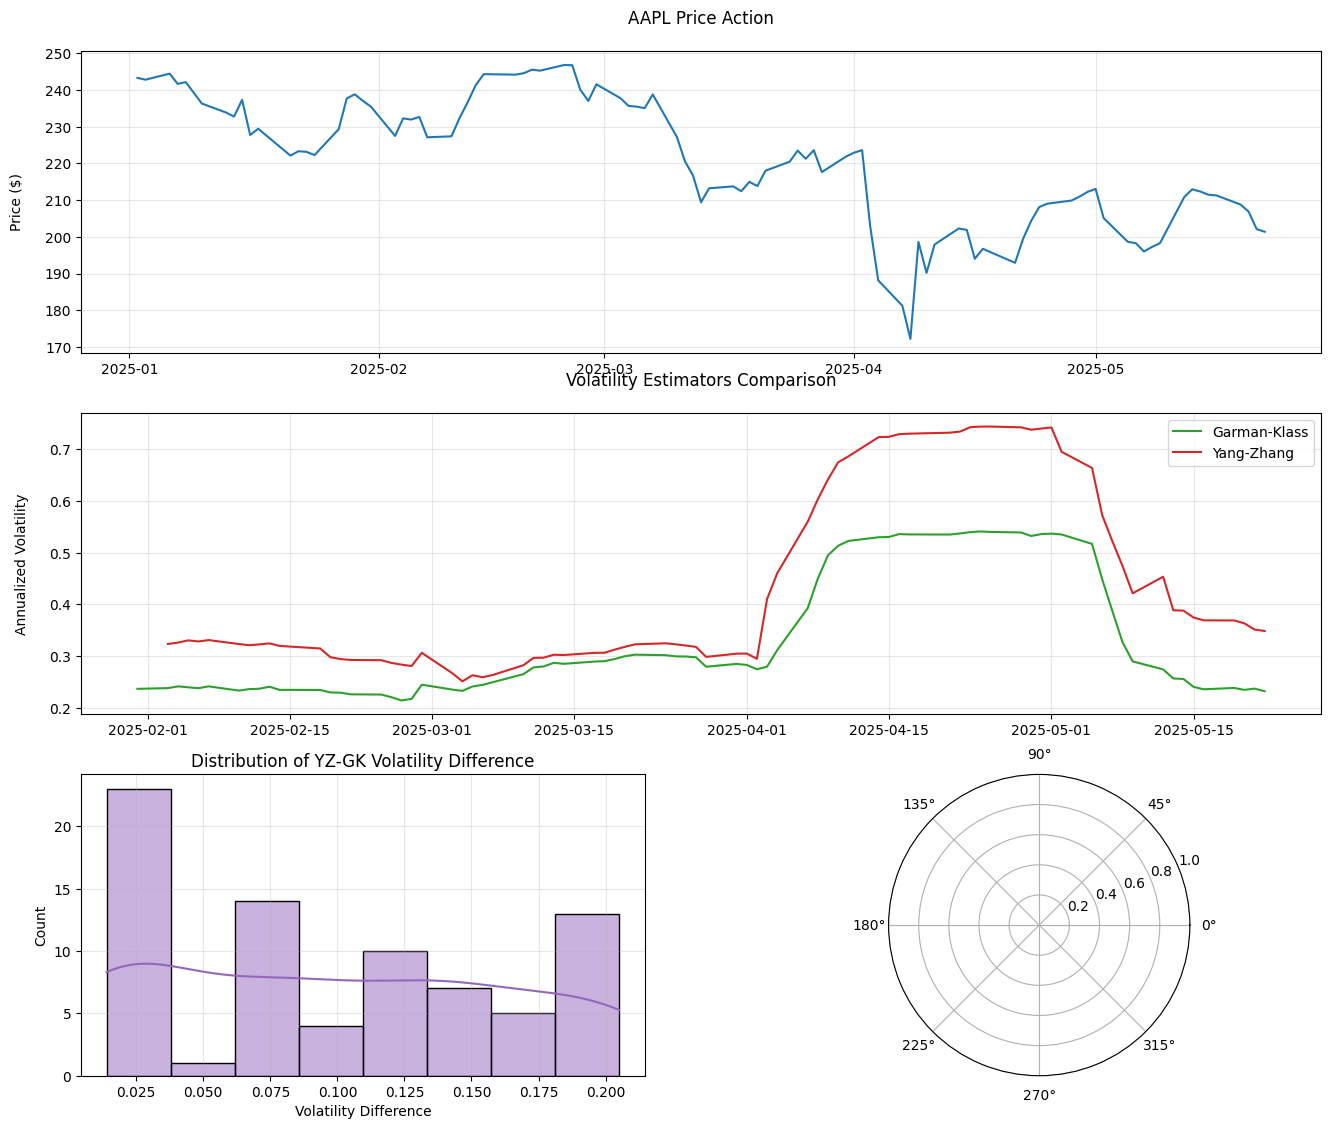

In [93]:
symbols = ['AAPL', 'GOOGL', 'MSFT', 'TSLA']
comparison_data = {}

for stock in symbols:
    # try:
    data = download_and_calculate_volatility(stock, start_date, end_date)

    plot_volatility_analysis(data,stock)
    # except Exception as e:
    #     print(f"Error processing {stock}: {e}")



li=[]
for i in range(1,2):
    file_path="data/active_options_stocks/"+str(i)+"_Most Active Stock Options - TipRanks.com.html"
    with open(file_path, 'r', encoding='utf-8') as file:
        html_content = file.read()
    soup = BeautifulSoup(html_content, 'html.parser')
    table = soup.find('table', class_='screenerTable')

    # Extract headers
    headers = [th.get_text(strip=True) for th in table.thead.find_all('th')]

    # Extract rows
    rows = []
    for row in table.tbody.find_all('tr', class_='rt-tr'):
        cells = row.find_all('td', class_='rt-td')
        row_data = [cell.get_text(strip=True) for cell in cells]
        rows.append(row_data)

    # Create DataFrame
    df = pd.DataFrame(rows, columns=headers)
    li.append(df)
active_options_stocks=pd.concat(li)
active_options_stocks.set_index('Symbol',drop=True,inplace=True)